# Aphid-Ladybeetle study

In [167]:
import numpy as np  # linear algebra
from numba import jit

import arviz as az
from arviz.utils import Numba
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd
import pymc3 as pm  # for uncertainty quantification and model calibration
import theano  # to control better pymc3 backend and write a wrapper
import theano.tensor as t  # for the wrapper to a custom model to pymc3
import time
import warnings

np.seterr('warn')
warnings.filterwarnings("ignore")
az.style.use("arviz-darkgrid")

Numba.enable_numba()

seed = 1234
np.random.seed(seed)

## Obtaining Initial Conditions

We need to define Initial Conditions as functions in order to define them for each discretization point. Here we will fit ICs as polynomial functions.

Loading data:

### 2018_Lin_and_Pennings

In [2]:
data_dir = "../data/2018 Lin and Pennings/appendix/"
aphid_data = pd.read_csv(data_dir + 'aphid.CSV')
ladybeetle_data = pd.read_csv(data_dir + 'ladybeetle.CSV')

In [3]:
aphid_data

Location  Time  Date  Location_code  Patch_ID  Density
0        NaN     1   NaN            NaN       NaN   2343.0
1        NaN     2   NaN            NaN       NaN   2611.0
2        NaN     3   NaN            NaN       NaN   2554.0
3        NaN     4   NaN            NaN       NaN   2297.0
4        NaN     5   NaN            NaN       NaN   3077.0
5        NaN     6   NaN            NaN       NaN   3080.0
6        NaN     7   NaN            NaN       NaN   2969.0
7        NaN     8   NaN            NaN       NaN   2558.0
8        NaN     9   NaN            NaN       NaN   2423.0
9        NaN    10   NaN            NaN       NaN   2802.0
10       NaN    11   NaN            NaN       NaN   2579.0
11       NaN    14   NaN            NaN       NaN   2038.0
12       NaN    15   NaN            NaN       NaN   1916.0
13       NaN    16   NaN            NaN       NaN   1788.0
14       NaN    17   NaN            NaN       NaN   1114.0
15       NaN    18   NaN            NaN       NaN    818.0
16       NaN    19   NaN            NaN       NaN    652.0
17       NaN    20   NaN            NaN       NaN    627.0
18       NaN    21   NaN            NaN       NaN    727.0
19       NaN    22   NaN            NaN       NaN    557.0
20       NaN    23   NaN            NaN       NaN    606.0
21       NaN    24   NaN            NaN       NaN    562.0
22       NaN    25   NaN            NaN       NaN    662.0
23       NaN    29   NaN            NaN       NaN    659.0
24       NaN    30   NaN            NaN       NaN    625.0
25       NaN    31   NaN            NaN       NaN    556.0
26       NaN    32   NaN            NaN       NaN    588.0
27       NaN    35   NaN            NaN       NaN    621.0
28       NaN    36   NaN            NaN       NaN    616.0
29       NaN    37   NaN            NaN       NaN    421.0
30       NaN    38   NaN            NaN       NaN    381.0
31       NaN    39   NaN            NaN       NaN    219.0
32       NaN    40   NaN            NaN       NaN    234.0
33       NaN    41   NaN            NaN       NaN    191.0

In [4]:
ladybeetle_data

Location  Time  Date  Location_code  Patch_ID  Density
0        NaN     1   NaN            NaN       NaN      7.0
1        NaN     2   NaN            NaN       NaN      8.0
2        NaN     3   NaN            NaN       NaN      7.0
3        NaN     4   NaN            NaN       NaN      5.0
4        NaN     5   NaN            NaN       NaN      4.0
5        NaN     6   NaN            NaN       NaN      3.0
6        NaN     7   NaN            NaN       NaN      2.0
7        NaN     8   NaN            NaN       NaN      3.0
8        NaN     9   NaN            NaN       NaN      4.0
9        NaN    10   NaN            NaN       NaN      3.0
10       NaN    11   NaN            NaN       NaN      1.0
11       NaN    14   NaN            NaN       NaN      9.0
12       NaN    15   NaN            NaN       NaN      7.0
13       NaN    16   NaN            NaN       NaN      7.0
14       NaN    17   NaN            NaN       NaN      7.0
15       NaN    18   NaN            NaN       NaN      6.0
16       NaN    19   NaN            NaN       NaN      6.0
17       NaN    20   NaN            NaN       NaN      3.0
18       NaN    21   NaN            NaN       NaN      2.0
19       NaN    22   NaN            NaN       NaN      3.0
20       NaN    23   NaN            NaN       NaN      4.0
21       NaN    24   NaN            NaN       NaN      2.0
22       NaN    25   NaN            NaN       NaN      1.0
23       NaN    29   NaN            NaN       NaN      7.0
24       NaN    30   NaN            NaN       NaN      5.0
25       NaN    31   NaN            NaN       NaN      2.0
26       NaN    32   NaN            NaN       NaN      1.0
27       NaN    35   NaN            NaN       NaN      5.0
28       NaN    36   NaN            NaN       NaN      6.0
29       NaN    37   NaN            NaN       NaN      4.0
30       NaN    38   NaN            NaN       NaN      3.0
31       NaN    39   NaN            NaN       NaN      2.0
32       NaN    40   NaN            NaN       NaN      2.0
33       NaN    41   NaN            NaN       NaN      0.0

Retrieving IC data:

In [5]:
aphid_ic = aphid_data[aphid_data.Time == 1].Density.values[0]
ladybeetle_ic = ladybeetle_data[ladybeetle_data.Time == 1].Density.values[0]

In [6]:
aphid_ic

2343.0

In [7]:
ladybeetle_ic

7.0

In [8]:
y0_BKM = aphid_ic, ladybeetle_ic

y0_BKM

(2343.0, 7.0)

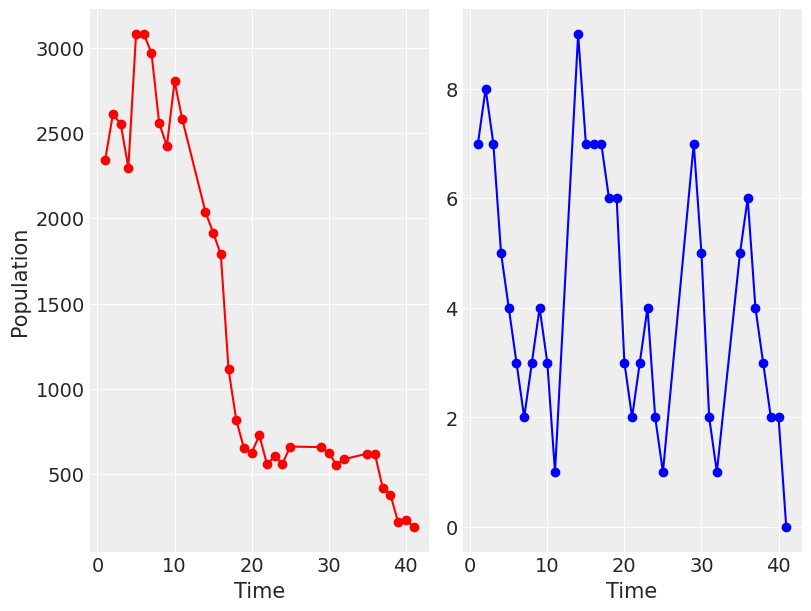

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

ax1.plot(aphid_data.Time.values, aphid_data.Density.values, '-o', c='r')
ax1.set(xlabel='Time', ylabel='Population')
ax2.plot(ladybeetle_data.Time.values, ladybeetle_data.Density.values, '-o', c='b')
ax2.set(xlabel='Time')
plt.show()

# Prey-Predator Banks-Kareiva-Murphy A model

In [10]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def BKMA_model(
    t,
    X,
    r1 = 0.136,
    r2 = 0.48e-3,
    p = 0.032,
    i = 11.0,
    e1 = 0.0012,
    e2 = 20.9,
    e3 = 0.009,
):
    """
    Prey-Predator Banks-Kareiva-Murphy A model (BKMA) python implementation.
    """
    u, v = X
    u_prime = r1 * u - r2 * u * u - p * u * v
    v_prime = i - ( e1 + e2 * np.exp( - e3 * u ) ) * v
    return u_prime, v_prime

def BKMA_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 0.136,
    r2 = 0.48e-3,
    p = 0.032,
    i = 11.0,
    e1 = 0.0012,
    e2 = 20.9,
    e3 = 0.009,
):
    solution_ODE = solve_ivp(
        fun=BKMA_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1, r2, p, i, e1, e2, e3),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
t0 = 0
tf = 60
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [11]:
def BKMA_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1e3
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [12]:
from scipy import optimize

r1=46.32166847737433
r2=9.533324619539296e-09
p=6.506856453951996
i=0.03097896528819232
e1=6.774786031845174e-08
e2=0.004623799343568372
e3=5.1998548164782127e-05
denom_min = 0.1
denom_max = 1.9
bounds_BKMA = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),  # r2
    ( ( p * denom_min ), ( p * denom_max ) ),    # p
    ( ( i * denom_min ), ( i * denom_max ) ),    # i
    ( ( e1 * denom_min ), ( e1 * denom_max ) ),  # e1
    ( ( e2 * denom_min ), ( e2 * denom_max ) ),  # e2
    ( ( e3 * denom_min ), ( e3 * denom_max ) ),  # e3
]

result_BKMA = optimize.differential_evolution(
    BKMA_least_squares_error_ode,
    bounds=bounds_BKMA,
    args=(
        aphid_data.Time.values,
        [u_data, v_data],
        BKMA_ode_solver,
        y0_BKM,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=2000,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1,
)

print(result_BKMA)

differential_evolution step 1: f(x)= 4.40819e+07
parameters = [1.74321022e+01 6.04607094e-09 2.67566382e+00 4.15516245e-02
 7.08084073e-08 5.33401074e-03 8.20741416e-05]

differential_evolution step 2: f(x)= 6.24122e+06
parameters = [8.56512021e+00 7.10537581e-09 1.22042018e+00 4.52036296e-02
 7.02748979e-08 5.91619057e-03 8.74691686e-05]

differential_evolution step 3: f(x)= 6.24122e+06
parameters = [8.56512021e+00 7.10537581e-09 1.22042018e+00 4.52036296e-02
 7.02748979e-08 5.91619057e-03 8.74691686e-05]

differential_evolution step 4: f(x)= 6.24122e+06
parameters = [8.56512021e+00 7.10537581e-09 1.22042018e+00 4.52036296e-02
 7.02748979e-08 5.91619057e-03 8.74691686e-05]

differential_evolution step 5: f(x)= 3.0504e+06
parameters = [7.11391394e+00 1.33543975e-08 1.00057003e+00 5.00200366e-02
 6.10413129e-08 5.94637842e-03 8.30282848e-05]

differential_evolution step 6: f(x)= 3.0504e+06
parameters = [7.11391394e+00 1.33543975e-08 1.00057003e+00 5.00200366e-02
 6.10413129e-08 5.946378

differential_evolution step 49: f(x)= 1.07404e+06
parameters = [1.88053871e+01 1.29270032e-08 2.67472986e+00 4.50082212e-02
 3.75240586e-08 7.08400047e-03 8.90701790e-05]

differential_evolution step 50: f(x)= 1.07404e+06
parameters = [1.88053871e+01 1.29270032e-08 2.67472986e+00 4.50082212e-02
 3.75240586e-08 7.08400047e-03 8.90701790e-05]

differential_evolution step 51: f(x)= 1.07404e+06
parameters = [1.88053871e+01 1.29270032e-08 2.67472986e+00 4.50082212e-02
 3.75240586e-08 7.08400047e-03 8.90701790e-05]

differential_evolution step 52: f(x)= 1.07404e+06
parameters = [1.88053871e+01 1.29270032e-08 2.67472986e+00 4.50082212e-02
 3.75240586e-08 7.08400047e-03 8.90701790e-05]

differential_evolution step 53: f(x)= 1.07404e+06
parameters = [1.88053871e+01 1.29270032e-08 2.67472986e+00 4.50082212e-02
 3.75240586e-08 7.08400047e-03 8.90701790e-05]

differential_evolution step 54: f(x)= 1.07404e+06
parameters = [1.88053871e+01 1.29270032e-08 2.67472986e+00 4.50082212e-02
 3.75240586e-08 

differential_evolution step 97: f(x)= 1.07306e+06
parameters = [2.08541690e+01 4.70709410e-09 2.96747270e+00 4.34353563e-02
 9.31951820e-09 6.79413456e-03 8.28495628e-05]

differential_evolution step 98: f(x)= 1.07305e+06
parameters = [2.08401883e+01 6.14941464e-09 2.96547508e+00 4.34946296e-02
 8.69241889e-09 6.80307259e-03 8.27957310e-05]

differential_evolution step 99: f(x)= 1.07304e+06
parameters = [2.08256804e+01 5.38547223e-09 2.96340646e+00 4.35764732e-02
 9.67284781e-09 6.81500736e-03 8.26624944e-05]

differential_evolution step 100: f(x)= 1.07303e+06
parameters = [2.08665421e+01 4.46268841e-09 2.96924277e+00 4.35438397e-02
 1.26254967e-08 6.80859466e-03 8.25362796e-05]

differential_evolution step 101: f(x)= 1.07303e+06
parameters = [2.08533107e+01 4.96949951e-09 2.96735492e+00 4.35967946e-02
 1.38517307e-08 6.81741798e-03 8.25281772e-05]

differential_evolution step 102: f(x)= 1.07303e+06
parameters = [2.08533107e+01 4.96949951e-09 2.96735492e+00 4.35967946e-02
 1.38517307e-

differential_evolution step 145: f(x)= 1.07281e+06
parameters = [2.19160589e+01 1.50033794e-09 3.11919310e+00 4.25646638e-02
 1.68192912e-08 6.64061548e-03 8.03028485e-05]

differential_evolution step 146: f(x)= 1.07281e+06
parameters = [2.19230826e+01 1.43113426e-09 3.12019680e+00 4.25458320e-02
 1.93729264e-08 6.63798533e-03 8.03268408e-05]

differential_evolution step 147: f(x)= 1.07281e+06
parameters = [2.19247913e+01 1.23939924e-09 3.12044186e+00 4.25239614e-02
 2.08691003e-08 6.63483532e-03 8.03566143e-05]

differential_evolution step 148: f(x)= 1.07281e+06
parameters = [2.19220131e+01 1.24988641e-09 3.12004477e+00 4.25510634e-02
 1.89760979e-08 6.63853901e-03 8.03014673e-05]

differential_evolution step 149: f(x)= 1.07281e+06
parameters = [2.19220131e+01 1.24988641e-09 3.12004477e+00 4.25510634e-02
 1.89760979e-08 6.63853901e-03 8.03014673e-05]

differential_evolution step 150: f(x)= 1.07281e+06
parameters = [2.19240954e+01 1.25534464e-09 3.12034288e+00 4.25529354e-02
 1.9172147

* Retrieving the calibrated parameter values:

In [13]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    r2_deterministic,
    p_deterministic,
    i_deterministic,
    e1_deterministic,
    e2_deterministic,
    e3_deterministic,
) = result_BKMA.x

solution_ODE_BKMA = BKMA_ode_solver(
    y0_BKM,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_BKMA.x
)
t_computed_BKMA, y_computed_BKMA = solution_ODE_BKMA.t, solution_ODE_BKMA.y
u_BKMA, v_BKMA = y_computed_BKMA

parameters_dict = {
    "Model": "BKMA",
    u"$r1$": r1_deterministic,
    u"$r2$": r2_deterministic,
    u"$p$": p_deterministic,
    u"$i$": i_deterministic,
    u"$e1$": e1_deterministic,
    u"$e2$": e2_deterministic,
    u"$e3$": e3_deterministic,
}

r1,r2,p,i,e1,e2,e3, = r1_deterministic,r2_deterministic,p_deterministic,i_deterministic,e1_deterministic,e2_deterministic,e3_deterministic,

print("r1=" + str(r1) + "\n" + "r2=" + str(r2) + "\n" + "p=" + str(p) + "\n" + "i=" + str(i) + "\n" + "e1=" + str(e1) + "\n" + "e2=" + str(e2) + "\n" + "e3=" + str(e3))

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=21.948749036386427
r2=1.1078041125011056e-09
p=3.12386636417523
i=0.042523058507285036
e1=1.6765523234684603e-08
e2=0.006633981181216176
e3=8.025050034245798e-05


#### Simulation

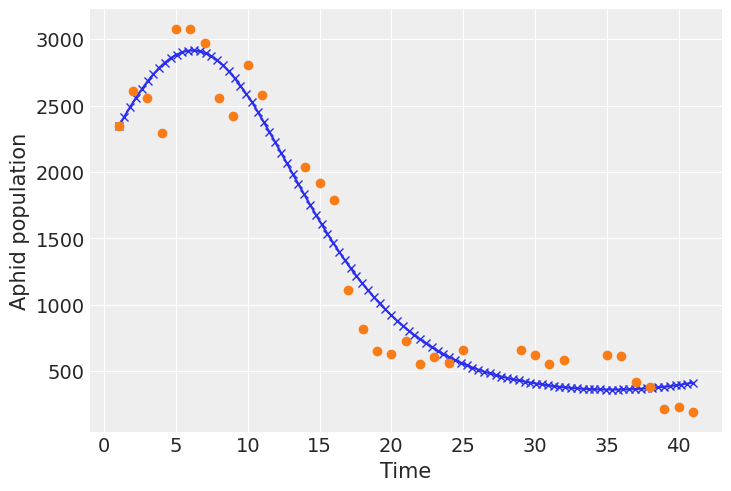

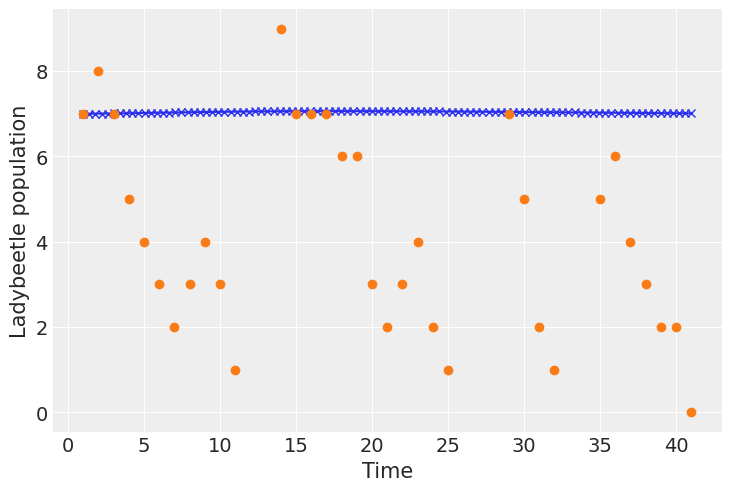

In [14]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_BKMA, u_BKMA, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_BKMA, v_BKMA, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [15]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    p,
    i,
    e1,
    e2,
    e3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$p$",
    r"$i$",
    r"$e1$",
    r"$e2$",
    r"$e3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [16]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = BKMA_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        BKMA_ode_solver,
        y0_BKM
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 32/32 [00:00<00:00, 211.42it/s]


In [17]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$r1$     0.457569
$p$      0.455042
$r2$    0.0651082
$i$     0.0219423
$e2$  0.000221533
$e3$  0.000116719
$e1$  2.77236e-08

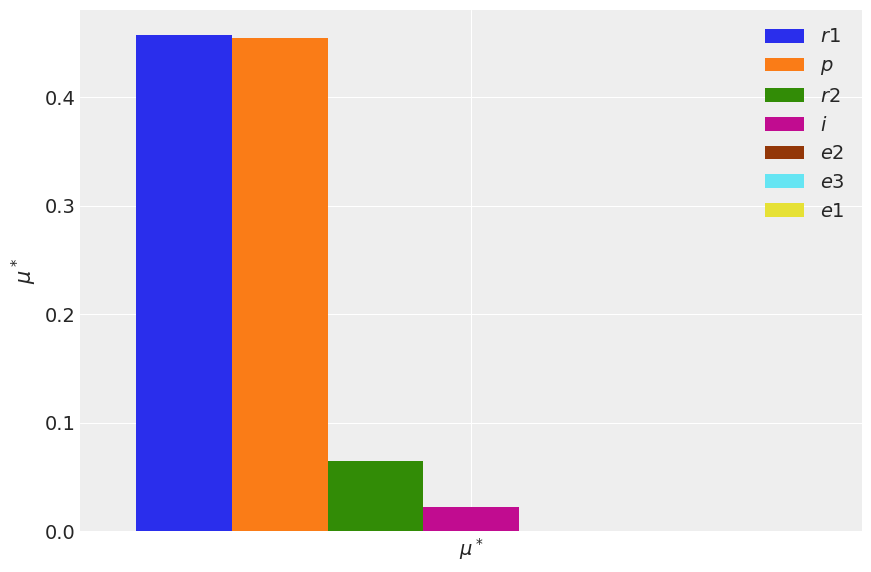

In [18]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares.png", dpi=300)
plt.show()

### Prey (pest) population

In [19]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    p,
    i,
    e1,
    e2,
    e3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$p$",
    r"$i$",
    r"$e1$",
    r"$e2$",
    r"$e3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [20]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_BKMA = BKMA_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_BKMA.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 32/32 [00:00<00:00, 191.53it/s]


In [21]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 112.08it/s]


Time      $r1$         $r2$       $p$          $i$         $e1$  \
0    1.404040  0.504667  9.86735e-08  0.494886  5.29214e-05  2.00355e-09   
1    1.808081  0.500253  3.10487e-07  0.499279  7.67061e-06  4.44172e-09   
2    2.212121   0.50342  0.000268974  0.496077  0.000199684   8.0427e-10   
3    2.616162  0.514126    0.0343947  0.450391   0.00100369  1.47817e-09   
4    3.020202    0.5044    0.0563718  0.433594   0.00481768   7.8468e-09   
..        ...       ...          ...       ...          ...          ...   
94  39.383838  0.409921    0.0846026  0.422092    0.0829291  1.21215e-07   
95  39.787879  0.409607    0.0840082  0.422338    0.0835906  1.22735e-07   
96  40.191919  0.409334    0.0834206   0.42257     0.084218  1.24271e-07   
97  40.595960  0.409106    0.0828403  0.422787    0.0848084  1.25827e-07   
98  41.000000  0.408927    0.0822679  0.422988    0.0853591  1.27403e-07   

           $e2$         $e3$  
0   0.000199136  0.000195227  
1   0.000221525   0.00023798  
2   1.70044e-05  1.77223e-05  
3    5.2714e-05  3.21299e-05  
4   0.000558413  0.000257838  
..          ...          ...  
94  0.000297388  0.000158352  
95  0.000297801  0.000158569  
96  0.000298247  0.000158804  
97  0.000298729  0.000159058  
98  0.000299252  0.000159333  

[99 rows x 8 columns]

In [22]:
df_sigmai

Time      $r1$         $r2$       $p$          $i$         $e1$  \
0    1.404040  0.495109  1.41322e-07  0.504172  4.62612e-05  3.46232e-09   
1    1.808081  0.499514   5.1884e-07  0.499696  1.03208e-05  7.53064e-09   
2    2.212121  0.497178   0.00038832   0.50212   0.00026855  1.12269e-09   
3    2.616162  0.452972    0.0537509  0.492143   0.00104669  1.44688e-09   
4    3.020202  0.431595    0.0802708  0.482033   0.00478482  1.07293e-08   
..        ...       ...          ...       ...          ...          ...   
94  39.383838  0.334862    0.0688872  0.493726     0.101688  1.72215e-07   
95  39.787879  0.335128    0.0682221  0.493875      0.10194  1.73814e-07   
96  40.191919   0.33545    0.0675714  0.494024     0.102121  1.75436e-07   
97  40.595960  0.335833    0.0669358  0.494172     0.102226  1.77084e-07   
98  41.000000  0.336282    0.0663158   0.49432     0.102251  1.78761e-07   

           $e2$         $e3$  
0   0.000331497  0.000340643  
1   0.000375129  0.000403474  
2   2.09552e-05  2.40124e-05  
3   5.79564e-05  2.91478e-05  
4   0.000913874  0.000402597  
..          ...          ...  
94  0.000559351  0.000276355  
95  0.000558389  0.000275874  
96  0.000557518  0.000275437  
97  0.000556745  0.000275049  
98  0.000556076  0.000274712  

[99 rows x 8 columns]

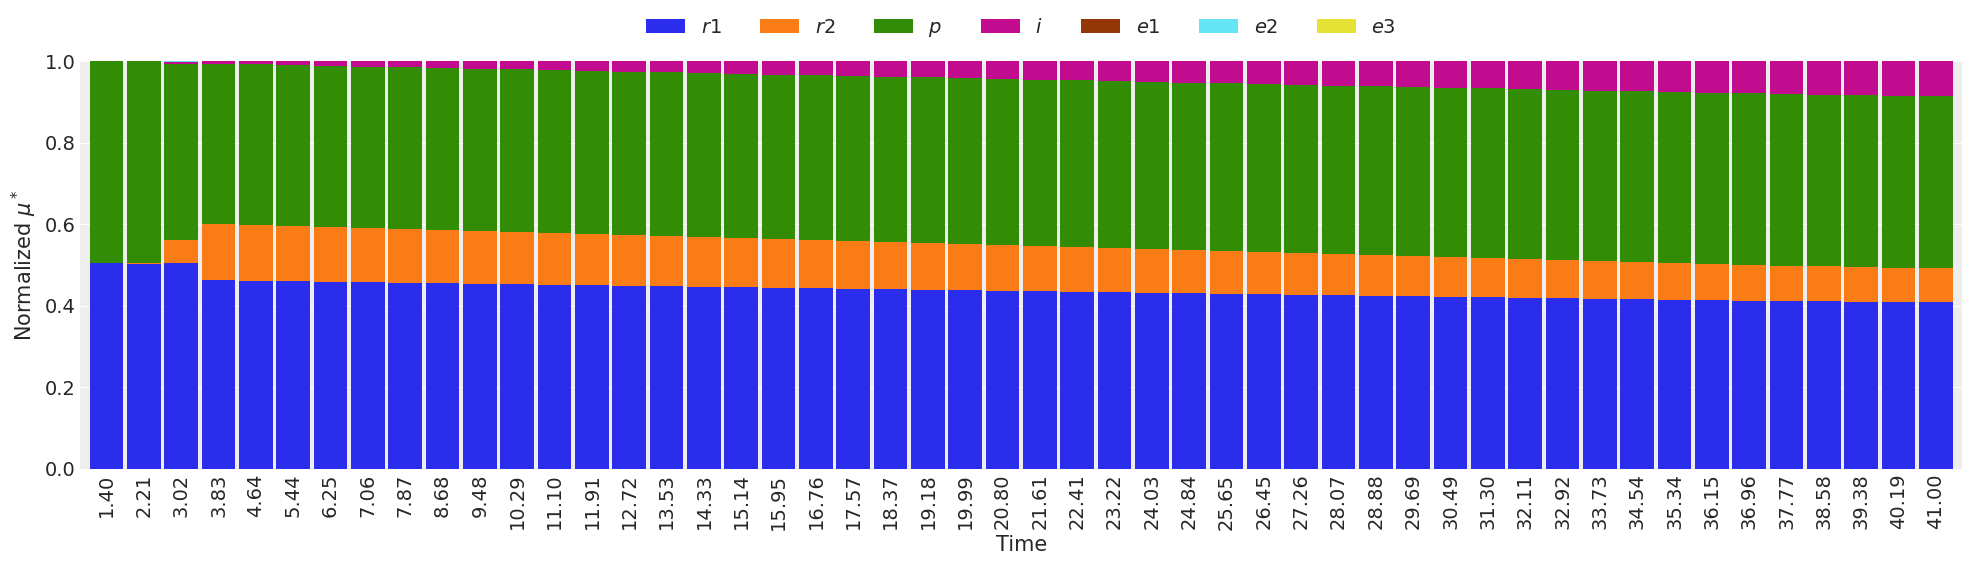

In [23]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop.png", dpi=300)
plt.show()

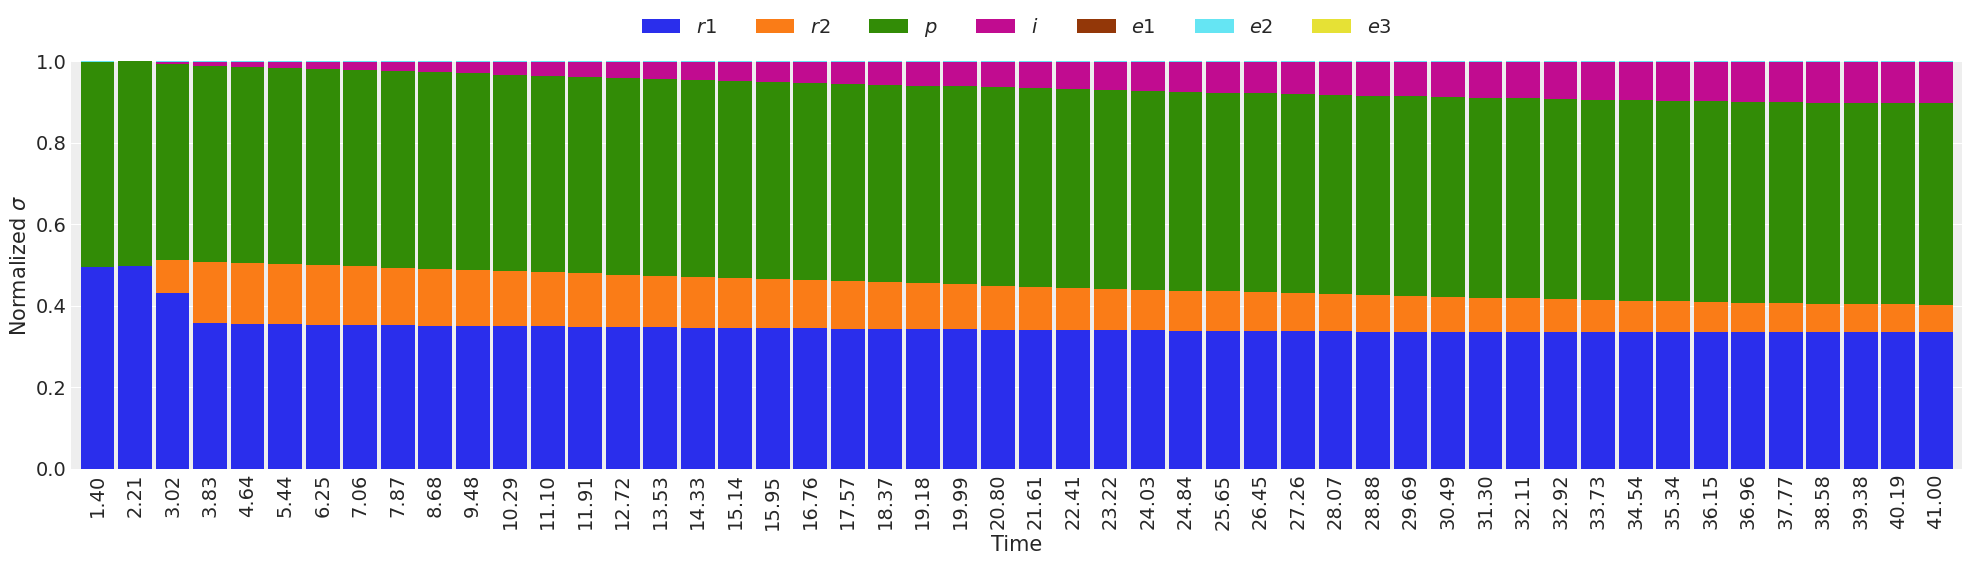

In [24]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [25]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [26]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_BKMA,
    u_BKMA,
    v_BKMA,
    BKMA_model,
    mean_values_params
)

pest_time_derivative_array

array([ 1.91380672e+02,  1.84142874e+02,  1.75960499e+02,  1.66074355e+02,
        1.54504612e+02,  1.41297046e+02,  1.26549529e+02,  1.10251039e+02,
        9.28697328e+01,  7.43297598e+01,  5.48352905e+01,  3.46586810e+01,
        1.40599565e+01, -6.68557407e+00, -2.72916774e+01, -4.75110430e+01,
       -6.71008561e+01, -8.58212899e+01, -1.03444221e+02, -1.19792695e+02,
       -1.34729562e+02, -1.48123818e+02, -1.59869496e+02, -1.69917932e+02,
       -1.78281315e+02, -1.84953051e+02, -1.89987594e+02, -1.93445725e+02,
       -1.95425072e+02, -1.96031584e+02, -1.95409093e+02, -1.93645418e+02,
       -1.90877846e+02, -1.87244126e+02, -1.82884580e+02, -1.77913313e+02,
       -1.72435711e+02, -1.66564068e+02, -1.60405160e+02, -1.54038780e+02,
       -1.47541169e+02, -1.40987685e+02, -1.34520067e+02, -1.27979432e+02,
       -1.21562610e+02, -1.15295180e+02, -1.09198211e+02, -1.03284405e+02,
       -9.75681901e+01, -9.20621275e+01, -8.67751553e+01, -8.17087117e+01,
       -7.68658742e+01, -

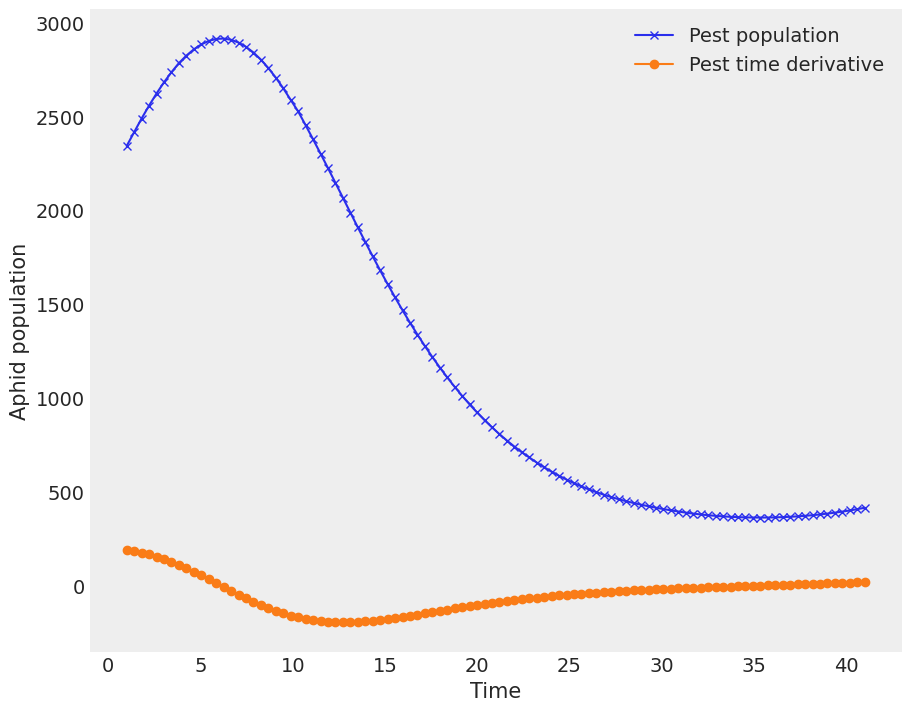

In [27]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_BKMA, u_BKMA, '-x', label='Pest population')
plt.plot(t_computed_BKMA, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative.png", dpi=300)
plt.show()

In [28]:
mean_values_params = [
    r1,
    r2,
    p,
    i,
    e1,
    e2,
    e3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$p$",
    r"$i$",
    r"$e1$",
    r"$e2$",
    r"$e3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [29]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_BKMA = BKMA_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_BKMA.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        BKMA_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 32/32 [00:00<00:00, 176.25it/s]


In [30]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 116.07it/s]


Time      $r1$         $r2$       $p$          $i$         $e1$  \
0    1.404040  0.502678   1.0653e-07  0.496832  3.97023e-05  2.51167e-09   
1    1.808081  0.500195  4.73324e-07  0.499585  6.98845e-06  2.59894e-09   
2    2.212121  0.785684    0.0475593  0.147645     0.018821  6.84155e-09   
3    2.616162  0.430514      0.43105  0.123975    0.0130092  1.62902e-08   
4    3.020202  0.441355      0.09679  0.424926    0.0314476  3.62461e-08   
..        ...       ...          ...       ...          ...          ...   
94  39.383838  0.279006     0.217418  0.339754     0.163791  4.21049e-07   
95  39.787879  0.285912     0.223522  0.333549     0.156996  4.28921e-07   
96  40.191919   0.29403     0.230733  0.326194      0.14903  4.38477e-07   
97  40.595960  0.303819     0.239289  0.317324     0.139561   4.5008e-07   
98  41.000000  0.317673     0.248853  0.305645     0.127807  4.63793e-07   

           $e2$         $e3$  
0   0.000223428  0.000226455  
1   0.000101937  0.000110903  
2   0.000184605  0.000106369  
3    0.00101233   0.00043959  
4    0.00374881   0.00173266  
..          ...          ...  
94  1.85222e-05  1.16752e-05  
95  1.30856e-05   8.1767e-06  
96  7.19112e-06  4.35157e-06  
97  3.91186e-06  1.82374e-06  
98  1.35899e-05  7.70605e-06  

[99 rows x 8 columns]

In [31]:
df_sigmai

Time      $r1$         $r2$        $p$          $i$         $e1$  \
0    1.404040  0.497119  1.60529e-07    0.50207  3.83015e-05  4.34447e-09   
1    1.808081  0.499693  7.52532e-07   0.499955  9.43338e-06   4.1709e-09   
2    2.212121  0.755683    0.0597427   0.161977    0.0222848  6.16258e-09   
3    2.616162  0.388358     0.505713  0.0933397    0.0108728  1.60669e-08   
4    3.020202  0.443294    0.0819053   0.431048    0.0354843  5.29465e-08   
..        ...       ...          ...        ...          ...          ...   
94  39.383838  0.329762      0.14973   0.415913     0.104551  4.64607e-07   
95  39.787879  0.337536     0.153449   0.415454    0.0935307   4.6977e-07   
96  40.191919  0.345811     0.157476   0.414497    0.0822018   4.7528e-07   
97  40.595960  0.354012     0.161559   0.412339    0.0720829  4.80318e-07   
98  41.000000  0.360732     0.165087   0.407558    0.0665957  4.83082e-07   

           $e2$         $e3$  
0   0.000379546  0.000393133  
1   0.000163306  0.000177956  
2   0.000203102  0.000109875  
3     0.0011964  0.000519513  
4    0.00565485   0.00261362  
..          ...          ...  
94  2.69933e-05  1.73207e-05  
95  1.79307e-05  1.16333e-05  
96  7.98878e-06  5.34488e-06  
97  4.59109e-06  2.11351e-06  
98  1.65286e-05  9.59472e-06  

[99 rows x 8 columns]

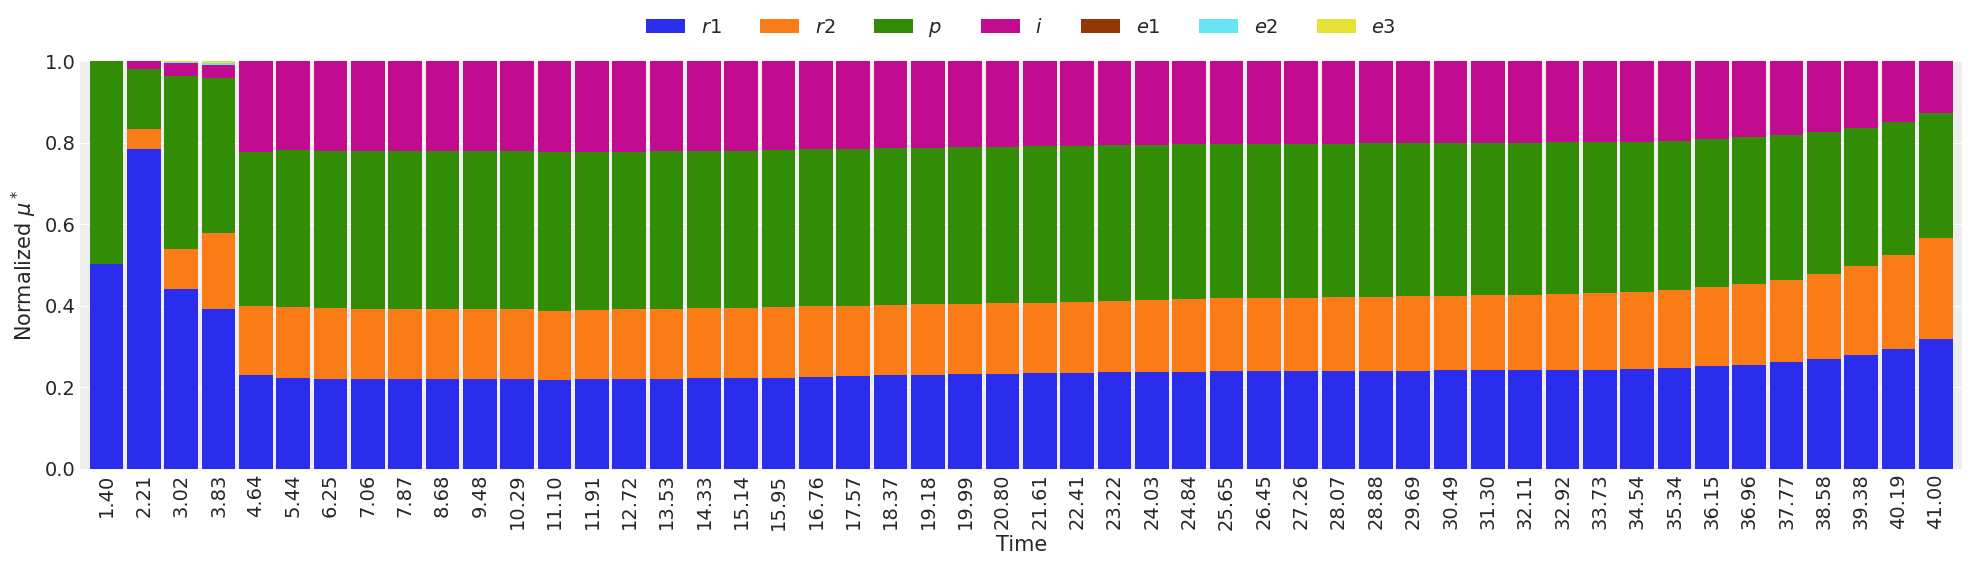

In [32]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative.png", dpi=300)
plt.show()

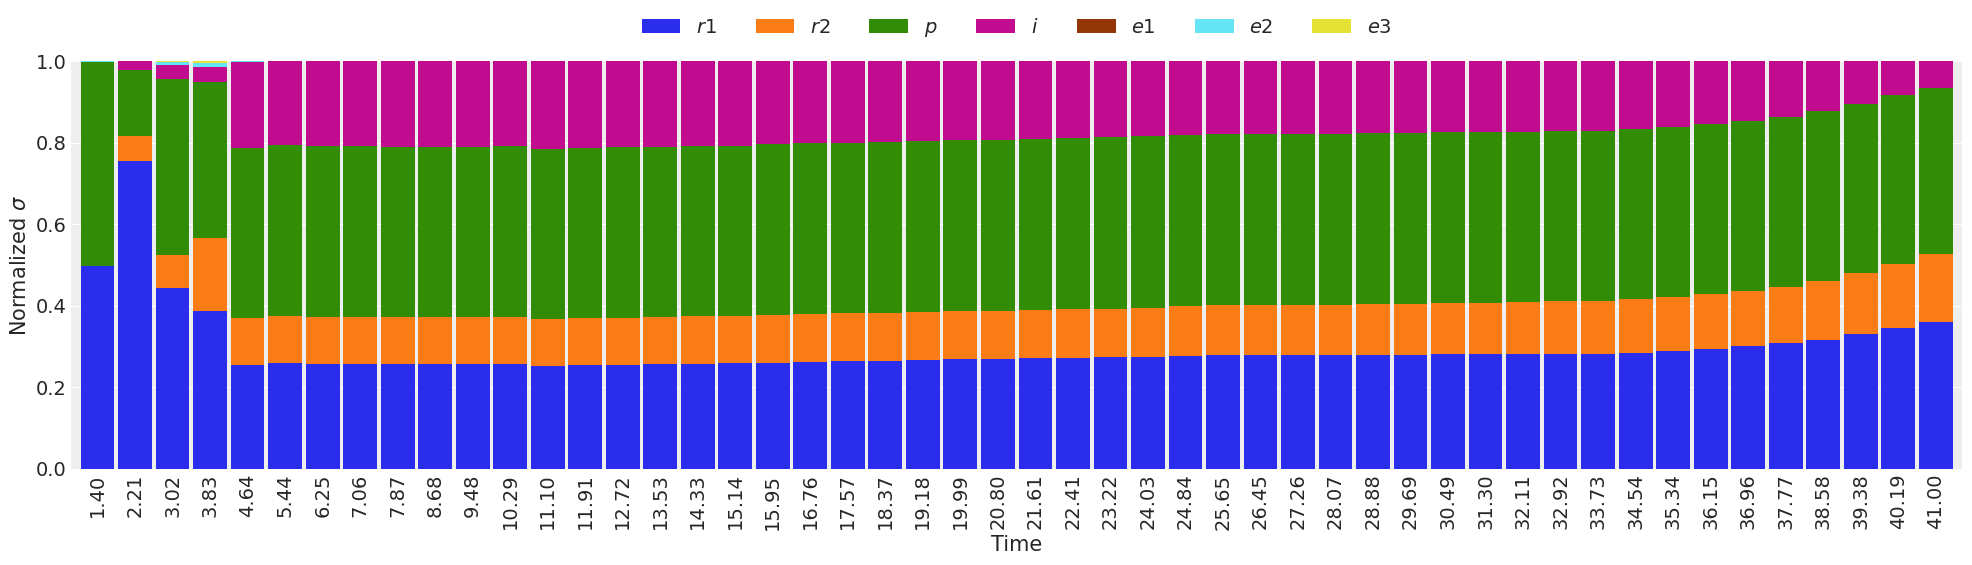

In [33]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative.png", dpi=300)
plt.show()

## Bayesian calibration

In [34]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # r2
        t.dscalar,  # p
        t.dscalar,  # i
        t.dscalar,  # e1
        t.dscalar,  # e2
        t.dscalar,  # e3
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def BKMA_ode_wrapper(time_exp, r1, r2, p, i, e1, e2, e3, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, r2, p, i, e1, e2, e3]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        BKMA_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [35]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_BKMA:
    # Prior distributions for the model's parameters
    r1_range_factor = 1.0
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - r1_range_factor * percent_calibration) * r1,
        upper=(1.0 + r1_range_factor * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#         "r2", 
#         lower=(1.0 - percent_calibration) * r2, 
#         upper=(1.0 + percent_calibration) * r2,
#     )
    r2_ = pm.Data("r2", r2)  # r2 values tend to zero
    p_ = pm.Uniform(
        "p", 
        lower=(1.0 - percent_calibration) * p, 
        upper=(1.0 + percent_calibration) * p,
    )
    i_ = pm.Uniform(
        "i", 
        lower=(1.0 - percent_calibration) * i, 
        upper=(1.0 + percent_calibration) * i,
    )
#     i_ = pm.Data("i", i)
    e1_ = pm.Data("e1", e1)
    e2_ = pm.Data("e2", e2)
    e3_ = pm.Data("e3", e3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=400, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "BKMA_model",
        BKMA_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            p_,
            i_,
            e1_,
            e2_,
            e3_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r1_range_factor = 1.0
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - r1_range_factor * percent_calibration) * r1,
        upper=(1.0 + r1_range_factor * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#         "r2", 
#         lower=(1.0 - percent_calibration) * r2, 
#         upper=(1.0 + percent_calibration) * r2,
#     )
    r2_ = pm.Data("r2", r2)  # r2 values tend to zero
    p_ = pm.Uniform(
        "p", 
        lower=(1.0 - percent_calibration) * p, 
        upper=(1.0 + percent_calibration) * p,
    )
    i_ = pm.Uniform(
        "i", 
        lower=(1.0 - percent_calibration) * i, 
        upper=(1.0 + percent_calibration) * i,
    )
#     i_ = pm.Data("i", i)
    e1_ = pm.Data("e1", e1)
    e2_ = pm.Data("e2", e2)
    e3_ = pm.Data("e3", e3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=400, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "BKMA_model",
        BKMA_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            p_,
            i_,
            e1_,
            e2_,
            e3_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
    r1_range_factor = 1.0
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - r1_range_factor * percent_calibration) * r1,
        upper=(1.0 + r1_range_factor * percent_calibration) * r1,
    )
    r2_ = pm.Uniform(
        "r2", 
        lower=1e-8,
        upper=1e-2,
    )
    p_ = pm.Uniform(
        "p", 
        lower=(1.0 - percent_calibration) * p, 
        upper=(1.0 + percent_calibration) * p,
    )
    i_ = pm.Uniform(
        "i", 
        lower=(1.0 - percent_calibration) * i, 
        upper=(1.0 + percent_calibration) * i,
    )
    e1_ = pm.Data("e1", e1)
    e2_ = pm.Data("e2", e2)
    e3_ = pm.Data("e3", e3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=600, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "BKMA_model",
        BKMA_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            p_,
            i_,
            e1_,
            e2_,
            e3_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_BKMA:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_BKMA = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, i, p, r1]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 514 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 9.560 minutes


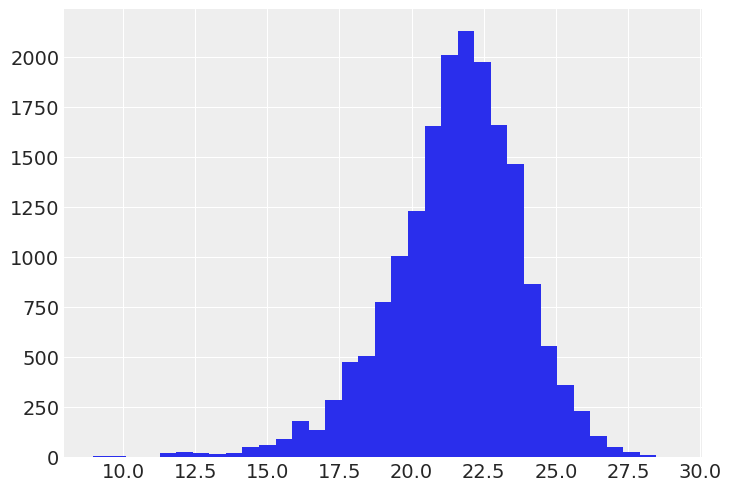

In [36]:
plt.hist(trace_calibration_BKMA['r1'], bins=35)
plt.show()

In [37]:
calibration_variable_names = [
    "std_deviation",
    "r1",
    "p",
    "i",
]

100%|██████████| 4/4 [03:15<00:00, 48.98s/it]


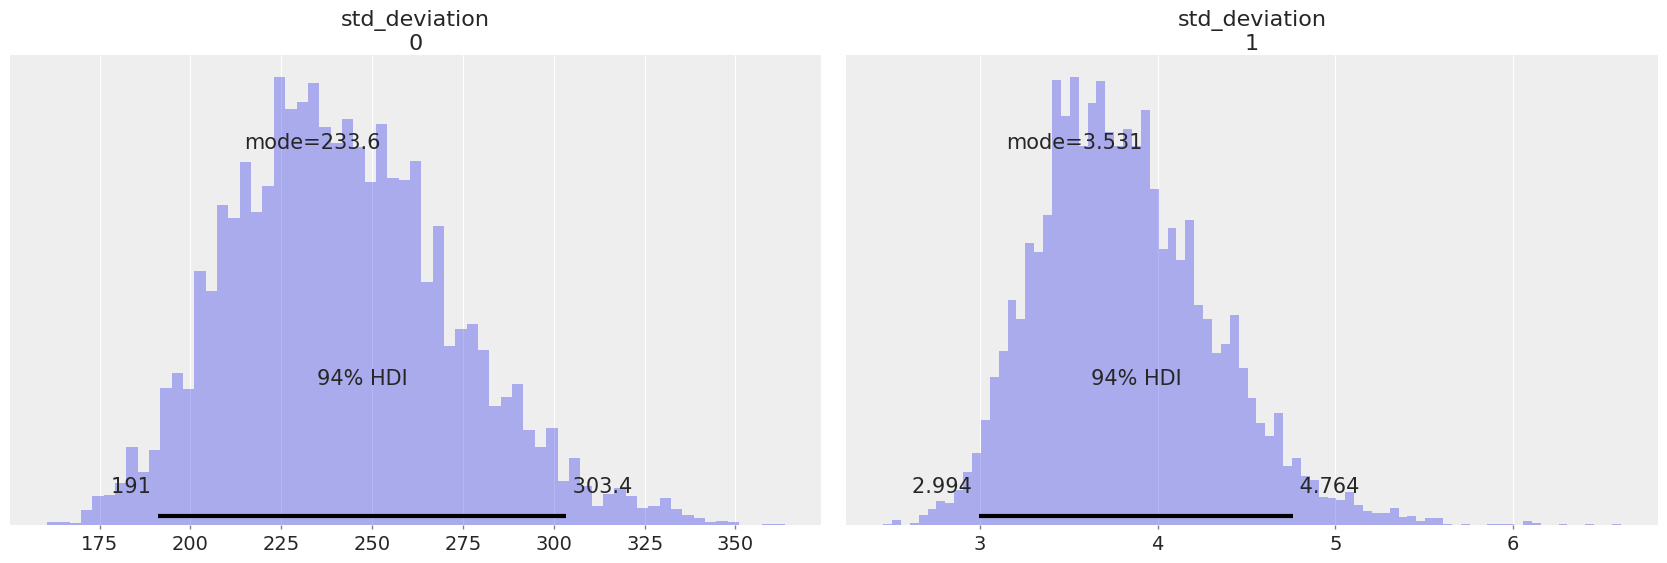

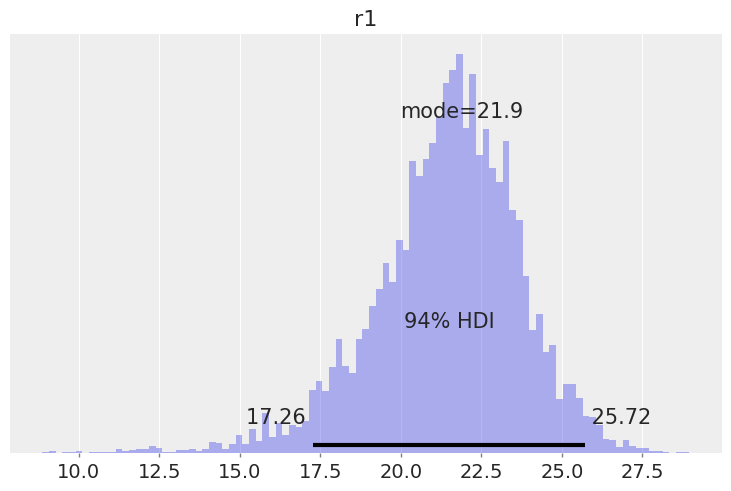

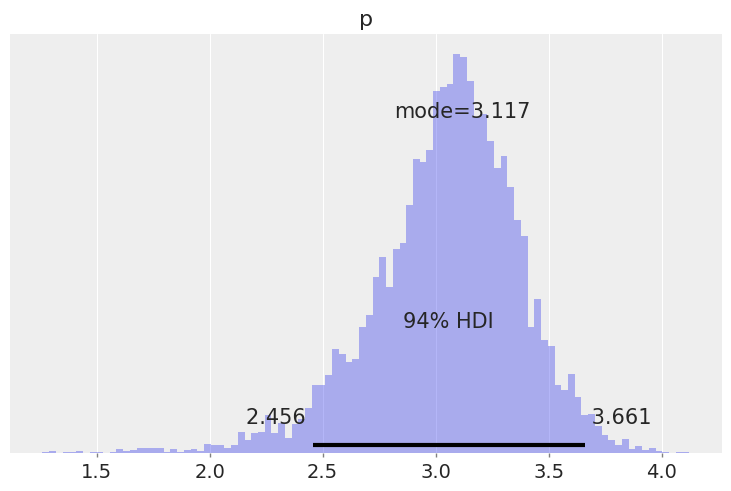

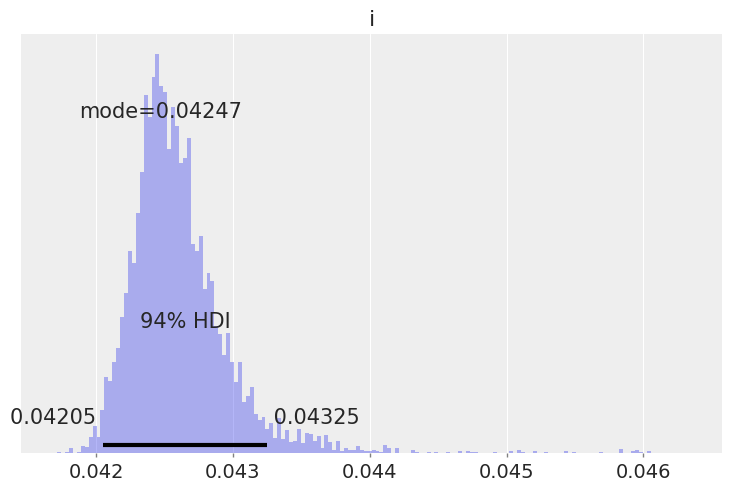

In [38]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_BKMA[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal.png")

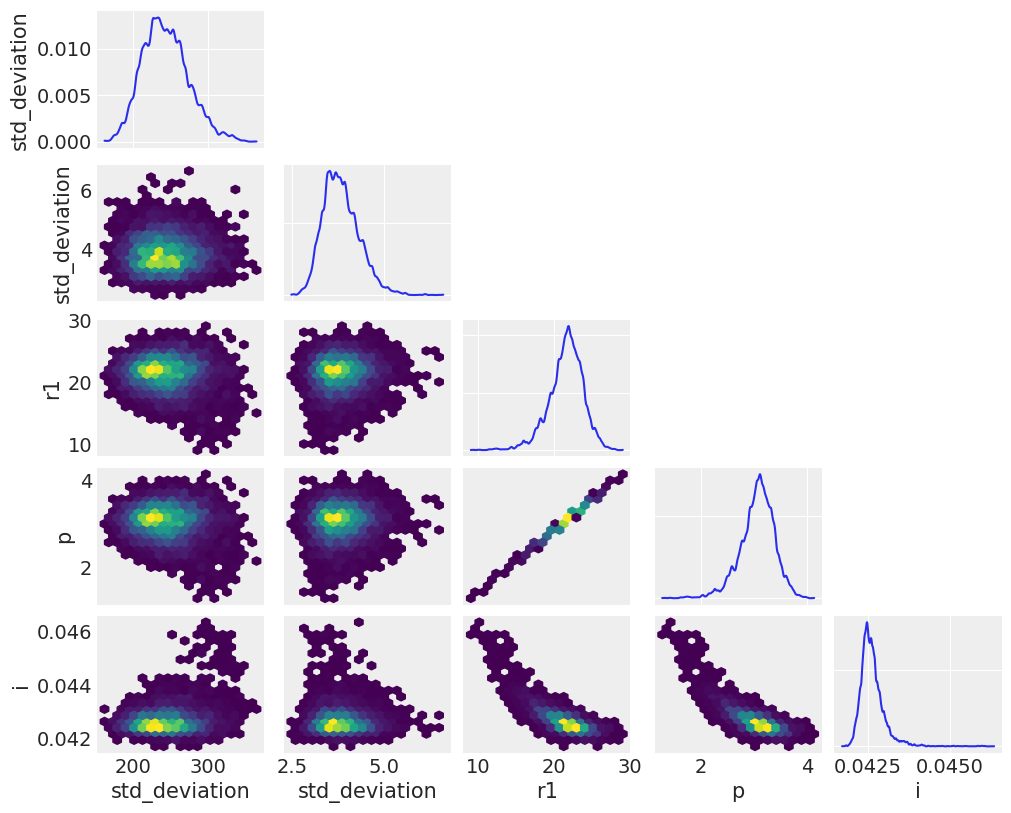

In [39]:
az.plot_pair(
    trace_calibration_BKMA,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal.png")

In [40]:
df_stats_summary = az.summary(
    data=trace_calibration_BKMA,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

mean         sd      hdi_3%     hdi_97%
std_deviation[0]  243.557535  30.518228  190.957915  303.405779
std_deviation[1]    3.844155   0.490182    2.994491    4.763996
r1                 21.519749   2.292183   17.261886   25.717494
p                   3.062753   0.326645    2.455523    3.660833
i                   0.042624   0.000383    0.042048    0.043249

Auxiliary functions to compute the Most Probable Value (MPV):

In [41]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [42]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_BKMA, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("stats_summary_calibration.csv")  # salvando em um csv para consultas

df_stats_summary

Calculating MPV from KDE for i: 100%|██████████| 4/4 [00:30<00:00,  7.53s/it]            


mean         sd      hdi_3%     hdi_97%         mpv
std_deviation[0]  243.557535  30.518228  190.957915  303.405779  231.836744
std_deviation[1]    3.844155   0.490182    2.994491    4.763996    3.554772
r1                 21.519749   2.292183   17.261886   25.717494   21.828167
p                   3.062753   0.326645    2.455523    3.660833    3.106800
i                   0.042624   0.000383    0.042048    0.043249    0.042460

In [43]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_BKMA["BKMA_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_BKMA["BKMA_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_BKMA["BKMA_model"], 50, axis=0)

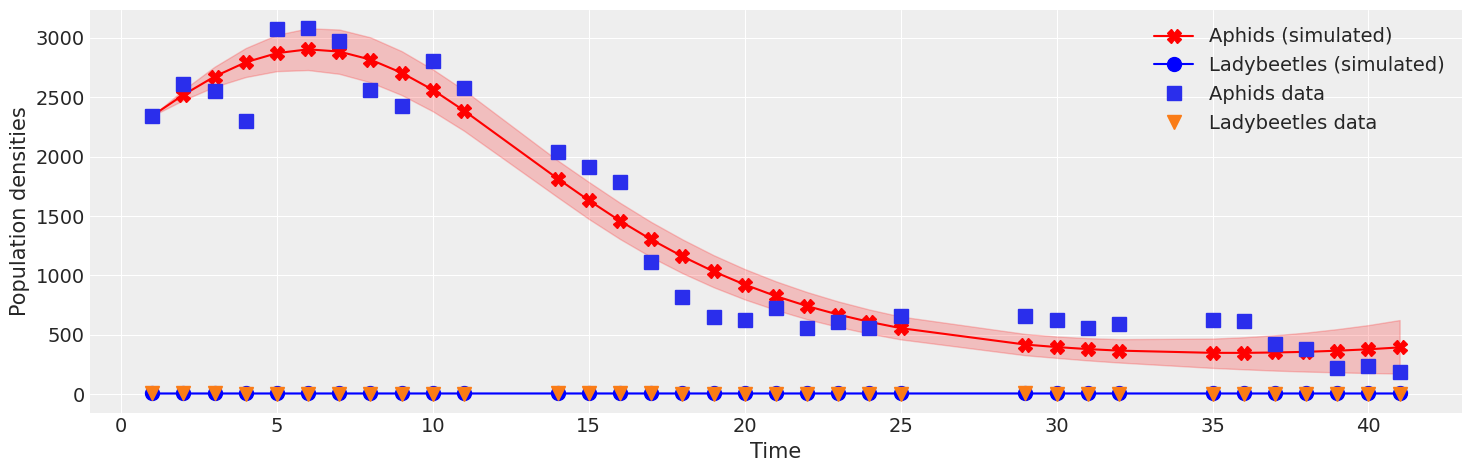

In [44]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration.png", dpi=300)
plt.show()

In [45]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_BKMA.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("calibration_realizations.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering i realizations: 100%|██████████| 3/3 [00:00<00:00, 514.62it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.164 seconds


In [46]:
df_realizations

r1         p         i
0      16.870090  2.400104  0.043339
1      16.870090  2.400104  0.043339
2      17.488349  2.488988  0.043242
3      19.254250  2.738111  0.043175
4      19.254250  2.738111  0.043175
...          ...       ...       ...
17995  18.186306  2.587312  0.043523
17996  18.186306  2.587312  0.043523
17997  18.186306  2.587312  0.043523
17998  18.186306  2.587312  0.043523
17999  19.559059  2.782081  0.043061

[18000 rows x 3 columns]

# Prey-Predator Banks-Kareiva-Murphy C model

In [47]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def BKMC_model(
    t,
    X,
    r1 = 0.24,
    r2 = 0.32e-3,
    p1 = 73.6,
    p2 = 1.52e-4,
    p3 = 7.2,
    i = 9.6,
    e1 = 4.0e-4,
    e2 = 26.0,
    e3 = 0.012,
):
    """
    Prey-Predator Banks-Kareiva-Murphy C model (BKMC) python implementation.
    """
    u, v = X
    u_prime = r1 * u - r2 * u * u - p1 * u * u * v / ( p2 + p3 * u * u )
    v_prime = i - ( e1 + e2 * np.exp( - e3 * u ) ) * v
    return u_prime, v_prime

def BKMC_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 0.24,
    r2 = 0.32e-3,
    p1 = 73.6,
    p2 = 1.52e-4,
    p3 = 7.2,
    i = 9.6,
    e1 = 4.0e-4,
    e2 = 26.0,
    e3 = 0.012,
):
    solution_ODE = solve_ivp(
        fun=BKMC_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1, r2, p1, p2, p3, i, e1, e2, e3),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
t0 = 0
tf = 60
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [48]:
def BKMC_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1e3
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [49]:
from scipy import optimize

r1=0.2701165987355198
r2=5.107493201509652e-05
p1=1.1333676471319685
p2=1.8487114383019472e-05
p3=0.040497240432392556
i=1.1481411994513135
e1=0.016187269931832126
e2=112609.84295081429
e3=0.027710599301664043
denom_min = 0.1
denom_max = 1.9
bounds_BKMC = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),  # r2
    ( ( p1 * denom_min ), ( p1 * denom_max ) ),  # p1
    ( ( p2 * denom_min ), ( p2 * denom_max ) ),  # p2
    ( ( p3 * denom_min ), ( p3 * denom_max ) ),  # p3
    ( ( i * denom_min ), ( i * denom_max ) ),  # i
    ( ( e1 * denom_min ), ( e1 * denom_max ) ),  # e1
    ( ( e2 * denom_min ), ( e2 * denom_max ) ),  # e2
    ( ( e3 * denom_min ), ( e3 * denom_max ) ),  # e3
]

result_BKMC = optimize.differential_evolution(
    BKMC_least_squares_error_ode,
    bounds=bounds_BKMC,
    args=(
        aphid_data.Time.values,
        [u_data, v_data],
        BKMC_ode_solver,
        y0_BKM,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=2000,
    polish=True,
    disp=True,
    seed=seed,
    callback=callback_de,
    workers=-1,
)

print(result_BKMC)

differential_evolution step 1: f(x)= 1.66293e+06
parameters = [3.33238759e-01 6.11277206e-05 1.81142779e+00 3.41956487e-05
 4.13122831e-02 6.56127813e-01 1.13700454e-02 1.32984965e+05
 5.08669209e-02]

differential_evolution step 2: f(x)= 1.66293e+06
parameters = [3.33238759e-01 6.11277206e-05 1.81142779e+00 3.41956487e-05
 4.13122831e-02 6.56127813e-01 1.13700454e-02 1.32984965e+05
 5.08669209e-02]

differential_evolution step 3: f(x)= 1.66293e+06
parameters = [3.33238759e-01 6.11277206e-05 1.81142779e+00 3.41956487e-05
 4.13122831e-02 6.56127813e-01 1.13700454e-02 1.32984965e+05
 5.08669209e-02]

differential_evolution step 4: f(x)= 1.64032e+06
parameters = [2.92061088e-01 5.80294655e-05 2.00604575e+00 1.63503111e-05
 4.97604412e-02 5.21361140e-01 8.96616260e-03 1.59480432e+05
 5.06157070e-02]

differential_evolution step 5: f(x)= 1.42958e+06
parameters = [3.53694051e-01 5.07304252e-05 2.08409997e+00 2.00733758e-05
 3.79789662e-02 6.59277509e-01 7.59458180e-03 1.49224969e+05
 4.01054

differential_evolution step 43: f(x)= 887968
parameters = [2.97034550e-01 2.37906398e-05 1.99097071e+00 1.92188021e-05
 2.92695344e-02 5.57257688e-01 2.89038753e-02 2.11157488e+05
 3.15376662e-02]

differential_evolution step 44: f(x)= 887528
parameters = [3.08668804e-01 2.70497150e-05 2.01745839e+00 1.81990033e-05
 2.92599303e-02 5.68578694e-01 2.99904961e-02 2.13769839e+05
 3.20074353e-02]

differential_evolution step 45: f(x)= 887496
parameters = [3.10365062e-01 2.69144616e-05 2.03337869e+00 1.79388225e-05
 2.92630930e-02 5.72089394e-01 3.00981762e-02 2.13913941e+05
 3.18967274e-02]

differential_evolution step 46: f(x)= 887496
parameters = [3.10365062e-01 2.69144616e-05 2.03337869e+00 1.79388225e-05
 2.92630930e-02 5.72089394e-01 3.00981762e-02 2.13913941e+05
 3.18967274e-02]

differential_evolution step 47: f(x)= 887212
parameters = [3.02041333e-01 2.37560847e-05 2.03726993e+00 1.61683475e-05
 2.90997528e-02 5.55874366e-01 3.04119583e-02 2.07436185e+05
 3.14982717e-02]

differenti

differential_evolution step 85: f(x)= 885503
parameters = [3.08495404e-01 2.70209958e-05 2.02243179e+00 1.55092781e-05
 2.94057012e-02 5.75007311e-01 3.02745605e-02 2.03566425e+05
 3.17571964e-02]

differential_evolution step 86: f(x)= 885503
parameters = [3.08495404e-01 2.70209958e-05 2.02243179e+00 1.55092781e-05
 2.94057012e-02 5.75007311e-01 3.02745605e-02 2.03566425e+05
 3.17571964e-02]

differential_evolution step 87: f(x)= 885503
parameters = [3.08495404e-01 2.70209958e-05 2.02243179e+00 1.55092781e-05
 2.94057012e-02 5.75007311e-01 3.02745605e-02 2.03566425e+05
 3.17571964e-02]

differential_evolution step 88: f(x)= 885503
parameters = [3.08495404e-01 2.70209958e-05 2.02243179e+00 1.55092781e-05
 2.94057012e-02 5.75007311e-01 3.02745605e-02 2.03566425e+05
 3.17571964e-02]

differential_evolution step 89: f(x)= 885503
parameters = [3.08495404e-01 2.70209958e-05 2.02243179e+00 1.55092781e-05
 2.94057012e-02 5.75007311e-01 3.02745605e-02 2.03566425e+05
 3.17571964e-02]

differenti

differential_evolution step 127: f(x)= 885355
parameters = [3.10016868e-01 2.71461305e-05 2.03598811e+00 1.71992434e-05
 2.94275437e-02 5.72789124e-01 3.01844210e-02 2.03799480e+05
 3.18991653e-02]

differential_evolution step 128: f(x)= 885355
parameters = [3.10016868e-01 2.71461305e-05 2.03598811e+00 1.71992434e-05
 2.94275437e-02 5.72789124e-01 3.01844210e-02 2.03799480e+05
 3.18991653e-02]

differential_evolution step 129: f(x)= 885355
parameters = [3.10016868e-01 2.71461305e-05 2.03598811e+00 1.71992434e-05
 2.94275437e-02 5.72789124e-01 3.01844210e-02 2.03799480e+05
 3.18991653e-02]

differential_evolution step 130: f(x)= 885355
parameters = [3.10016868e-01 2.71461305e-05 2.03598811e+00 1.71992434e-05
 2.94275437e-02 5.72789124e-01 3.01844210e-02 2.03799480e+05
 3.18991653e-02]

differential_evolution step 131: f(x)= 885355
parameters = [3.10016868e-01 2.71461305e-05 2.03598811e+00 1.71992434e-05
 2.94275437e-02 5.72789124e-01 3.01844210e-02 2.03799480e+05
 3.18991653e-02]

diffe

differential_evolution step 169: f(x)= 885269
parameters = [3.10250727e-01 2.71950782e-05 2.03614099e+00 1.74881816e-05
 2.94111834e-02 5.72830053e-01 3.02245182e-02 2.04222388e+05
 3.19127364e-02]

differential_evolution step 170: f(x)= 885269
parameters = [3.10250727e-01 2.71950782e-05 2.03614099e+00 1.74881816e-05
 2.94111834e-02 5.72830053e-01 3.02245182e-02 2.04222388e+05
 3.19127364e-02]

differential_evolution step 171: f(x)= 885269
parameters = [3.10250727e-01 2.71950782e-05 2.03614099e+00 1.74881816e-05
 2.94111834e-02 5.72830053e-01 3.02245182e-02 2.04222388e+05
 3.19127364e-02]

differential_evolution step 172: f(x)= 885269
parameters = [3.10250727e-01 2.71950782e-05 2.03614099e+00 1.74881816e-05
 2.94111834e-02 5.72830053e-01 3.02245182e-02 2.04222388e+05
 3.19127364e-02]

differential_evolution step 173: f(x)= 885269
parameters = [3.10250727e-01 2.71950782e-05 2.03614099e+00 1.74881816e-05
 2.94111834e-02 5.72830053e-01 3.02245182e-02 2.04222388e+05
 3.19127364e-02]

diffe

differential_evolution step 211: f(x)= 885141
parameters = [3.10189596e-01 2.71810097e-05 2.03899108e+00 2.08807216e-05
 2.94548245e-02 5.72547554e-01 3.01942236e-02 2.03370046e+05
 3.19139609e-02]

differential_evolution step 212: f(x)= 885141
parameters = [3.10189596e-01 2.71810097e-05 2.03899108e+00 2.08807216e-05
 2.94548245e-02 5.72547554e-01 3.01942236e-02 2.03370046e+05
 3.19139609e-02]

differential_evolution step 213: f(x)= 885141
parameters = [3.10189596e-01 2.71810097e-05 2.03899108e+00 2.08807216e-05
 2.94548245e-02 5.72547554e-01 3.01942236e-02 2.03370046e+05
 3.19139609e-02]

differential_evolution step 214: f(x)= 885141
parameters = [3.10189596e-01 2.71810097e-05 2.03899108e+00 2.08807216e-05
 2.94548245e-02 5.72547554e-01 3.01942236e-02 2.03370046e+05
 3.19139609e-02]

differential_evolution step 215: f(x)= 885141
parameters = [3.10189596e-01 2.71810097e-05 2.03899108e+00 2.08807216e-05
 2.94548245e-02 5.72547554e-01 3.01942236e-02 2.03370046e+05
 3.19139609e-02]

diffe

differential_evolution step 253: f(x)= 885108
parameters = [3.10173883e-01 2.71634476e-05 2.03693991e+00 1.70702038e-05
 2.94235552e-02 5.72994159e-01 3.02329793e-02 2.03364207e+05
 3.18895045e-02]

differential_evolution step 254: f(x)= 885108
parameters = [3.10173883e-01 2.71634476e-05 2.03693991e+00 1.70702038e-05
 2.94235552e-02 5.72994159e-01 3.02329793e-02 2.03364207e+05
 3.18895045e-02]

differential_evolution step 255: f(x)= 885108
parameters = [3.10173883e-01 2.71634476e-05 2.03693991e+00 1.70702038e-05
 2.94235552e-02 5.72994159e-01 3.02329793e-02 2.03364207e+05
 3.18895045e-02]

differential_evolution step 256: f(x)= 885108
parameters = [3.10173883e-01 2.71634476e-05 2.03693991e+00 1.70702038e-05
 2.94235552e-02 5.72994159e-01 3.02329793e-02 2.03364207e+05
 3.18895045e-02]

differential_evolution step 257: f(x)= 885108
parameters = [3.10173883e-01 2.71634476e-05 2.03693991e+00 1.70702038e-05
 2.94235552e-02 5.72994159e-01 3.02329793e-02 2.03364207e+05
 3.18895045e-02]

diffe

differential_evolution step 295: f(x)= 885064
parameters = [3.10116597e-01 2.71393304e-05 2.03522026e+00 1.58939684e-05
 2.93990764e-02 5.73056652e-01 3.02323921e-02 2.03298771e+05
 3.18756983e-02]

differential_evolution step 296: f(x)= 885064
parameters = [3.10116597e-01 2.71393304e-05 2.03522026e+00 1.58939684e-05
 2.93990764e-02 5.73056652e-01 3.02323921e-02 2.03298771e+05
 3.18756983e-02]

differential_evolution step 297: f(x)= 885064
parameters = [3.10116597e-01 2.71393304e-05 2.03522026e+00 1.58939684e-05
 2.93990764e-02 5.73056652e-01 3.02323921e-02 2.03298771e+05
 3.18756983e-02]

differential_evolution step 298: f(x)= 885064
parameters = [3.10116597e-01 2.71393304e-05 2.03522026e+00 1.58939684e-05
 2.93990764e-02 5.73056652e-01 3.02323921e-02 2.03298771e+05
 3.18756983e-02]

differential_evolution step 299: f(x)= 885064
parameters = [3.10116597e-01 2.71393304e-05 2.03522026e+00 1.58939684e-05
 2.93990764e-02 5.73056652e-01 3.02323921e-02 2.03298771e+05
 3.18756983e-02]

diffe

differential_evolution step 337: f(x)= 884998
parameters = [3.10206988e-01 2.71517829e-05 2.03466300e+00 1.16763846e-05
 2.93869907e-02 5.73950211e-01 3.03182435e-02 2.03779726e+05
 3.18455668e-02]

differential_evolution step 338: f(x)= 884992
parameters = [3.10232233e-01 2.71625370e-05 2.03521510e+00 1.14259132e-05
 2.93948467e-02 5.73908233e-01 3.03168373e-02 2.03718914e+05
 3.18500209e-02]

differential_evolution step 339: f(x)= 884992
parameters = [3.10232233e-01 2.71625370e-05 2.03521510e+00 1.14259132e-05
 2.93948467e-02 5.73908233e-01 3.03168373e-02 2.03718914e+05
 3.18500209e-02]

differential_evolution step 340: f(x)= 884987
parameters = [3.10238815e-01 2.71637726e-05 2.03464080e+00 1.09270453e-05
 2.93866562e-02 5.74021092e-01 3.03270278e-02 2.03855758e+05
 3.18472791e-02]

differential_evolution step 341: f(x)= 884987
parameters = [3.10238815e-01 2.71637726e-05 2.03464080e+00 1.09270453e-05
 2.93866562e-02 5.74021092e-01 3.03270278e-02 2.03855758e+05
 3.18472791e-02]

diffe

differential_evolution step 379: f(x)= 884967
parameters = [3.10366714e-01 2.72052636e-05 2.03839317e+00 4.87937644e-06
 2.94385589e-02 5.74430133e-01 3.03767987e-02 2.04000224e+05
 3.18513354e-02]

differential_evolution step 380: f(x)= 884961
parameters = [3.10378279e-01 2.72088052e-05 2.03867281e+00 6.76043358e-06
 2.94424474e-02 5.74476435e-01 3.03816310e-02 2.04094086e+05
 3.18506061e-02]

differential_evolution step 381: f(x)= 884961
parameters = [3.10378279e-01 2.72088052e-05 2.03867281e+00 6.76043358e-06
 2.94424474e-02 5.74476435e-01 3.03816310e-02 2.04094086e+05
 3.18506061e-02]

differential_evolution step 382: f(x)= 884961
parameters = [3.10378279e-01 2.72088052e-05 2.03867281e+00 6.76043358e-06
 2.94424474e-02 5.74476435e-01 3.03816310e-02 2.04094086e+05
 3.18506061e-02]

differential_evolution step 383: f(x)= 884961
parameters = [3.10378279e-01 2.72088052e-05 2.03867281e+00 6.76043358e-06
 2.94424474e-02 5.74476435e-01 3.03816310e-02 2.04094086e+05
 3.18506061e-02]

diffe

differential_evolution step 421: f(x)= 884949
parameters = [3.10398236e-01 2.72173969e-05 2.03943887e+00 7.80993011e-06
 2.94533561e-02 5.74437417e-01 3.03804525e-02 2.04367224e+05
 3.18582469e-02]

differential_evolution step 422: f(x)= 884949
parameters = [3.10398236e-01 2.72173969e-05 2.03943887e+00 7.80993011e-06
 2.94533561e-02 5.74437417e-01 3.03804525e-02 2.04367224e+05
 3.18582469e-02]

differential_evolution step 423: f(x)= 884949
parameters = [3.10398236e-01 2.72173969e-05 2.03943887e+00 7.80993011e-06
 2.94533561e-02 5.74437417e-01 3.03804525e-02 2.04367224e+05
 3.18582469e-02]

differential_evolution step 424: f(x)= 884949
parameters = [3.10398236e-01 2.72173969e-05 2.03943887e+00 7.80993011e-06
 2.94533561e-02 5.74437417e-01 3.03804525e-02 2.04367224e+05
 3.18582469e-02]

differential_evolution step 425: f(x)= 884949
parameters = [3.10398236e-01 2.72173969e-05 2.03943887e+00 7.80993011e-06
 2.94533561e-02 5.74437417e-01 3.03804525e-02 2.04367224e+05
 3.18582469e-02]

diffe

differential_evolution step 463: f(x)= 884928
parameters = [3.10426329e-01 2.72268910e-05 2.03959512e+00 7.00794053e-06
 2.94550351e-02 5.74466326e-01 3.03853786e-02 2.04814144e+05
 3.18632895e-02]

differential_evolution step 464: f(x)= 884928
parameters = [3.10426329e-01 2.72268910e-05 2.03959512e+00 7.00794053e-06
 2.94550351e-02 5.74466326e-01 3.03853786e-02 2.04814144e+05
 3.18632895e-02]

differential_evolution step 465: f(x)= 884928
parameters = [3.10426329e-01 2.72268910e-05 2.03959512e+00 7.00794053e-06
 2.94550351e-02 5.74466326e-01 3.03853786e-02 2.04814144e+05
 3.18632895e-02]

differential_evolution step 466: f(x)= 884928
parameters = [3.10426329e-01 2.72268910e-05 2.03959512e+00 7.00794053e-06
 2.94550351e-02 5.74466326e-01 3.03853786e-02 2.04814144e+05
 3.18632895e-02]

differential_evolution step 467: f(x)= 884928
parameters = [3.10426329e-01 2.72268910e-05 2.03959512e+00 7.00794053e-06
 2.94550351e-02 5.74466326e-01 3.03853786e-02 2.04814144e+05
 3.18632895e-02]

diffe

differential_evolution step 505: f(x)= 884918
parameters = [3.10516521e-01 2.72574324e-05 2.04250567e+00 5.84178355e-06
 2.94956141e-02 5.74692336e-01 3.04146934e-02 2.05085318e+05
 3.18704360e-02]

differential_evolution step 506: f(x)= 884918
parameters = [3.10516521e-01 2.72574324e-05 2.04250567e+00 5.84178355e-06
 2.94956141e-02 5.74692336e-01 3.04146934e-02 2.05085318e+05
 3.18704360e-02]

differential_evolution step 507: f(x)= 884918
parameters = [3.10516521e-01 2.72574324e-05 2.04250567e+00 5.84178355e-06
 2.94956141e-02 5.74692336e-01 3.04146934e-02 2.05085318e+05
 3.18704360e-02]

differential_evolution step 508: f(x)= 884918
parameters = [3.10516521e-01 2.72574324e-05 2.04250567e+00 5.84178355e-06
 2.94956141e-02 5.74692336e-01 3.04146934e-02 2.05085318e+05
 3.18704360e-02]

differential_evolution step 509: f(x)= 884918
parameters = [3.10516521e-01 2.72574324e-05 2.04250567e+00 5.84178355e-06
 2.94956141e-02 5.74692336e-01 3.04146934e-02 2.05085318e+05
 3.18704360e-02]

diffe

differential_evolution step 547: f(x)= 884917
parameters = [3.10532202e-01 2.72632938e-05 2.04316137e+00 5.62488383e-06
 2.95048708e-02 5.74701751e-01 3.04171484e-02 2.05098809e+05
 3.18726799e-02]

differential_evolution step 548: f(x)= 884917
parameters = [3.10532202e-01 2.72632938e-05 2.04316137e+00 5.62488383e-06
 2.95048708e-02 5.74701751e-01 3.04171484e-02 2.05098809e+05
 3.18726799e-02]

differential_evolution step 549: f(x)= 884917
parameters = [3.10532202e-01 2.72632938e-05 2.04316137e+00 5.62488383e-06
 2.95048708e-02 5.74701751e-01 3.04171484e-02 2.05098809e+05
 3.18726799e-02]

differential_evolution step 550: f(x)= 884917
parameters = [3.10532202e-01 2.72632938e-05 2.04316137e+00 5.62488383e-06
 2.95048708e-02 5.74701751e-01 3.04171484e-02 2.05098809e+05
 3.18726799e-02]

differential_evolution step 551: f(x)= 884917
parameters = [3.10532202e-01 2.72632938e-05 2.04316137e+00 5.62488383e-06
 2.95048708e-02 5.74701751e-01 3.04171484e-02 2.05098809e+05
 3.18726799e-02]

diffe

differential_evolution step 589: f(x)= 884916
parameters = [3.10551214e-01 2.72702732e-05 2.04394312e+00 6.00741122e-06
 2.95159721e-02 5.74745565e-01 3.04233422e-02 2.05263073e+05
 3.18764967e-02]

differential_evolution step 590: f(x)= 884916
parameters = [3.10551214e-01 2.72702732e-05 2.04394312e+00 6.00741122e-06
 2.95159721e-02 5.74745565e-01 3.04233422e-02 2.05263073e+05
 3.18764967e-02]

differential_evolution step 591: f(x)= 884916
parameters = [3.10551214e-01 2.72702732e-05 2.04394312e+00 6.10882705e-06
 2.95159721e-02 5.74745565e-01 3.04233422e-02 2.05263073e+05
 3.18764967e-02]

differential_evolution step 592: f(x)= 884916
parameters = [3.10551214e-01 2.72702732e-05 2.04394312e+00 6.10882705e-06
 2.95159721e-02 5.74745565e-01 3.04233422e-02 2.05263073e+05
 3.18764967e-02]

differential_evolution step 593: f(x)= 884916
parameters = [3.10551214e-01 2.72702732e-05 2.04394312e+00 6.10882705e-06
 2.95159721e-02 5.74745565e-01 3.04233422e-02 2.05263073e+05
 3.18764967e-02]

diffe

differential_evolution step 631: f(x)= 884915
parameters = [3.10557677e-01 2.72725478e-05 2.04418048e+00 6.90624175e-06
 2.95193071e-02 5.74758712e-01 3.04251911e-02 2.05292820e+05
 3.18773342e-02]

differential_evolution step 632: f(x)= 884915
parameters = [3.10557677e-01 2.72725478e-05 2.04418048e+00 6.94275145e-06
 2.95193071e-02 5.74758712e-01 3.04251911e-02 2.05292820e+05
 3.18773342e-02]

differential_evolution step 633: f(x)= 884915
parameters = [3.10557677e-01 2.72725478e-05 2.04418048e+00 6.94275145e-06
 2.95193071e-02 5.74758712e-01 3.04251911e-02 2.05292820e+05
 3.18773342e-02]

differential_evolution step 634: f(x)= 884915
parameters = [3.10557677e-01 2.72725478e-05 2.04418048e+00 6.94275145e-06
 2.95193071e-02 5.74758712e-01 3.04251911e-02 2.05292820e+05
 3.18773342e-02]

differential_evolution step 635: f(x)= 884915
parameters = [3.10557677e-01 2.72725478e-05 2.04418048e+00 6.94275145e-06
 2.95193071e-02 5.74758712e-01 3.04251911e-02 2.05292820e+05
 3.18773342e-02]

diffe

* Retrieving the calibrated parameter values:

In [50]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    r2_deterministic,
    p1_deterministic,
    p2_deterministic,
    p3_deterministic,
    i_deterministic,
    e1_deterministic,
    e2_deterministic,
    e3_deterministic,
) = result_BKMC.x

solution_ODE_BKMC = BKMC_ode_solver(
    y0_BKM,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_BKMC.x
)
t_computed_BKMC, y_computed_BKMC = solution_ODE_BKMC.t, solution_ODE_BKMC.y
u_BKMC, v_BKMC = y_computed_BKMC

parameters_dict = {
    "Model": "BKMC",
    u"$r1$": r1_deterministic,
    u"$r2$": r2_deterministic,
    u"$p1$": p1_deterministic,
    u"$p2$": p2_deterministic,
    u"$p3$": p3_deterministic,
    u"$i$": i_deterministic,
    u"$e1$": e1_deterministic,
    u"$e2$": e2_deterministic,
    u"$e3$": e3_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "r2=" + str(r2_deterministic) + "\n" + "p1=" + str(p1_deterministic) + "\n" + "p2=" + str(p2_deterministic) + "\n" + "p3=" + str(p3_deterministic) + "\n" + "i=" + str(i_deterministic) + "\n" + "e1=" + str(e1_deterministic) + "\n" + "e2=" + str(e2_deterministic) + "\n" + "e3=" + str(e3_deterministic))

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=0.31055767660983197
r2=2.7272547755935704e-05
p1=2.0441804847570855
p2=6.942751452815929e-06
p3=0.029519307062815303
i=0.5747587123423964
e1=0.030425191102861866
e2=205292.81974073692
e3=0.031877334159505


#### Simulation

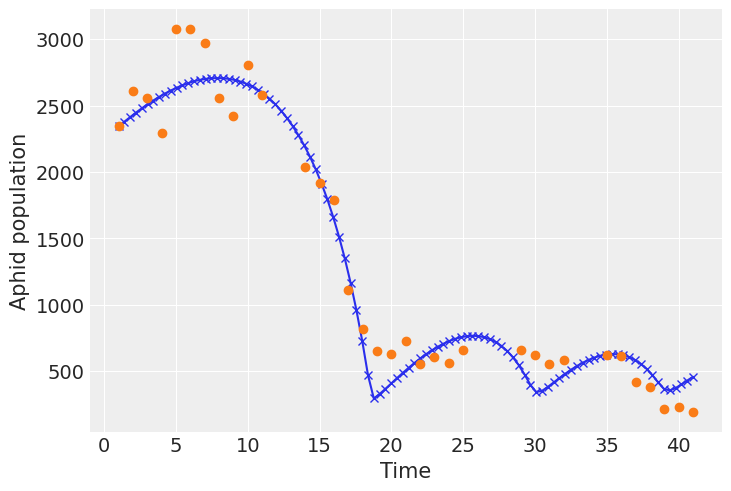

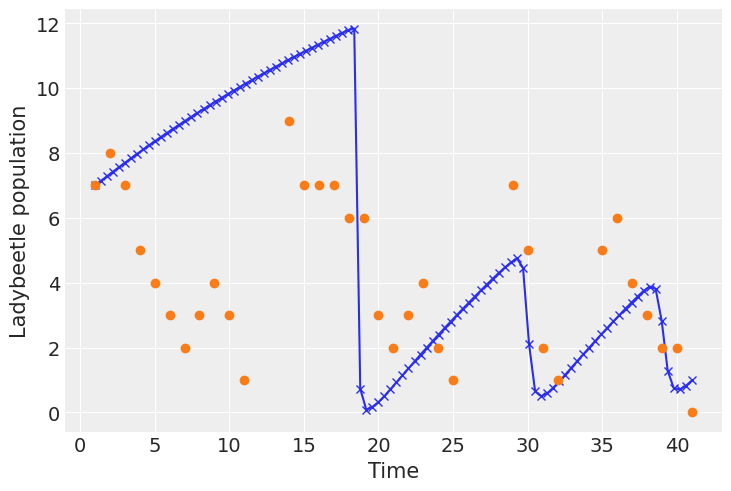

In [51]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_BKMC, u_BKMC, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_BKMC, v_BKMC, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [52]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    p1,
    p2,
    p3,
    i,
    e1,
    e2,
    e3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$p1$",
    r"$p2$",
    r"$p3$",
    r"$i$",
    r"$e1$",
    r"$e2$",
    r"$e3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [53]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = BKMC_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        BKMC_ode_solver,
        y0_BKM
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 40/40 [00:00<00:00, 155.56it/s]


In [54]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$p1$     0.345965
$p3$     0.225239
$r1$     0.152778
$r2$     0.139825
$i$      0.126542
$e1$   0.00605734
$e2$   0.00180901
$e3$    0.0017853
$p2$  7.88506e-12

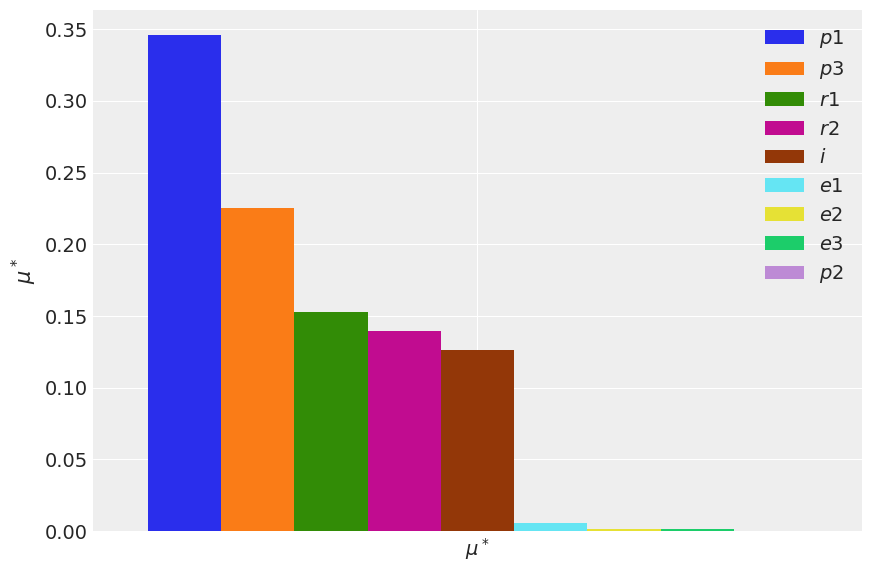

In [55]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares.png", dpi=300)
plt.show()

### Prey (pest) population

In [56]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    p1,
    p2,
    p3,
    i,
    e1,
    e2,
    e3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$p1$",
    r"$p2$",
    r"$p3$",
    r"$i$",
    r"$e1$",
    r"$e2$",
    r"$e3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [57]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_BKMC = BKMC_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_BKMC.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 40/40 [00:00<00:00, 149.15it/s]


In [58]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:01<00:00, 93.55it/s]


Time      $r1$       $r2$      $p1$         $p2$      $p3$  \
0    1.404040  0.434411    0.19066  0.167813  7.73878e-12  0.202415   
1    1.808081  0.428301    0.18744  0.169954   7.7922e-12  0.204874   
2    2.212121  0.422203   0.184088  0.172262  7.85559e-12  0.207605   
3    2.616162  0.416309   0.180836  0.174555  7.91744e-12  0.210313   
4    3.020202   0.41041   0.177872  0.176783  7.97053e-12  0.213051   
..        ...       ...        ...       ...          ...       ...   
94  39.383838  0.225594   0.072018  0.259149  2.00108e-10  0.171868   
95  39.787879   0.23267  0.0617915  0.251575   2.1383e-10  0.169741   
96  40.191919  0.239593  0.0501448  0.244848  1.89041e-10  0.167362   
97  40.595960  0.246308  0.0368122  0.238644   1.4296e-10  0.164934   
98  41.000000  0.252131  0.0215635  0.231513  7.58006e-11  0.165252   

           $i$         $e1$         $e2$         $e3$  
0   0.00426223  0.000438012  7.91039e-11  2.31442e-11  
1   0.00852889  0.000901756  1.18492e-09   1.7541e-10  
2    0.0124802   0.00136203  2.56555e-09  4.43966e-10  
3    0.0161914   0.00179568  3.95795e-09  7.30439e-10  
4    0.0196772   0.00220816  5.52237e-09  1.01425e-09  
..         ...          ...          ...          ...  
94    0.193264     0.013017    0.0171073    0.0479836  
95    0.205966    0.0128714    0.0183189    0.0470653  
96    0.219953    0.0125765    0.0196208    0.0459027  
97    0.235473    0.0121538    0.0210239    0.0446515  
98    0.252016     0.011578      0.02246    0.0434862  

[99 rows x 10 columns]

In [59]:
df_sigmai

Time      $r1$       $r2$      $p1$         $p2$      $p3$  \
0    1.404040  0.123794   0.102332  0.327387  1.46622e-11  0.428733   
1    1.808081  0.162873   0.142055  0.303313  1.40942e-11  0.382228   
2    2.212121  0.196515   0.174812  0.282011  1.36049e-11  0.338974   
3    2.616162  0.222285   0.199646  0.265624  1.32645e-11  0.305156   
4    3.020202  0.240167    0.21871  0.252842  1.30431e-11  0.280902   
..        ...       ...        ...       ...          ...       ...   
94  39.383838  0.181479  0.0889172  0.224982  2.12066e-10   0.21639   
95  39.787879  0.183333  0.0756123  0.222599  2.31473e-10  0.214979   
96  40.191919  0.185482  0.0606852  0.220444  2.20705e-10  0.213429   
97  40.595960  0.187894   0.043844  0.218579  1.66416e-10  0.211673   
98  41.000000  0.190528  0.0246838  0.217142  6.41196e-11  0.209645   

           $i$         $e1$         $e2$         $e3$  
0    0.0166393   0.00111401  8.79823e-10  3.00113e-10  
1   0.00909499  0.000436249   1.3817e-08  1.90181e-09  
2   0.00725772  0.000430455  2.66769e-08  4.34738e-09  
3    0.0067519  0.000536318  3.69597e-08  6.45398e-09  
4    0.0067352   0.00064345  4.46325e-08  8.18253e-09  
..         ...          ...          ...          ...  
94    0.234702    0.0173112    0.0143892    0.0218296  
95      0.2495    0.0170234    0.0156046      0.02135  
96    0.265612    0.0165257    0.0168715    0.0209511  
97    0.283252    0.0158511    0.0181822     0.020725  
98    0.302755    0.0150259    0.0195457    0.0206747  

[99 rows x 10 columns]

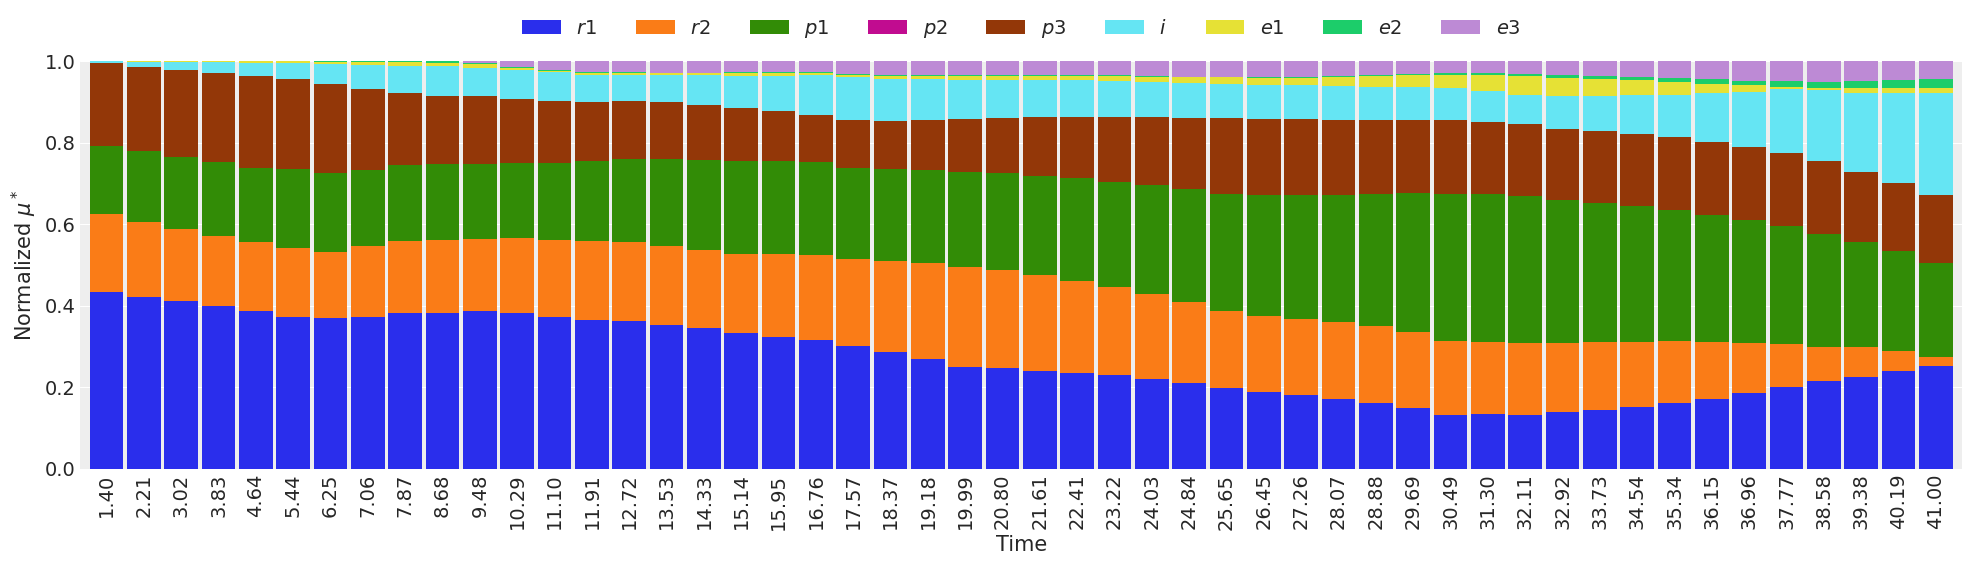

In [60]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop.png", dpi=300)
plt.show()

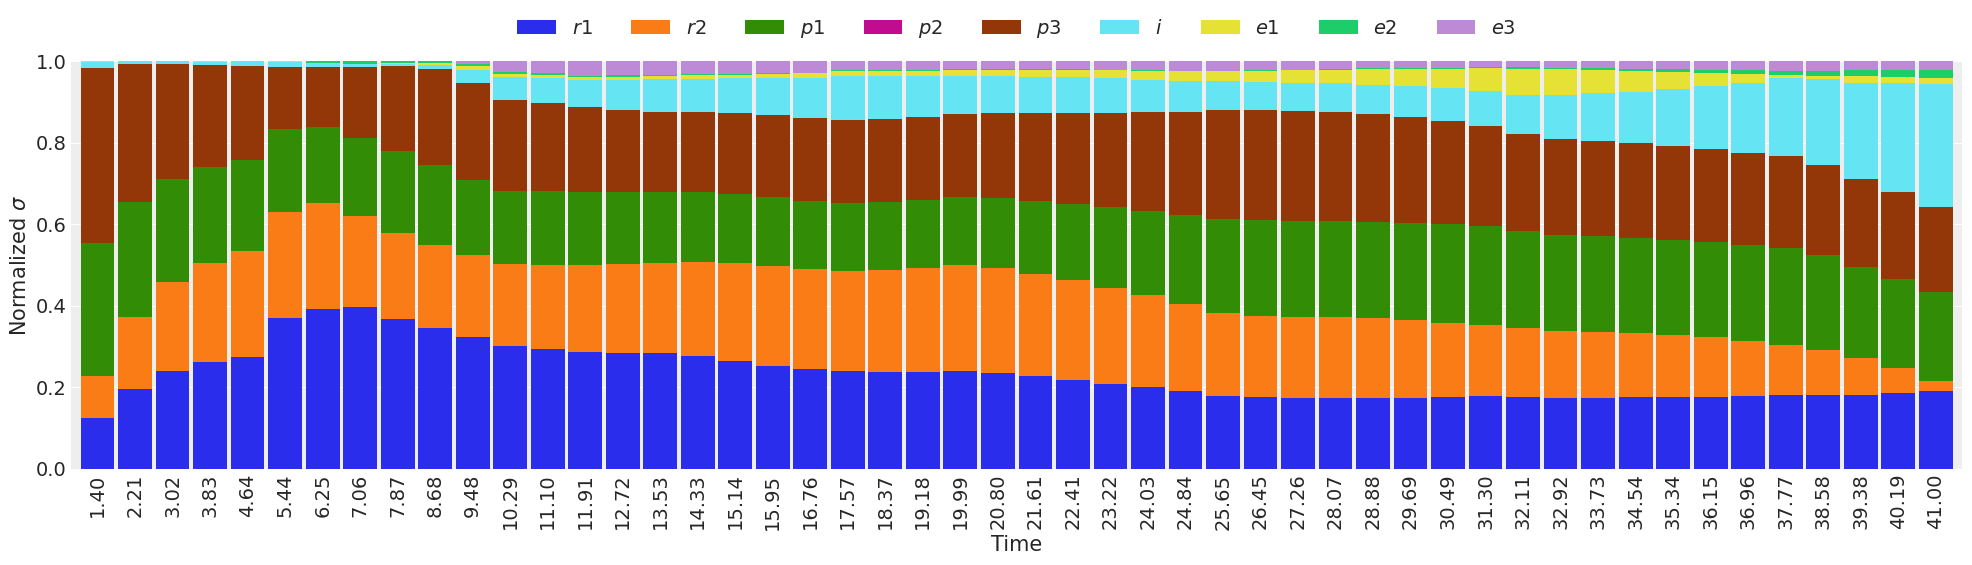

In [61]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [62]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [63]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_BKMC,
    u_BKMC,
    v_BKMC,
    BKMC_model,
    mean_values_params
)

pest_time_derivative_array

array([ 156.59568854,  153.60724724,  150.50283158,  147.27995985,
        143.95791217,  140.55225309,  137.07959812,  133.55559577,
        129.99438205,  126.40679128,  122.80786253,  119.21209321,
        115.63237063,  112.07989235,  108.56471067,  105.09821602,
        101.68633787,   98.33318276,   95.04117774,   91.81062572,
         88.63708068,   85.51131267,   82.41846033,   79.33710343,
         76.23828334,   73.08414113,   69.82341626,   66.38971355,
         62.70027242,   58.65371931,   54.12772662,   48.97654325,
         43.02517577,   36.01909486,   27.65215276,   17.56265026,
          5.31680076,   -9.67407912,  -28.18159294,  -51.10421702,
        -79.58394996, -115.26406438, -160.09905531, -215.61324689,
         55.07898321,   81.07329572,   87.84996728,   93.06398772,
         96.96571169,   99.91359374,  102.17297833,  103.87187757,
        105.03209602,  105.66555526,  105.72985857,  105.21996124,
        104.10554957,  102.35202798,   99.91579773,   96.74464

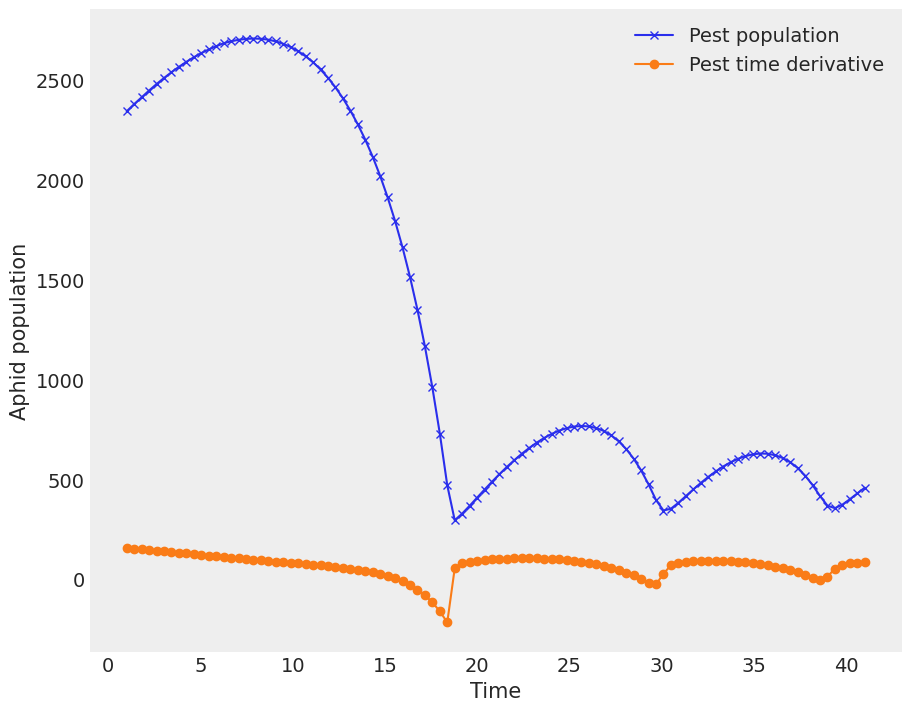

In [64]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_BKMC, u_BKMC, '-x', label='Pest population')
plt.plot(t_computed_BKMC, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative.png", dpi=300)
plt.show()

In [65]:
mean_values_params = [
    r1,
    r2,
    p1,
    p2,
    p3,
    i,
    e1,
    e2,
    e3,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$p1$",
    r"$p2$",
    r"$p3$",
    r"$i$",
    r"$e1$",
    r"$e2$",
    r"$e3$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [66]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_BKMC = BKMC_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_BKMC.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        BKMC_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 40/40 [00:00<00:00, 107.56it/s]


In [67]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:01<00:00, 93.14it/s]


Time      $r1$      $r2$      $p1$         $p2$       $p3$  \
0    1.404040  0.428758    0.1878  0.169795  7.73255e-12     0.2041   
1    1.808081   0.41675   0.18116  0.174933  7.71121e-12   0.209041   
2    2.212121  0.405256  0.175277  0.179509  7.73121e-12   0.214066   
3    2.616162  0.394339  0.169988  0.183454  7.80053e-12   0.219264   
4    3.020202  0.384031  0.165159  0.186705  7.92876e-12   0.224725   
..        ...       ...       ...       ...          ...        ...   
94  39.383838    0.1689  0.228704  0.242969  1.50101e-09  0.0978683   
95  39.787879  0.163279  0.237294  0.228617  6.85724e-10  0.0959962   
96  40.191919  0.157039  0.247105  0.215656  1.21807e-09  0.0923375   
97  40.595960   0.14942  0.261409  0.204075  1.57126e-09  0.0849811   
98  41.000000  0.140076   0.28352  0.193989  1.54644e-09  0.0718533   

           $i$         $e1$         $e2$         $e3$  
0   0.00866254  0.000883678  4.66488e-11  4.04631e-11  
1    0.0164181   0.00169782  9.62053e-10   1.6601e-10  
2    0.0234229   0.00246905  3.01239e-09  4.75719e-10  
3    0.0297504   0.00320413  6.05608e-09  9.48408e-10  
4    0.0354708    0.0039097  1.04325e-08  1.56542e-09  
..         ...          ...          ...          ...  
94    0.203799    0.0050976    0.0201908    0.0324716  
95    0.210972   0.00846401    0.0199437    0.0354338  
96    0.221322    0.0102447    0.0201459    0.0361502  
97    0.235279    0.0116095    0.0203993     0.032826  
98    0.253783     0.012659     0.020732    0.0233875  

[99 rows x 10 columns]

In [68]:
df_sigmai

Time      $r1$      $r2$      $p1$         $p2$       $p3$  \
0    1.404040  0.156241  0.136921  0.310517  1.40273e-11   0.394301   
1    1.808081  0.223443  0.198682  0.267824  1.22854e-11    0.30557   
2    2.212121  0.257496  0.232689   0.24432  1.16006e-11   0.258374   
3    2.616162  0.275883  0.253889  0.229464  1.15072e-11   0.231167   
4    3.020202  0.285715  0.268461  0.219049  1.18242e-11   0.214987   
..        ...       ...       ...       ...          ...        ...   
94  39.383838  0.163418  0.261226  0.207862  1.08831e-09  0.0773042   
95  39.787879   0.15562  0.267144  0.197937  6.70774e-10  0.0718951   
96  40.191919  0.148216  0.275268  0.188311  1.18635e-09  0.0667896   
97  40.595960  0.140487  0.287805  0.178827  1.55672e-09  0.0607946   
98  41.000000   0.13158  0.307269  0.169355  1.51656e-09  0.0538689   

           $i$         $e1$         $e2$         $e3$  
0   0.00193842  8.12906e-05  3.60116e-10  5.00059e-10  
1   0.00435714  0.000125077  8.58211e-09  1.50266e-09  
2   0.00692346  0.000198293  2.28502e-08  3.55827e-09  
3   0.00931956  0.000277867  4.01672e-08  6.15977e-09  
4    0.0114179  0.000369619  5.88097e-08  9.12898e-09  
..         ...          ...          ...          ...  
94     0.22692   0.00580719      0.02013    0.0373333  
95    0.237472    0.0101374    0.0198621    0.0399328  
96    0.250028    0.0120852     0.019622    0.0396801  
97    0.264815    0.0134435       0.0194    0.0344275  
98    0.282125    0.0143318    0.0191854    0.0222848  

[99 rows x 10 columns]

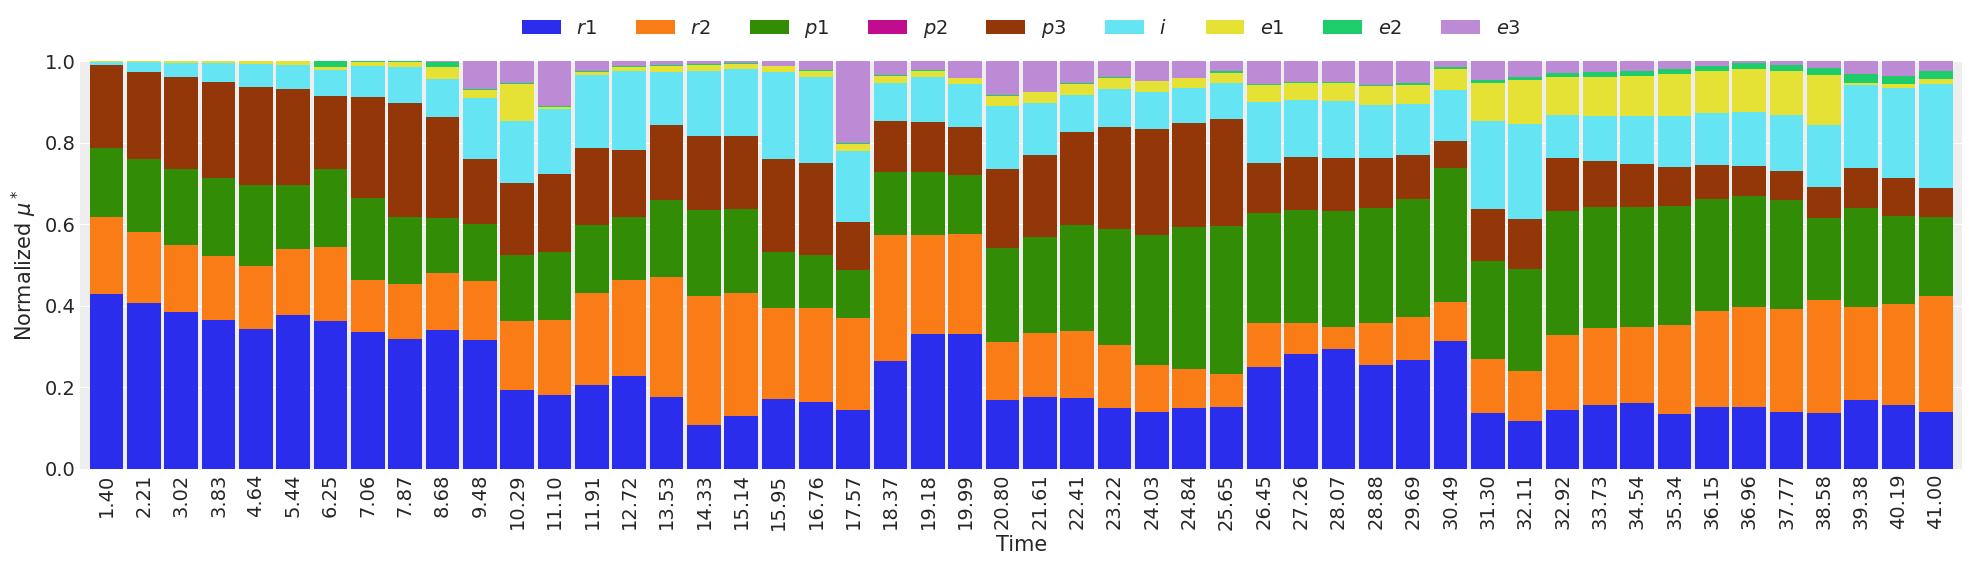

In [69]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative.png", dpi=300)
plt.show()

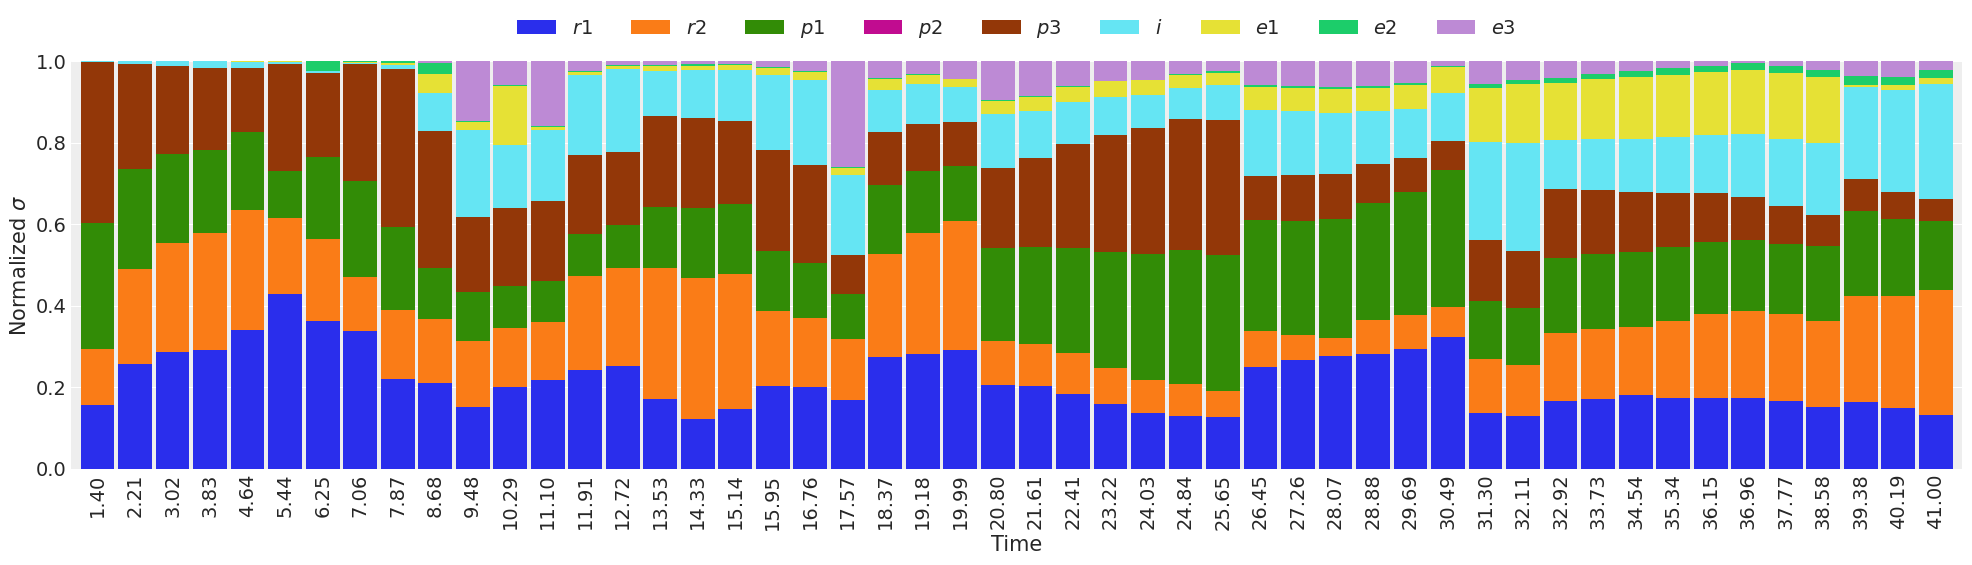

In [70]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative.png", dpi=300)
plt.show()

## Bayesian calibration

In [71]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # r2
        t.dscalar,  # p1
        t.dscalar,  # p2
        t.dscalar,  # p3
        t.dscalar,  # i
        t.dscalar,  # e1
        t.dscalar,  # e2
        t.dscalar,  # e3
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def BKMC_ode_wrapper(time_exp, r1, r2, p1, p2, p3, i, e1, e2, e3, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, r2, p1, p2, p3, i, e1, e2, e3]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        BKMC_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [72]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_BKMC:
    # Prior distributions for the model's parameters
    r1_range_factor = 1.0
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - r1_range_factor * percent_calibration) * r1,
        upper=(1.0 + r1_range_factor * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#         "r2", 
#         lower=(1.0 - percent_calibration) * r2, 
#         upper=(1.0 + percent_calibration) * r2,
#     )
    r2_ = pm.Data("r2", r2)  # r2 values tend to zero
    p1_ = pm.Uniform(
        "p1", 
        lower=(1.0 - percent_calibration) * p1,
        upper=(1.0 + percent_calibration) * p1,
    )
#    p2 = pm.Uniform(
#        "p2, 
#        lower=(1.0 - percent_calibration) * p2,
#        upper=(1.0 + percent_calibration) * p2,
#    )
    p2_ = pm.Data("p2", p2)
#    p3_ = pm.Uniform(
#        "p3", 
#        lower=(1.0 - percent_calibration) * p3,
#        upper=(1.0 + percent_calibration) * p3,
#    )
    p3_ = pm.Data("p3", p3)
    i_ = pm.Uniform(
        "i", 
        lower=(1.0 - percent_calibration) * i,
        upper=(1.0 + percent_calibration) * i,
    )
#     i_ = pm.Data("i", i)
    e1_ = pm.Data("e1", e1)
    e2_ = pm.Data("e2", e2)
    e3_ = pm.Data("e3", e3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=400, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "BKMC_model",
        BKMC_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            p1_,
            p2_,
            p3_,
            i_,
            e1_,
            e2_,
            e3_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r1_range_factor = 1.0
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - r1_range_factor * percent_calibration) * r1,
        upper=(1.0 + r1_range_factor * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#         "r2", 
#         lower=(1.0 - percent_calibration) * r2, 
#         upper=(1.0 + percent_calibration) * r2,
#     )
    r2_ = pm.Data("r2", r2)  # r2 values tend to zero
    p1_ = pm.Uniform(
        "p1", 
        lower=(1.0 - percent_calibration) * p1, 
        upper=(1.0 + percent_calibration) * p1,
    )
#    p2 = pm.Uniform(
#        "p2, 
#        lower=(1.0 - percent_calibration) * p2,
#        upper=(1.0 + percent_calibration) * p2,
#    )
    p2_ = pm.Data("p2", p2)
#    p3_ = pm.Uniform(
#        "p3", 
#        lower=(1.0 - percent_calibration) * p3,
#        upper=(1.0 + percent_calibration) * p3,
#    )
    p3_ = pm.Data("p3", p3)
    i_ = pm.Uniform(
        "i", 
        lower=(1.0 - percent_calibration) * i, 
        upper=(1.0 + percent_calibration) * i,
    )
#     i_ = pm.Data("i", i)
    e1_ = pm.Data("e1", e1)
    e2_ = pm.Data("e2", e2)
    e3_ = pm.Data("e3", e3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=400, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "BKMC_model",
        BKMC_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            p1_,
            p2_,
            p3_,
            i_,
            e1_,
            e2_,
            e3_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
    r1_range_factor = 1.0
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - r1_range_factor * percent_calibration) * r1,
        upper=(1.0 + r1_range_factor * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#        "r2", 
#        lower=1e-8,
#        upper=1e-2
#    )
    r2_ = pm.Data("r2", r2)
    p1_ = pm.Uniform(
        "p1", 
        lower=(1.0 - percent_calibration) * p1, 
        upper=(1.0 + percent_calibration) * p1,
    )
#    p2 = pm.Uniform(
#        "p2, 
#        lower=(1.0 - percent_calibration) * p2,
#        upper=(1.0 + percent_calibration) * p2,
#    )
    p2_ = pm.Data("p2", p2)
#    p3_ = pm.Uniform(
#        "p3", 
#        lower=(1.0 - percent_calibration) * p3,
#        upper=(1.0 + percent_calibration) * p3,
#    )
    p3_ = pm.Data("p3", p3)
    i_ = pm.Uniform(
        "i", 
        lower=(1.0 - percent_calibration) * i, 
        upper=(1.0 + percent_calibration) * i,
    )
    e1_ = pm.Data("e1", e1)
    e2_ = pm.Data("e2", e2)
    e3_ = pm.Data("e3", e3)
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=600, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "BKMC_model",
        BKMC_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            p1_,
            p2_,
            p3_,
            i_,
            e1_,
            e2_,
            e3_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_BKMC:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_BKMC = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, i, p1, r1]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 1729 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 31.342 minutes


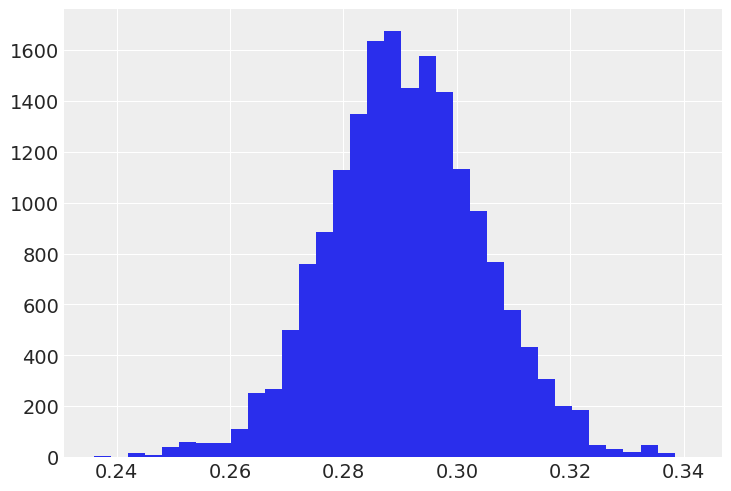

In [73]:
plt.hist(trace_calibration_BKMC['r1'], bins=35)
plt.show()

In [74]:
calibration_variable_names = [
    "std_deviation",
    "r1",
    "p1",
    "i"
]

100%|██████████| 4/4 [09:12<00:00, 138.11s/it]


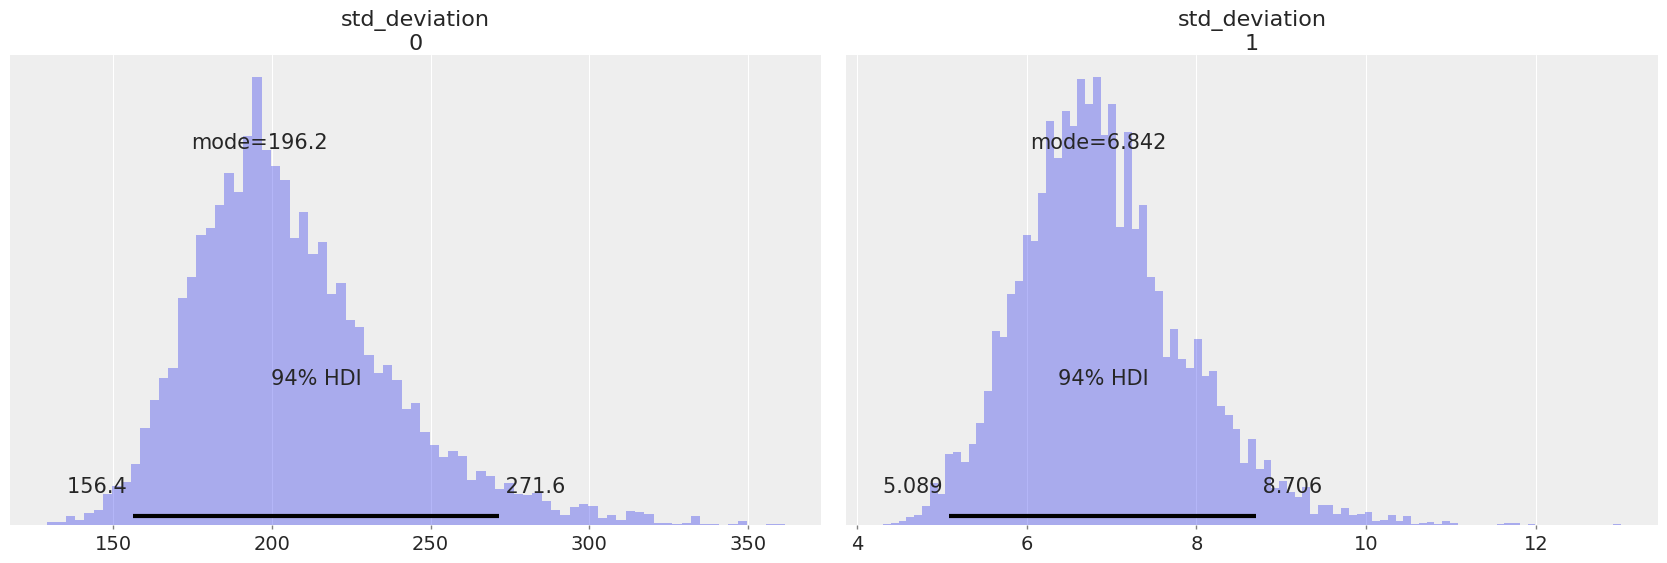

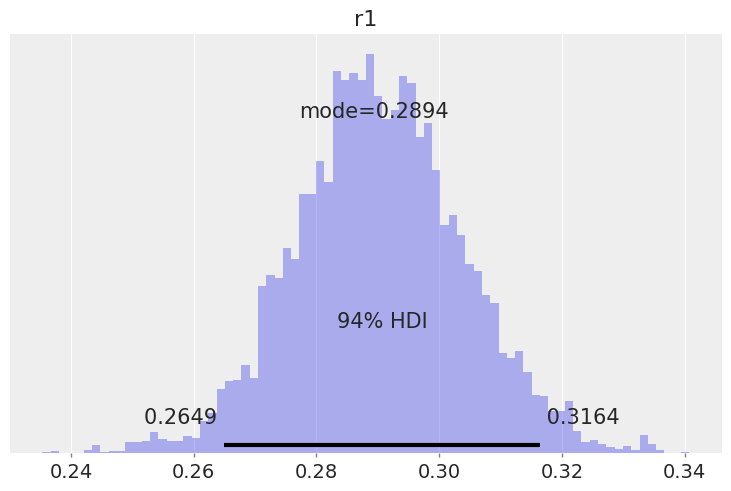

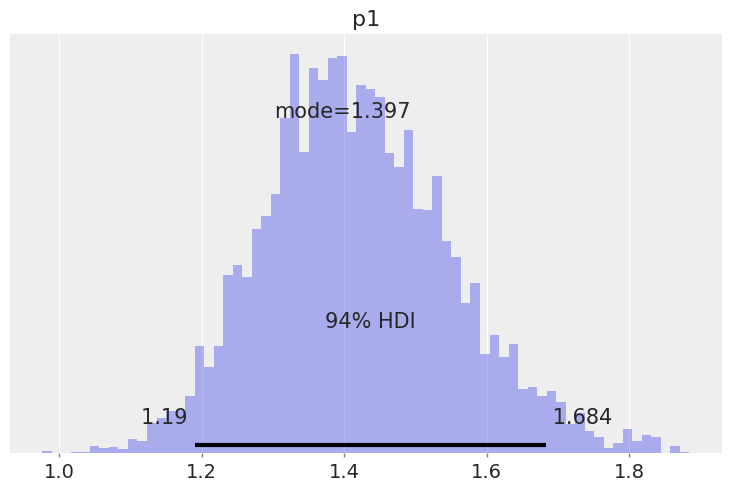

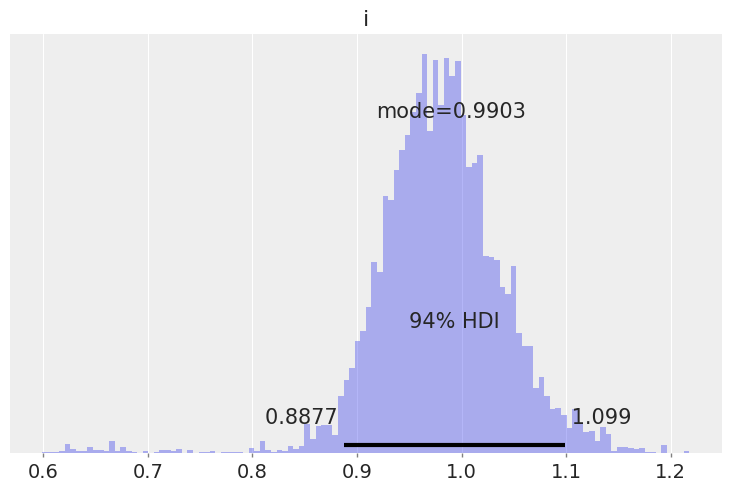

In [75]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_BKMC[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal.png")

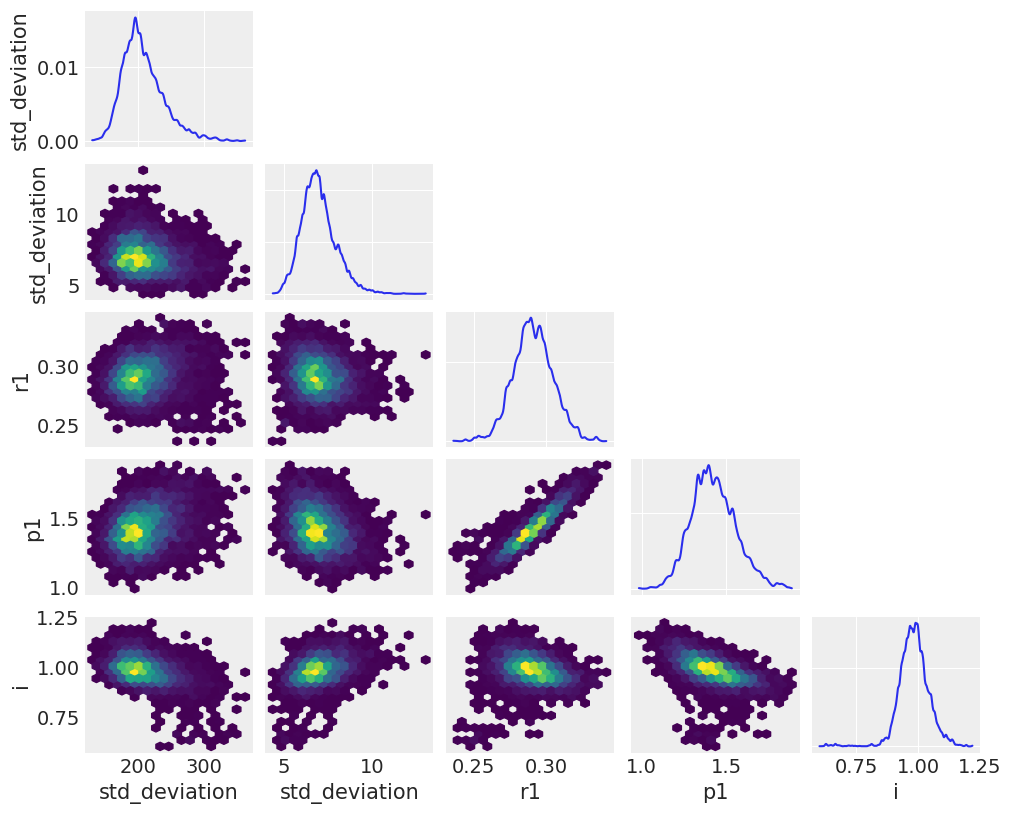

In [76]:
az.plot_pair(
    trace_calibration_BKMC,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal.png")

In [77]:
df_stats_summary = az.summary(
    data=trace_calibration_BKMC,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

mean         sd      hdi_3%     hdi_97%
std_deviation[0]  208.299362  31.568444  156.369451  271.558123
std_deviation[1]    6.957219   0.975473    5.088982    8.705643
r1                  0.291011   0.013724    0.264916    0.316385
p1                  1.426389   0.131975    1.190219    1.683700
i                   0.982896   0.061284    0.887694    1.098722

Auxiliary functions to compute the Most Probable Value (MPV):

In [78]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [79]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_BKMC, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("stats_summary_calibration.csv")  # salvando em um csv para consultas

df_stats_summary

Calculating MPV from KDE for i: 100%|██████████| 4/4 [00:30<00:00,  7.58s/it]            


mean         sd      hdi_3%     hdi_97%         mpv
std_deviation[0]  208.299362  31.568444  156.369451  271.558123  196.795794
std_deviation[1]    6.957219   0.975473    5.088982    8.705643    6.779192
r1                  0.291011   0.013724    0.264916    0.316385    0.288205
p1                  1.426389   0.131975    1.190219    1.683700    1.388899
i                   0.982896   0.061284    0.887694    1.098722    0.989224

In [80]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_BKMC["BKMC_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_BKMC["BKMC_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_BKMC["BKMC_model"], 50, axis=0)

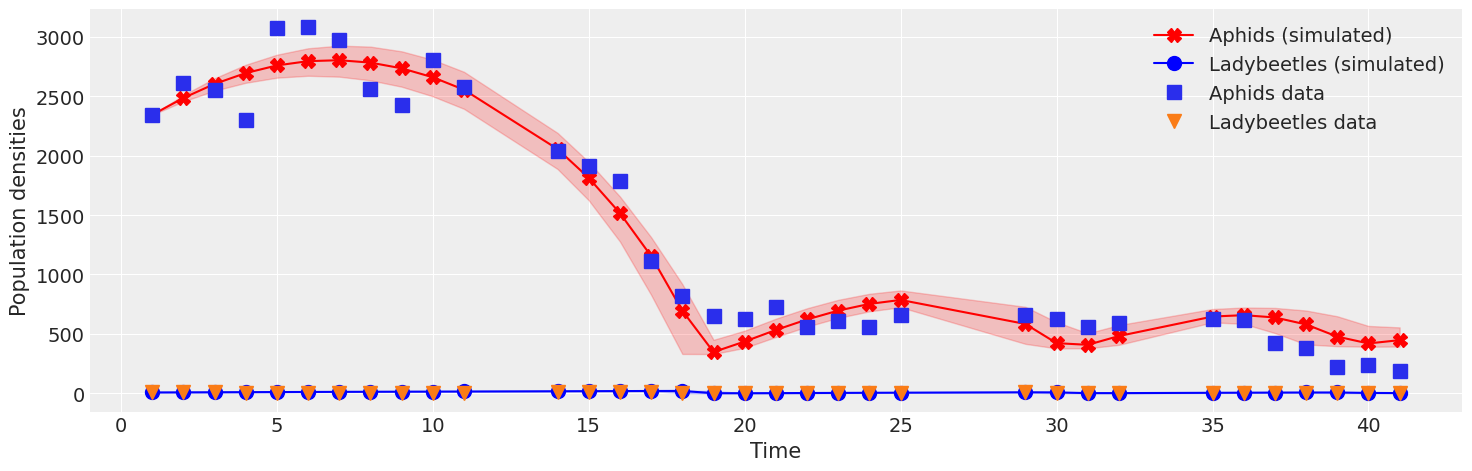

In [81]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration.png", dpi=300)
plt.show()

In [82]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_BKMC.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("calibration_realizations.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering i realizations: 100%|██████████| 3/3 [00:00<00:00, 555.44it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.132 seconds


In [83]:
df_realizations

r1        p1         i
0      0.306298  1.612998  0.908963
1      0.306298  1.612998  0.908963
2      0.306107  1.528074  0.974341
3      0.305652  1.505614  1.006470
4      0.305652  1.505614  1.006470
...         ...       ...       ...
17995  0.298015  1.453452  1.015649
17996  0.298015  1.453452  1.015649
17997  0.298015  1.453452  1.015649
17998  0.298015  1.453452  1.015649
17999  0.298015  1.453452  1.015649

[18000 rows x 3 columns]

# Prey-Predator Lucas model

In [84]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
import pandas as pd

@jit(nopython=True)
def PPLK_model(
    t,
    X,
    r1 = 10,
    r2 = 0.5,
    a_PR = 5,
    Th = 1,
    ef = 0.15,
    e = 1.5,
):
    """
    Prey-Predator Lucas K model (PPLK) python implementation.
    """
    u, v = X
    u_prime = -a_PR * u * v / ( 1 + a_PR * Th * u  ) + r1 * u - r2 * u * u
    v_prime = -e * v * v / ( 1 + e * v ) + ef * u * u
    return u_prime, v_prime

def PPLK_ode_solver(
    y0,
    t_span,
    t_eval,
    r1 = 10,
    r2 = 0.5,
    a_PR = 5,
    Th = 1,
    ef = 0.15,
    e = 1.5,
):
    solution_ODE = solve_ivp(
        fun=PPLK_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r1,r2,a_PR,Th,ef,e),
        method="LSODA",
    )
    return solution_ODE

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, len(aphid_data.Time.values))

u_data = aphid_data.Density.values
v_data = ladybeetle_data.Density.values

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [85]:
def PPLK_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1e1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
    #         y_model = fitting_model(time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [86]:
from scipy import optimize

r1=7.699028294139937
r2=6.381962476534955e-23
a_PR=1.0714241999985732
Th=1.534460987549707e-14
ef=2.818730479576039e-09
e=0.00011104544943485723
denom_min = 0.1
denom_max = 1.9
bounds_PPLK = [
    ( ( r1 * denom_min ), ( r1 * denom_max ) ),  # r1
    ( ( r2 * denom_min ), ( r2 * denom_max ) ),  # r2
    ( ( a_PR * denom_min ), ( a_PR * denom_max ) ),  # a_PR
    ( ( Th * denom_min ), ( Th * denom_max ) ),# Th
    ( ( ef * denom_min ), ( ef * denom_max ) ),  # ef
    ( ( e * denom_min ), ( e * denom_max ) ),  # e
]

result_PPLK = optimize.differential_evolution(
    PPLK_least_squares_error_ode,
    bounds=bounds_PPLK,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        PPLK_ode_solver,
        y0_BKM,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=20000, # 2000
    polish=True,
    disp=True,
    seed = seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_PPLK)

differential_evolution step 1: f(x)= 2.42381e+06
parameters = [1.32115218e+01 1.16135093e-22 1.87107158e+00 1.87794142e-14
 2.30315120e-09 7.40810280e-05]

differential_evolution step 2: f(x)= 1.94142e+06
parameters = [9.74134459e+00 2.78980179e-23 1.37419983e+00 2.26203493e-14
 2.53508804e-09 8.27417552e-05]

differential_evolution step 3: f(x)= 1.30306e+06
parameters = [1.05250155e+01 2.03659625e-23 1.49168640e+00 1.91175029e-14
 2.56747616e-09 1.02864354e-04]

differential_evolution step 4: f(x)= 1.06348e+06
parameters = [8.85894808e+00 1.89175038e-23 1.25250351e+00 1.76603888e-14
 2.48684360e-09 8.15019500e-05]

differential_evolution step 5: f(x)= 975870
parameters = [8.70342969e+00 3.93148734e-23 1.23335912e+00 2.29531028e-14
 2.31034315e-09 7.87305029e-05]

differential_evolution step 6: f(x)= 975870
parameters = [8.70342969e+00 3.93148734e-23 1.23335912e+00 2.29531028e-14
 2.31034315e-09 7.87305029e-05]

differential_evolution step 7: f(x)= 975870
parameters = [8.70342969e+00 3

differential_evolution step 55: f(x)= 868688
parameters = [8.23404260e+00 7.63447940e-23 1.16420248e+00 2.13519273e-14
 2.61032523e-09 1.04737054e-04]

differential_evolution step 56: f(x)= 868681
parameters = [8.24536041e+00 7.37798697e-23 1.16581271e+00 2.20516584e-14
 2.61120480e-09 1.04876913e-04]

differential_evolution step 57: f(x)= 868671
parameters = [8.25237833e+00 6.93902070e-23 1.16681440e+00 1.88368996e-14
 2.60815582e-09 1.04679177e-04]

differential_evolution step 58: f(x)= 868671
parameters = [8.25237833e+00 6.93902070e-23 1.16681440e+00 1.88368996e-14
 2.60815582e-09 1.04679177e-04]

differential_evolution step 59: f(x)= 868662
parameters = [8.25894753e+00 6.43649425e-23 1.16775617e+00 2.19074954e-14
 2.60490086e-09 1.04564807e-04]

differential_evolution step 60: f(x)= 868659
parameters = [8.26535225e+00 4.93464944e-23 1.16866959e+00 2.25491670e-14
 2.60222549e-09 1.04374801e-04]

differential_evolution step 61: f(x)= 868652
parameters = [8.27557759e+00 6.53831757e-23

* Retrieving the calibrated parameter values:

In [87]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r1_deterministic,
    r2_deterministic,
    a_PR_deterministic,
    Th_deterministic,
    ef_deterministic,
    e_deterministic,
) = result_PPLK.x

solution_ODE_PPLK = PPLK_ode_solver(
    y0_BKM,
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_PPLK.x
)
t_computed_PPLK, y_computed_PPLK = solution_ODE_PPLK.t, solution_ODE_PPLK.y
u_PPLK, v_PPLK = y_computed_PPLK

parameters_dict = {
    "Model": "PPLK",
    u"$r1$": r1_deterministic,
    u"$r2$": r2_deterministic,
    u"$a_PR$": a_PR_deterministic,
    u"$Th$": Th_deterministic,
    u"$ef$": ef_deterministic,
    u"$e$": e_deterministic,
}

print("r1=" + str(r1_deterministic) + "\n" + "r2=" + str(r2_deterministic) + "\n" + "a_PR=" + str(a_PR_deterministic) + "\n" + "Th=" + str(Th_deterministic) + "\n" + "ef=" + str(ef_deterministic) + "\n" + "e=" + str(e_deterministic))

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
#print(df_parameters_calibrated.to_latex(index=False))

r1=8.301603376166621
r2=8.577076392632586e-23
a_PR=1.1738507259922166
Th=9.613299842603063e-15
ef=2.5918803828470316e-09
e=0.0001040945861788279


#### Simulation

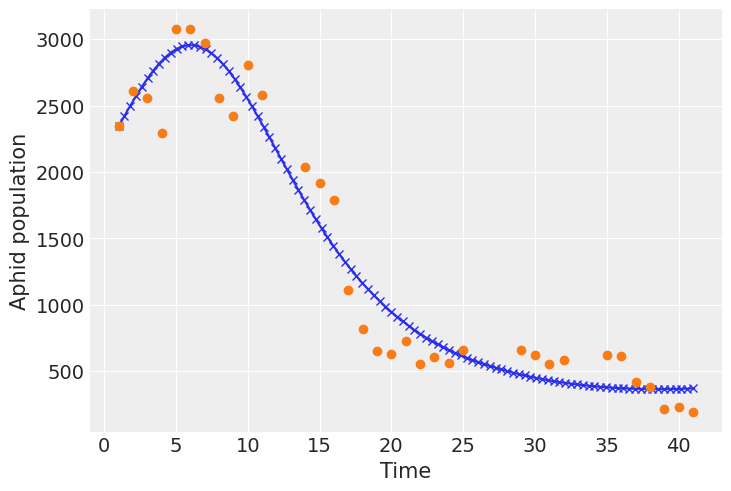

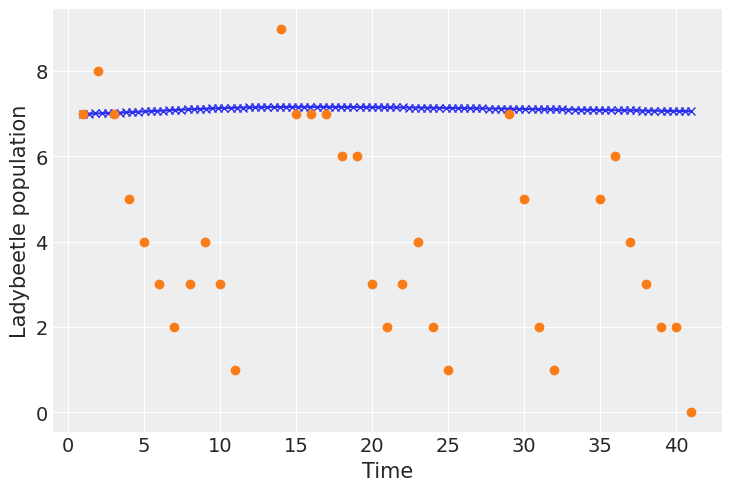

In [88]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_PPLK, u_PPLK, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_PPLK, v_PPLK, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### Least-Squares objective function

In [89]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    a_PR,
    Th,
    ef,
    e,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$a_PR$",
    r"$Th$",
    r"$ef$",
    r"$e$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [90]:
from tqdm import tqdm

num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = PPLK_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        PPLK_ode_solver,
        y0_BKM
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 28/28 [00:00<00:00, 206.01it/s]


In [91]:
from SALib.analyze.morris import analyze as ee_analyze

data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$a_PR$     0.488961
$r1$       0.339506
$ef$       0.171358
$e$     0.000175042
$Th$    8.78064e-12
$r2$              0

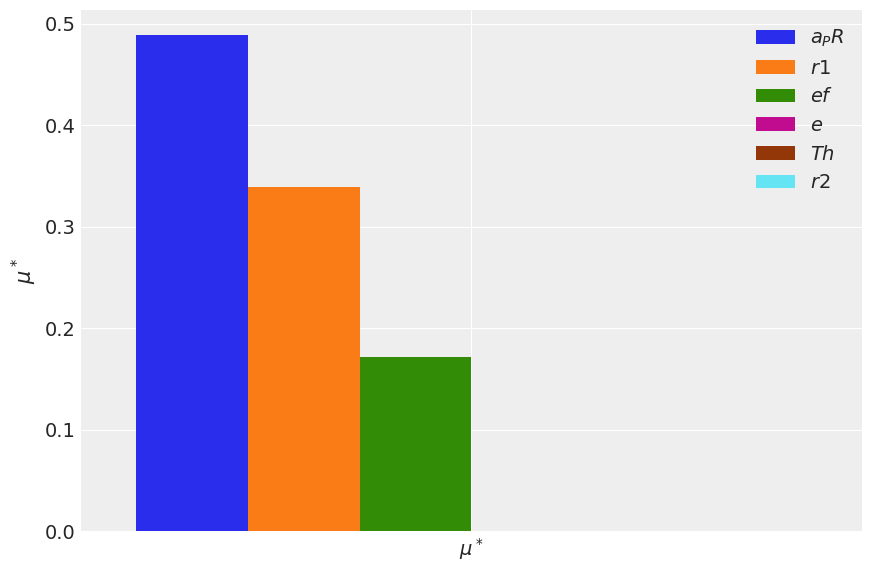

In [92]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares.png", dpi=300)
plt.show()

### Prey (pest) population

In [93]:
from SALib.sample.morris import sample as ee_sample

mean_values_params = [
    r1,
    r2,
    a_PR,
    Th,
    ef,
    e,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$a_PR$",
    r"$Th$",
    r"$ef$",
    r"$e$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [94]:
from tqdm import tqdm

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_PPLK = PPLK_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_PPLK.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 28/28 [00:00<00:00, 120.19it/s]


In [95]:
from SALib.analyze.morris import analyze as ee_analyze

df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:01<00:00, 66.06it/s]


Time      $r1$ $r2$    $a_PR$         $Th$        $ef$          $e$
0    1.404040  0.525639    0  0.472575  4.63991e-12  0.00172533   6.0997e-05
1    1.808081  0.401244    0  0.482348  3.43557e-12    0.116365  4.23403e-05
2    2.212121  0.551923    0   0.41169  2.79666e-11   0.0362999   8.7384e-05
3    2.616162  0.576579    0  0.417859  1.24648e-10  0.00538641  0.000174907
4    3.020202  0.597194    0  0.399464  4.44452e-11  0.00265102  0.000691103
..        ...       ...  ...       ...          ...         ...          ...
94  39.383838  0.639359    0   0.12079  1.91509e-09    0.146351    0.0934994
95  39.787879  0.637822    0   0.12168  1.91384e-09    0.145192    0.0953061
96  40.191919  0.636171    0  0.122633  1.91083e-09    0.144049    0.0971475
97  40.595960  0.634407    0   0.12365  1.91361e-09    0.142917    0.0990253
98  41.000000  0.632536    0  0.124729  1.93301e-09    0.141797     0.100939

[99 rows x 7 columns]

In [96]:
df_sigmai

Time      $r1$ $r2$    $a_PR$         $Th$        $ef$          $e$
0    1.404040   0.46002    0  0.535646  3.89191e-12  0.00424408  8.99753e-05
1    1.808081  0.265641    0  0.511352  4.41055e-12    0.222953  5.42613e-05
2    2.212121  0.460887    0  0.468153  4.91941e-11   0.0708774  8.22647e-05
3    2.616162  0.533283    0   0.45959  1.66871e-10  0.00702433  0.000103133
4    3.020202  0.560662    0  0.437875  2.03765e-11  0.00101365  0.000449104
..        ...       ...  ...       ...          ...         ...          ...
94  39.383838  0.613034    0  0.114766  1.78696e-09    0.184281    0.0879192
95  39.787879  0.611288    0  0.115555  1.77927e-09    0.183572    0.0895856
96  40.191919  0.609429    0  0.116404   1.7703e-09    0.182881    0.0912856
97  40.595960  0.607467    0  0.117314  1.76837e-09    0.182199    0.0930207
98  41.000000  0.605404    0  0.118281  1.78485e-09    0.181525    0.0947897

[99 rows x 7 columns]

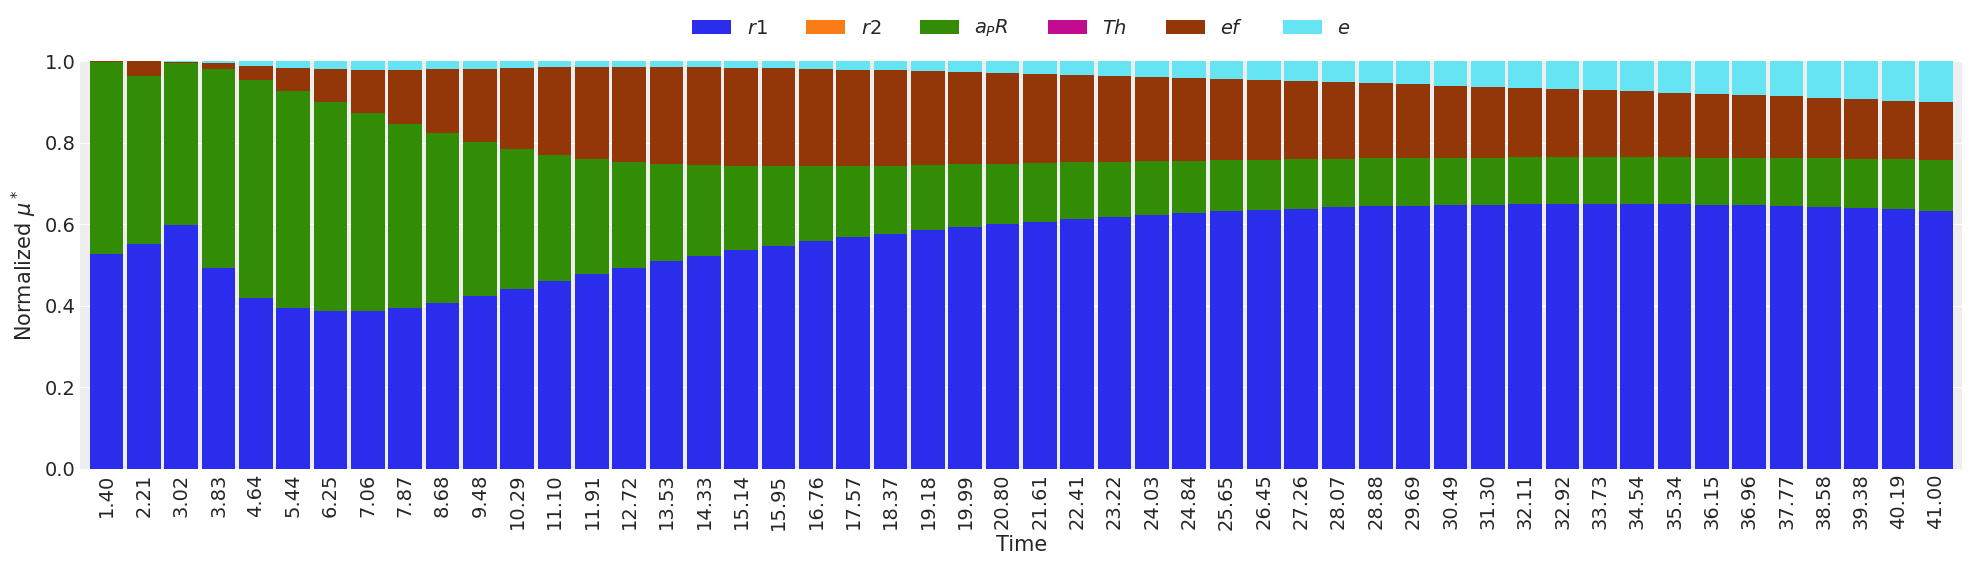

In [97]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop.png", dpi=300)
plt.show()

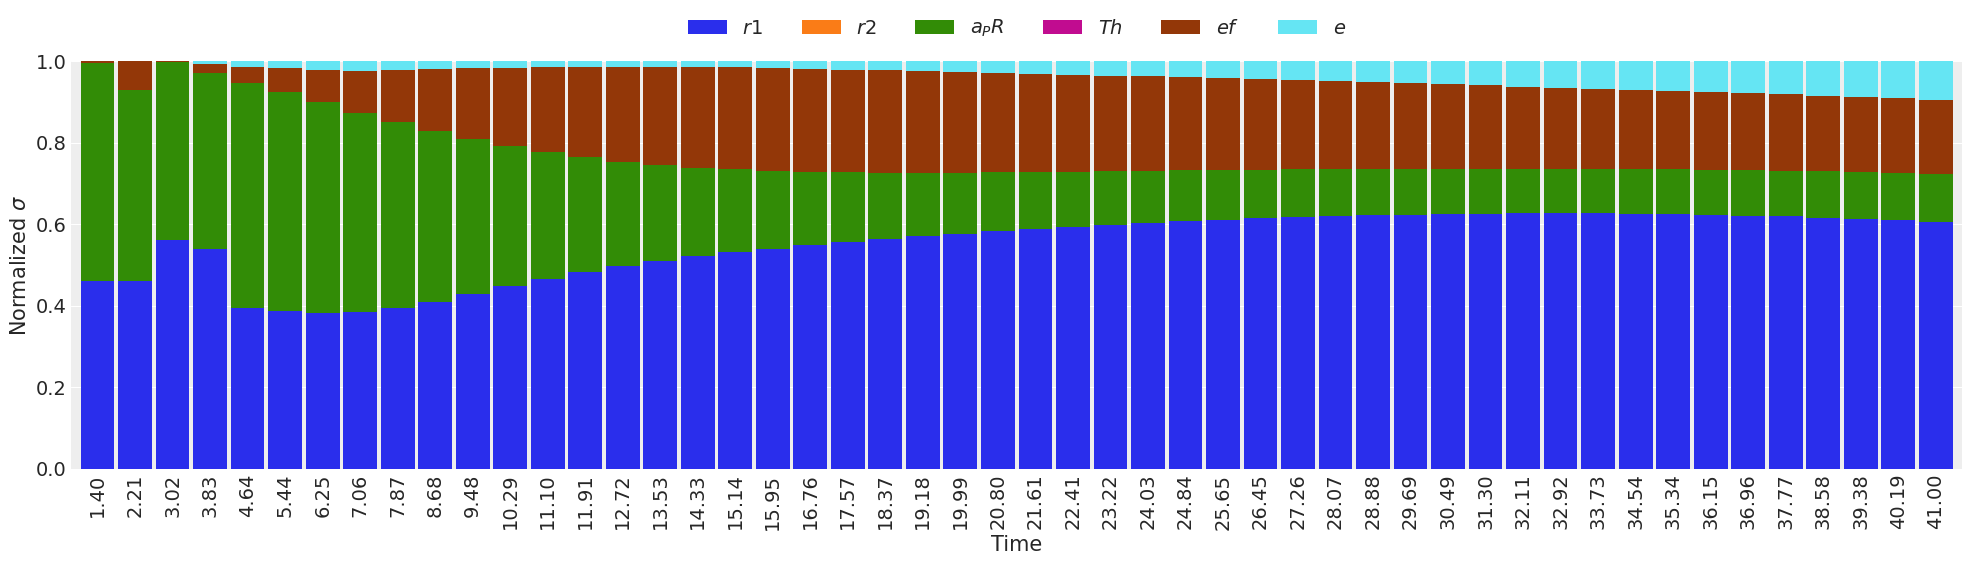

In [98]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma.png", dpi=300)
plt.show()

### Time-derivative of pest (prey) population

In [99]:
def calculate_pest_time_derivative_series(
    time_array, 
    u_array, 
    v_array, 
    ode_model,
    model_pars
):
    pest_time_derivative_values = list()
    for t_idx, time in enumerate(time_array):
        u = u_array[t_idx]
        v = v_array[t_idx]
        stacked_population = [u, v]
        pest_time_derivative_value, _ = ode_model(time, stacked_population, *model_pars)
        pest_time_derivative_values.append(pest_time_derivative_value)
        
    pest_time_derivative_array = np.array(pest_time_derivative_values)
    return pest_time_derivative_array

In [100]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_PPLK,
    u_PPLK,
    v_PPLK,
    PPLK_model,
    mean_values_params
)

pest_time_derivative_array

array([466.39498967, 470.92135325, 474.42327358, 475.54682211,
       474.17459935, 470.13107319, 463.37033147, 453.83594307,
       441.62444833, 426.8213869 , 409.64801397, 390.37945622,
       369.44863445, 346.9788339 , 323.69334   , 300.09210514,
       276.40341342, 252.83118668, 229.97159865, 208.09414374,
       187.28076427, 167.78786344, 149.82993192, 133.38885204,
       118.4743736 , 105.14248706,  93.32151433,  82.92780627,
        73.86595821,  66.03957864,  59.35402274,  53.66761876,
        48.86482379,  44.86680052,  41.56547565,  38.83630576,
        36.62272366,  34.86089372,  33.44600132,  32.33564401,
        31.49697898,  30.85999397,  30.38882965,  30.06789727,
        29.86311808,  29.74264256,  29.6998937 ,  29.71032751,
        29.76123661,  29.87188076,  29.96446569,  30.08735225,
        30.23548504,  30.41010451,  30.60768359,  30.82447204,
        31.05719487,  31.30292192,  31.55894689,  31.82267583,
        32.09152506,  32.36282859,  32.63375493,  32.90

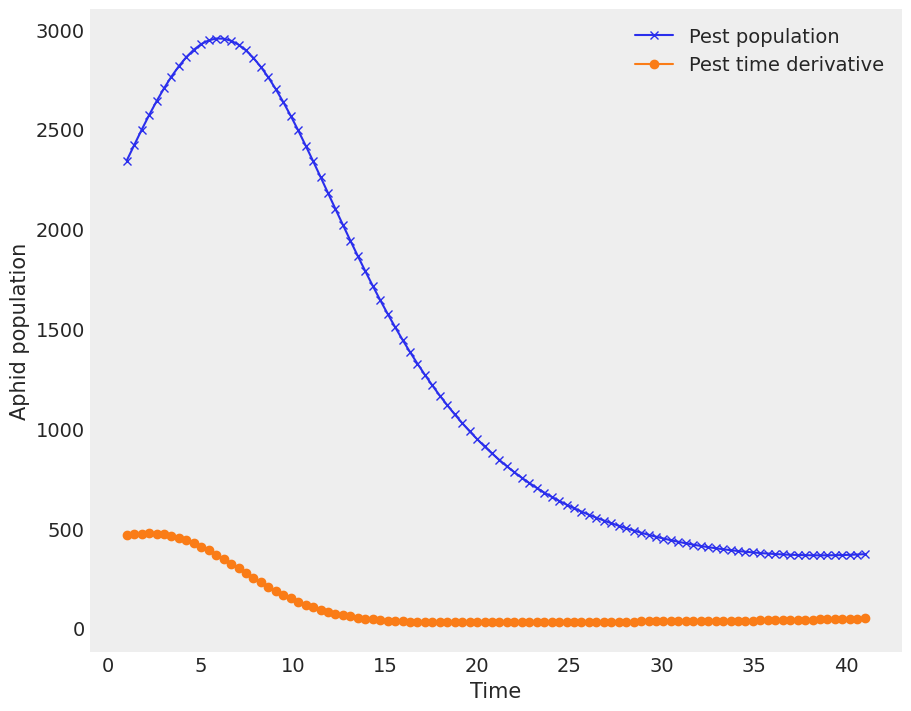

In [101]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_PPLK, u_PPLK, '-x', label='Pest population')
plt.plot(t_computed_PPLK, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative.png", dpi=300)
plt.show()

In [102]:
mean_values_params = [
    r1,
    r2,
    a_PR,
    Th,
    ef,
    e,
]
factors_names = [
    r"$r1$",
    r"$r2$",
    r"$a_PR$",
    r"$Th$",
    r"$ef$",
    r"$e$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [103]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_PPLK = PPLK_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_PPLK.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        PPLK_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 28/28 [00:00<00:00, 112.41it/s]


In [104]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 104.21it/s]


Time      $r1$ $r2$     $a_PR$         $Th$        $ef$          $e$
0    1.404040  0.515617    0   0.479016  3.06548e-12  0.00528077  8.62675e-05
1    1.808081  0.517858    0    0.27048  6.02334e-12    0.211525  0.000136844
2    2.212121  0.434539    0   0.487828  3.45517e-11   0.0776017  3.10403e-05
3    2.616162  0.561218    0    0.42206  2.88331e-11   0.0165614  0.000159915
4    3.020202  0.568364    0   0.428553  2.75363e-10  0.00281165   0.00027178
..        ...       ...  ...        ...          ...         ...          ...
94  39.383838  0.714323    0  0.0769327  3.52683e-10    0.206406   0.00233816
95  39.787879  0.719439    0  0.0721826  2.57513e-10    0.206376   0.00200296
96  40.191919  0.721121    0  0.0665429  2.26076e-10    0.205375   0.00696173
97  40.595960  0.722726    0  0.0602984  2.86089e-10    0.204368    0.0126083
98  41.000000  0.724255    0  0.0533587  3.41214e-10    0.203352    0.0190346

[99 rows x 7 columns]

In [105]:
df_sigmai

Time      $r1$ $r2$     $a_PR$         $Th$        $ef$          $e$
0    1.404040  0.471988    0   0.517884  2.99335e-12  0.00999514  0.000133018
1    1.808081  0.477286    0   0.223253  7.51947e-12    0.299277  0.000183584
2    2.212121  0.393155    0   0.422321  7.97694e-11    0.184477  4.70704e-05
3    2.616162  0.430398    0   0.533902  5.87506e-11    0.035467  0.000233897
4    3.020202   0.53087    0   0.465659  3.69594e-10  0.00324455  0.000226337
..        ...       ...  ...        ...          ...         ...          ...
94  39.383838  0.696746    0  0.0748408  3.57093e-10    0.226215   0.00219791
95  39.787879  0.702096    0  0.0704602  3.22848e-10    0.225511   0.00193267
96  40.191919  0.704434    0  0.0653293  3.28177e-10    0.223739   0.00649835
97  40.595960  0.706736    0  0.0597245  3.75983e-10    0.221838    0.0117024
98  41.000000  0.709003    0  0.0536079  4.49659e-10    0.219792    0.0175971

[99 rows x 7 columns]

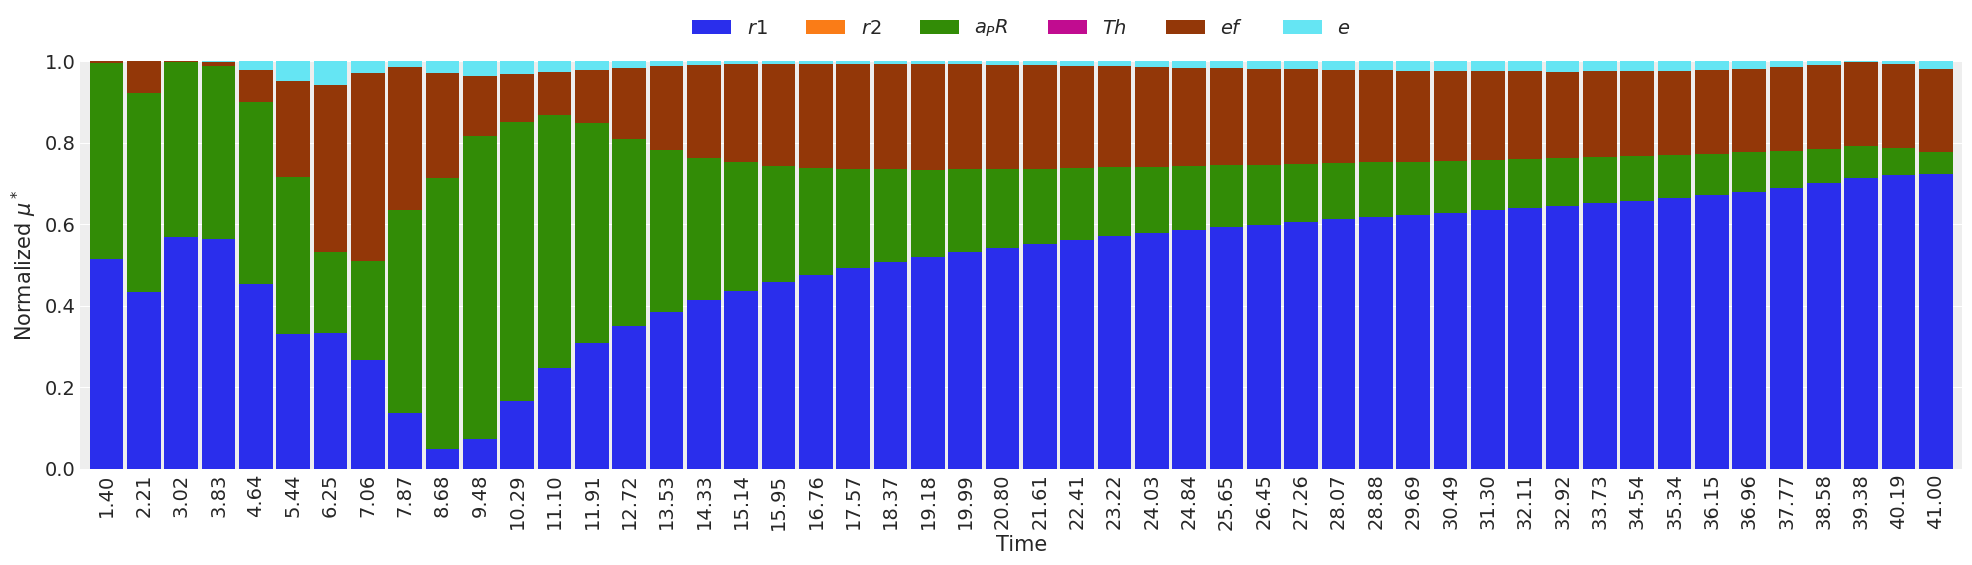

In [106]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative.png", dpi=300)
plt.show()

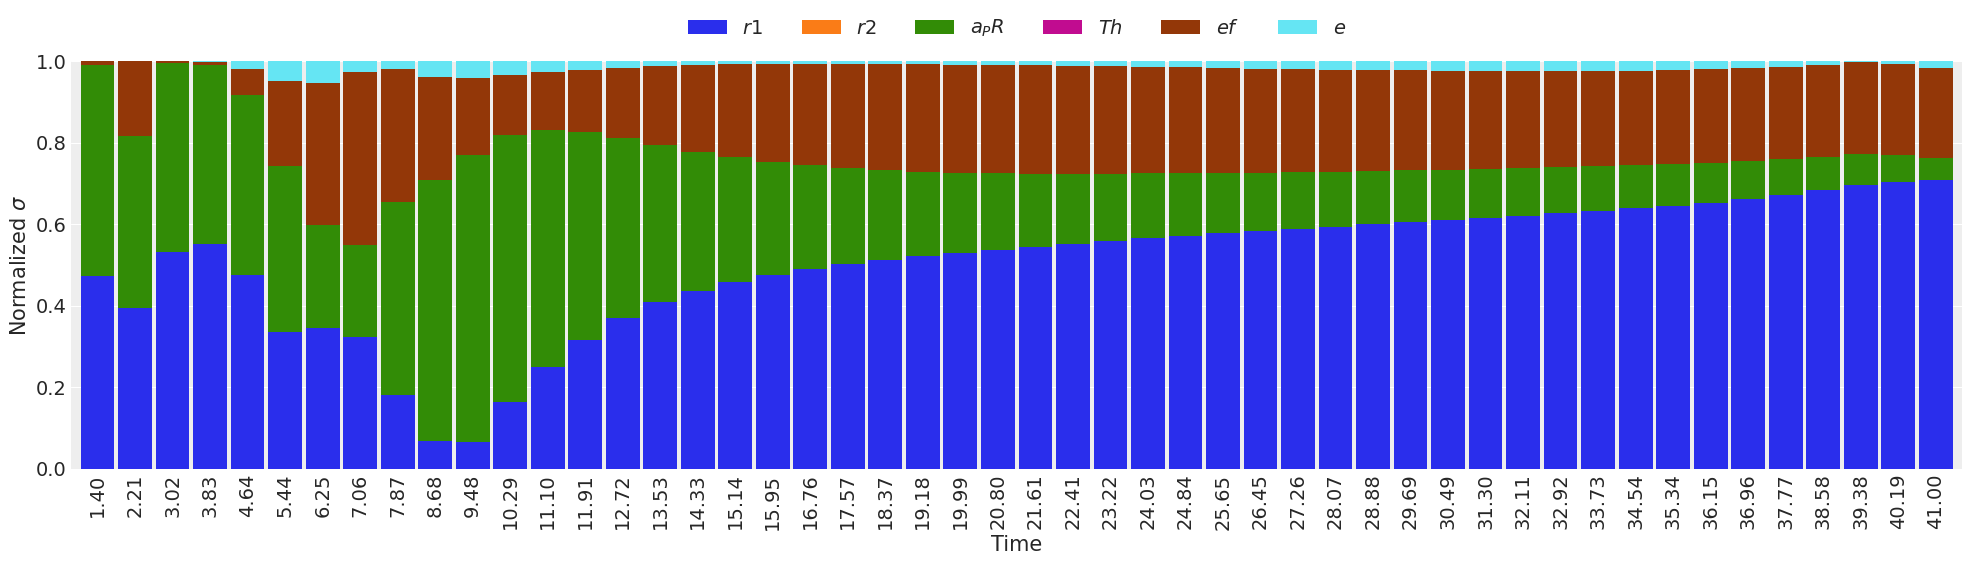

In [107]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative.png", dpi=300)
plt.show()

## Bayesian calibration

In [108]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r1 
        t.dscalar,  # r2
        t.dscalar,  # a_PR
        t.dscalar,  # Th
        t.dscalar,  # ef
        t.dscalar,  # e
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def PPLK_ode_wrapper(time_exp, r1, r2, a_PR, Th, ef, e, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r1, r2, a_PR, Th, ef, e]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        PPLK_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [109]:
observed_aphids = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit = np.vstack([observed_aphids, observed_ladybeetles]).T  # note the transpose here
time_observations = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_PPLK:
    # Prior distributions for the model's parameters
    r1_range_factor = 1.0
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - r1_range_factor * percent_calibration) * r1,
        upper=(1.0 + r1_range_factor * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#         "r2", 
#         lower=(1.0 - percent_calibration) * r2, 
#         upper=(1.0 + percent_calibration) * r2,
#     )
    r2_ = pm.Data("r2", r2)  # r2 values tend to zero
    a_PR_ = pm.Uniform(
        "a_PR", 
        lower=(1.0 - percent_calibration) * a_PR, 
        upper=(1.0 + percent_calibration) * a_PR,
    )
#    Th_ = pm.Uniform(
#        "Th", 
#        lower=(1.0 - percent_calibration) * Th, 
#        upper=(1.0 + percent_calibration) * Th,
#    )
    Th_ = pm.Data("Th", Th)
    ef_ = pm.Data("ef", ef)
#    ef_ = pm.Uniform(
#        "ef", 
#        lower=(1.0 - percent_calibration) * ef, 
#        upper=(1.0 + percent_calibration) * ef,
#    )
    e_ = pm.Uniform(
        "e", 
        lower=(1.0 - percent_calibration) * e, 
        upper=(1.0 + percent_calibration) * e,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=400, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "PPLK_model",
        PPLK_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            a_PR_,
            Th_,
            ef_,
            e_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit
    )
    
coarse_steps_1 = 4
observed_aphids_coarse_1 = observed_aphids[::coarse_steps_1]
observed_ladybeetles_coarse_1 = observed_ladybeetles[::coarse_steps_1]
observations_to_fit_coarse_1 = np.vstack(
    [observed_aphids_coarse_1, observed_ladybeetles_coarse_1]
).T
time_observations_coarse_1 = time_observations[::coarse_steps_1]

with pm.Model() as coarse_model_1:
    # Prior distributions for the model's parameters
    r1_range_factor = 1.0
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - r1_range_factor * percent_calibration) * r1,
        upper=(1.0 + r1_range_factor * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#         "r2", 
#         lower=(1.0 - percent_calibration) * r2, 
#         upper=(1.0 + percent_calibration) * r2,
#     )
    r2_ = pm.Data("r2", r2)  # r2 values tend to zero
    a_PR_ = pm.Uniform(
        "a_PR", 
        lower=(1.0 - percent_calibration) * a_PR, 
        upper=(1.0 + percent_calibration) * a_PR,
    )
#    Th_ = pm.Uniform(
#        "Th", 
#        lower=(1.0 - percent_calibration) * Th, 
#        upper=(1.0 + percent_calibration) * Th,
#    )
    Th_ = pm.Data("Th", Th)
    ef_ = pm.Data("ef", ef)
#    ef_ = pm.Uniform(
#        "ef", 
#        lower=(1.0 - percent_calibration) * ef,
#        upper=(1.0 + percent_calibration) * ef,
#    )
    e_ = pm.Uniform(
        "e", 
        lower=(1.0 - percent_calibration) * e,
        upper=(1.0 + percent_calibration) * e,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=1, upper=400, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_1)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "PPLK_model",
        PPLK_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            a_PR_,
            Th_,
            ef_,
            e_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_1
    )

coarse_steps_2 = 2
observed_aphids_coarse_2 = observed_aphids[::coarse_steps_2]
observed_ladybeetles_coarse_2 = observed_ladybeetles[::coarse_steps_2]
observations_to_fit_coarse_2 = np.vstack(
    [observed_aphids_coarse_2, observed_ladybeetles_coarse_2]
).T
time_observations_coarse_2 = time_observations[::coarse_steps_2]    

with pm.Model() as coarse_model_2:
    # Prior distributions for the model's parameters
    r1_range_factor = 1.0
    r1_ = pm.Uniform(
        "r1", 
        lower=(1.0 - r1_range_factor * percent_calibration) * r1,
        upper=(1.0 + r1_range_factor * percent_calibration) * r1,
    )
#    r2_ = pm.Uniform(
#        "r2", 
#        lower=1e-8,
#        upper=1e-2
#    )
    r2_ = pm.Data("r2", r2)
    a_PR_ = pm.Uniform(
        "a_PR", 
        lower=(1.0 - percent_calibration) * a_PR, 
        upper=(1.0 + percent_calibration) * a_PR,
    )
#    Th_ = pm.Uniform(
#        "Th", 
#        lower=(1.0 - percent_calibration) * Th, 
#        upper=(1.0 + percent_calibration) * Th,
#    )
    Th_ = pm.Data("Th", Th)
    ef_ = pm.Data("ef", ef)
#    ef_ = pm.Uniform(
#        "ef", 
#        lower=(1.0 - percent_calibration) * ef, 
#        upper=(1.0 + percent_calibration) * ef,
#    )
    e_ = pm.Uniform(
        "e", 
        lower=(1.0 - percent_calibration) * e, 
        upper=(1.0 + percent_calibration) * e,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=600, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse_2)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "PPLK_model",
        PPLK_ode_wrapper(
            time_calibration,
            r1_,
            r2_,
            a_PR_,
            Th_,
            ef_,
            e_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse_2
    )    


with fine_model_PPLK:
    step = pm.MLDA(coarse_models=[coarse_model_1], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_PPLK = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)

duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, e, a_PR, r1]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 699 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 12.768 minutes


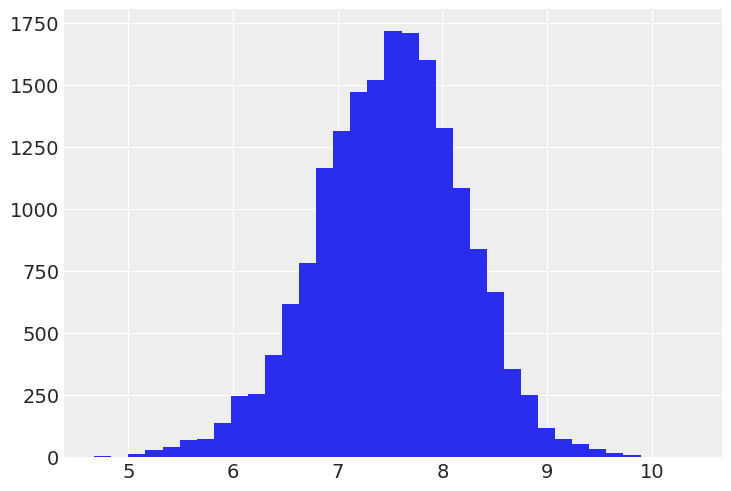

In [110]:
plt.hist(trace_calibration_PPLK['r1'], bins=35)
plt.show()

In [111]:
calibration_variable_names = [
    "std_deviation",
    "r1",
    "a_PR",
    "e",
]

100%|██████████| 4/4 [04:03<00:00, 60.80s/it]


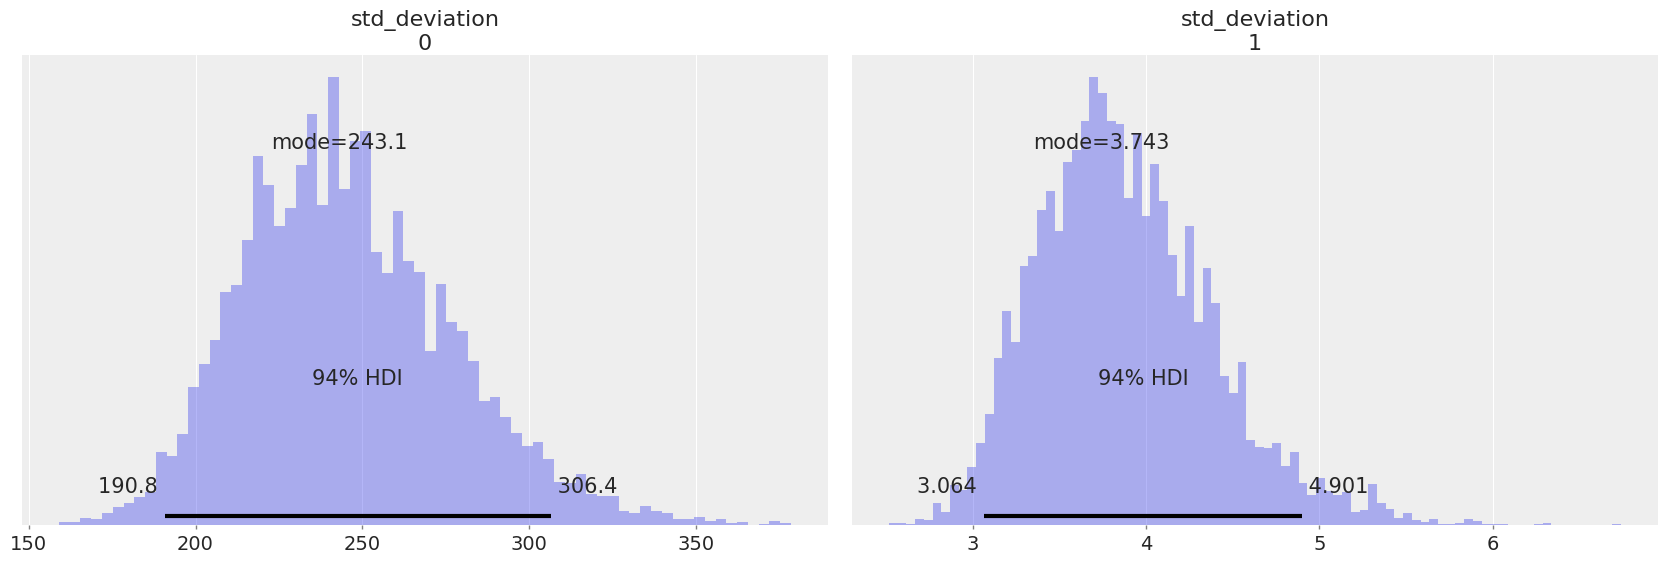

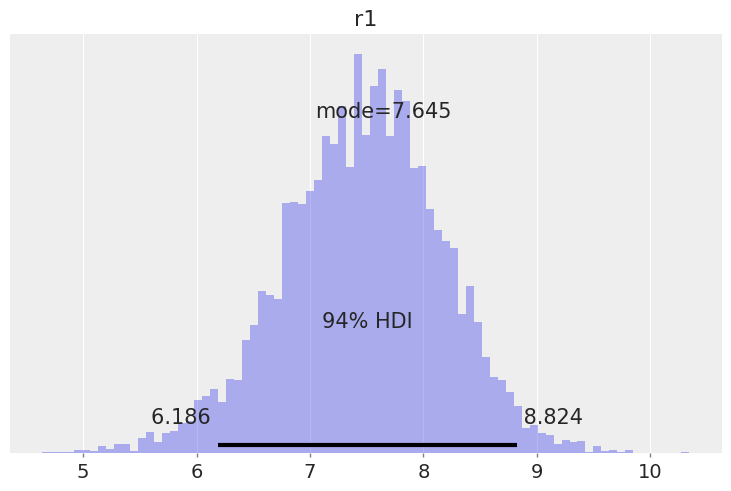

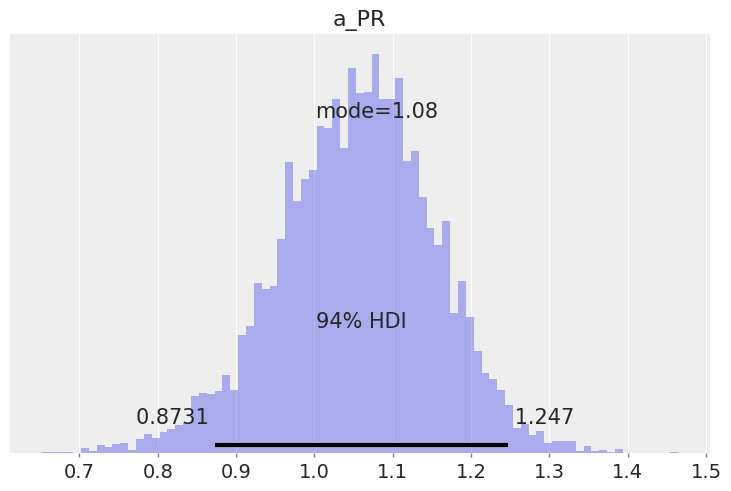

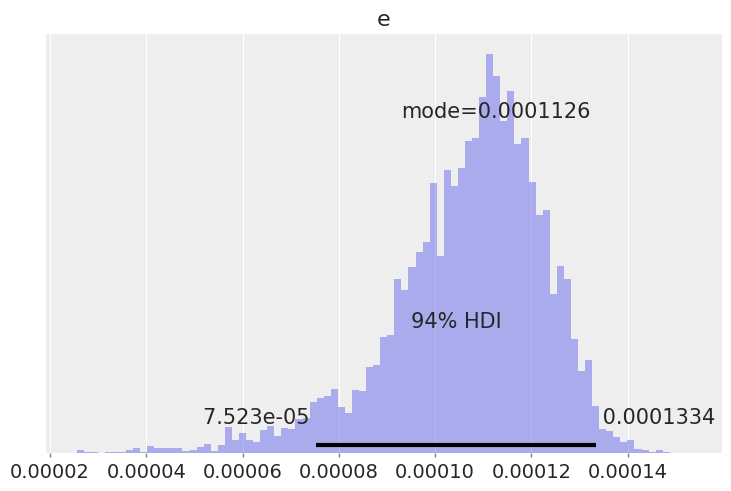

In [112]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_PPLK[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=4,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal.png")

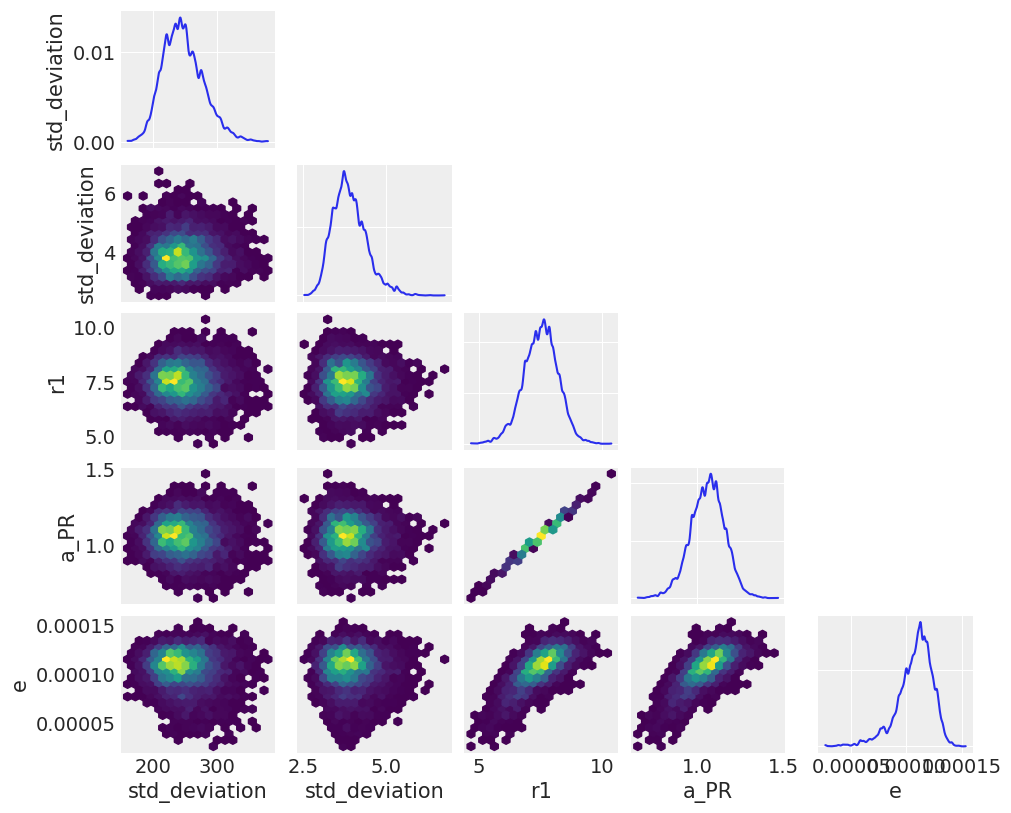

In [113]:
az.plot_pair(
    trace_calibration_PPLK,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal.png")

In [114]:
df_stats_summary = az.summary(
    data=trace_calibration_PPLK,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

mean         sd      hdi_3%     hdi_97%
std_deviation[0]  247.609488  31.638374  190.773453  306.400850
std_deviation[1]    3.906968   0.505270    3.063680    4.901257
r1                  7.498338   0.700979    6.185680    8.823988
a_PR                1.059425   0.099413    0.873052    1.247064
e                   0.000108   0.000016    0.000075    0.000133

Auxiliary functions to compute the Most Probable Value (MPV):

In [115]:
from scipy.stats import gaussian_kde  # to calculate MPV from KDE

def _scalar_rv_mvp_estimation(rv_realization_values: np.ndarray) -> np.ndarray:
    num_of_realizations = len(rv_realization_values)
    kernel = gaussian_kde(rv_realization_values)
    equally_spaced_samples = np.linspace(
        rv_realization_values.min(),
        rv_realization_values.max(),
        num_of_realizations
    )
    kde = kernel(equally_spaced_samples)
    kde_max_index = np.argmax(kde)
    rv_mpv_value = equally_spaced_samples[kde_max_index]
    return rv_mpv_value


def calculate_rv_posterior_mpv(pm_trace, variable_names: list) -> dict:
    rv_mpv_values_dict = dict()
    progress_bar = tqdm(variable_names)
    for variable in progress_bar:
        progress_bar.set_description(f"Calculating MPV from KDE for {variable}")
        rv_realization_values = pm_trace[f"{variable}"]

        try:
            num_of_dimensions = rv_realization_values.shape[1]
        except IndexError:
            num_of_dimensions = 0

        if num_of_dimensions == 0:
            rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values)
            rv_mpv_values_dict[f"{variable}"] = rv_mpv_value
        else:
            for dimension in range(num_of_dimensions):
                variable_name_decomposed = f"{variable}[{dimension}]"
                rv_realization_values_decomposed = np.array(rv_realization_values[:, dimension])
                rv_mpv_value = _scalar_rv_mvp_estimation(rv_realization_values_decomposed)
                rv_mpv_values_dict[f"{variable_name_decomposed}"] = rv_mpv_value

    return rv_mpv_values_dict


def add_mpv_to_summary(arviz_summary: pd.DataFrame, rv_modes_dict: dict) -> pd.DataFrame:
    new_arviz_summary = arviz_summary.copy()
    variable_names = list(rv_modes_dict.keys())
    rv_mode_values = list(rv_modes_dict.values())
    new_arviz_summary["mpv"] = pd.Series(data=rv_mode_values, index=variable_names)
    return new_arviz_summary

In [116]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_PPLK, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("stats_summary_calibration.csv")  # salvando em um csv para consultas

df_stats_summary

Calculating MPV from KDE for e: 100%|██████████| 4/4 [00:33<00:00,  8.47s/it]            


mean         sd      hdi_3%     hdi_97%         mpv
std_deviation[0]  247.609488  31.638374  190.773453  306.400850  242.715854
std_deviation[1]    3.906968   0.505270    3.063680    4.901257    3.752274
r1                  7.498338   0.700979    6.185680    8.823988    7.618873
a_PR                1.059425   0.099413    0.873052    1.247064    1.076899
e                   0.000108   0.000016    0.000075    0.000133    0.000112

In [117]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_PPLK["PPLK_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_PPLK["PPLK_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_PPLK["PPLK_model"], 50, axis=0)

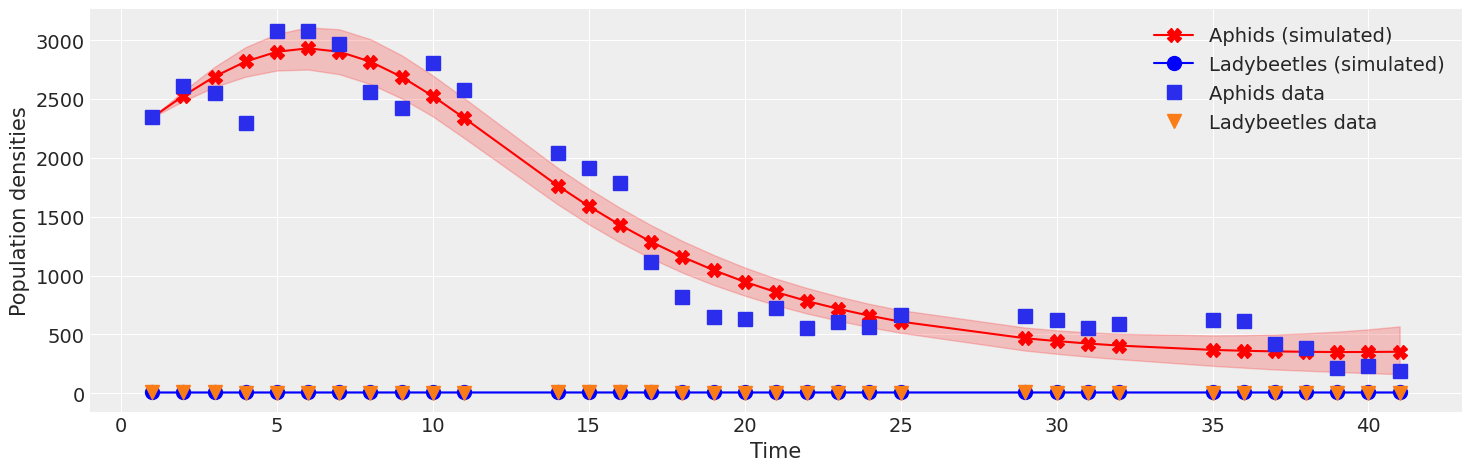

In [118]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration.png", dpi=300)
plt.show()

In [119]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_PPLK.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("calibration_realizations.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering e realizations: 100%|██████████| 3/3 [00:00<00:00, 565.30it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.136 seconds


In [120]:
df_realizations

r1      a_PR         e
0      7.460101  1.054578  0.000109
1      7.460101  1.054578  0.000109
2      7.460101  1.054578  0.000109
3      7.265661  1.025833  0.000109
4      7.265661  1.025833  0.000109
...         ...       ...       ...
17995  7.650054  1.078672  0.000119
17996  7.650054  1.078672  0.000119
17997  7.650054  1.078672  0.000119
17998  8.011679  1.130406  0.000124
17999  8.011679  1.130406  0.000124

[18000 rows x 3 columns]

# Prey-Predator logistic Lotka-Volterra

In [121]:
@jit(nopython=True)
def LLV_model(
    t,
    X,
    r=1,
    K=10,
    a=1,
    ef=1,
    m=1,
):
    """
    Prey-Predator logistic Lotka-Volterra (LLV) python implementation.
    """
    u, v = X
    u_prime = r * u * ( 1 - u / K ) - a * u * v
    v_prime = ef * a * u * v - m * v
    return u_prime, v_prime

def LLV_ode_solver(
    y0,
    t_span,
    t_eval,
    r=1,
    K=10,
    a=1,
    ef=1,
    m=1,
):
    solution_ODE = solve_ivp(
        fun=LLV_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r, K, a, ef, m),
        method="Radau",
    )
    return solution_ODE

## Deterministic calibration

In [122]:
def LLV_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1e3
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

In [123]:
def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

bounds_LLV = [
    (1e-10, 1),  # r
    (1e-10, 5),  # K
    (1e-10, 1),  # a
    (1e-10, 5),  # ef
    (1e-10, 5),  # m
]

result_LLV = optimize.differential_evolution(
    LLV_least_squares_error_ode,
    bounds=bounds_LLV,
    args=(
        aphid_data.Time.values,
        [aphid_data.Density.values, ladybeetle_data.Density.values],
        LLV_ode_solver,
        y0_BKM,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=2000,
    polish=True,
    disp=True,
    seed=seed,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_LLV)

differential_evolution step 1: f(x)= 4.58479e+07
parameters = [1.37125069e-01 3.80587704e+00 1.66183293e-03 3.50743299e+00
 1.44304224e+00]

differential_evolution step 2: f(x)= 4.58479e+07
parameters = [1.37125069e-01 3.80587704e+00 1.66183293e-03 3.50743299e+00
 1.44304224e+00]

differential_evolution step 3: f(x)= 4.57413e+07
parameters = [0.07971021 4.250969   0.01272015 2.3241663  4.53224582]

differential_evolution step 4: f(x)= 4.46171e+07
parameters = [2.04773759e-02 3.75391389e+00 2.26525918e-03 2.51948196e+00
 4.25460050e+00]

differential_evolution step 5: f(x)= 4.46171e+07
parameters = [2.04773759e-02 3.75391389e+00 2.26525918e-03 2.51948196e+00
 4.25460050e+00]

differential_evolution step 6: f(x)= 4.46171e+07
parameters = [2.04773759e-02 3.75391389e+00 2.26525918e-03 2.51948196e+00
 4.25460050e+00]

differential_evolution step 7: f(x)= 4.46171e+07
parameters = [2.04773759e-02 3.75391389e+00 2.26525918e-03 2.51948196e+00
 4.25460050e+00]

differential_evolution step 8: f(x

differential_evolution step 59: f(x)= 6.39268e+06
parameters = [2.04528102e-05 1.24481123e+00 1.26051754e-03 1.73537688e-02
 2.70248331e-02]

differential_evolution step 60: f(x)= 6.37477e+06
parameters = [1.97845237e-05 1.23275899e+00 1.35331135e-03 3.84852767e-02
 6.87843251e-02]

differential_evolution step 61: f(x)= 6.30278e+06
parameters = [2.54934785e-05 1.64298998e+00 1.57827966e-03 2.88439794e-02
 6.53811182e-02]

differential_evolution step 62: f(x)= 6.23156e+06
parameters = [3.06619257e-05 2.01940531e+00 1.94931362e-03 1.21616586e-02
 2.76022819e-02]

differential_evolution step 63: f(x)= 6.18907e+06
parameters = [2.54246212e-05 1.77748862e+00 2.02001430e-03 6.01335095e-03
 1.80270242e-02]

differential_evolution step 64: f(x)= 6.11845e+06
parameters = [2.39518666e-05 1.82775273e+00 2.35637612e-03 1.95986305e-02
 6.14425299e-02]

differential_evolution step 65: f(x)= 6.01687e+06
parameters = [2.36985759e-05 1.99348400e+00 2.68946715e-03 1.18415704e-02
 4.22115528e-02]

differ

In [124]:
result_LLV.x

array([1.00000000e-10, 1.42285729e+00, 4.09995864e-03, 1.07084000e-02,
       5.17361004e-02])

In [125]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r_deterministic,
    K_deterministic,
    a_deterministic,
    ef_deterministic,
    m_deterministic,
) = result_LLV.x

solution_ODE_LLV = LLV_ode_solver(
    y0_BKM, 
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_LLV.x
)
t_computed_LLV, y_computed_LLV = solution_ODE_LLV.t, solution_ODE_LLV.y
u_LLV, v_LLV = y_computed_LLV

parameters_dict = {
    "Model": "PPRM",
    u"$r$": r_deterministic,
    u"$K$": K_deterministic,
    u"$a$": a_deterministic,
    u"$ef$": ef_deterministic,
    u"$m$": m_deterministic,
}

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
print(df_parameters_calibrated.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
Model &           \$r\$ &       \$K\$ &     \$a\$ &      \$ef\$ &       \$m\$ \\
\midrule
 PPRM &  1.000000e-10 &  1.422857 &  0.0041 &  0.010708 &  0.051736 \\
\bottomrule
\end{tabular}



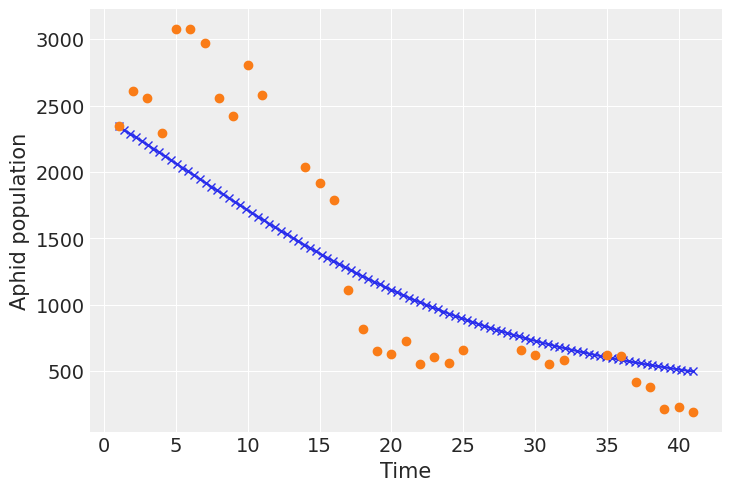

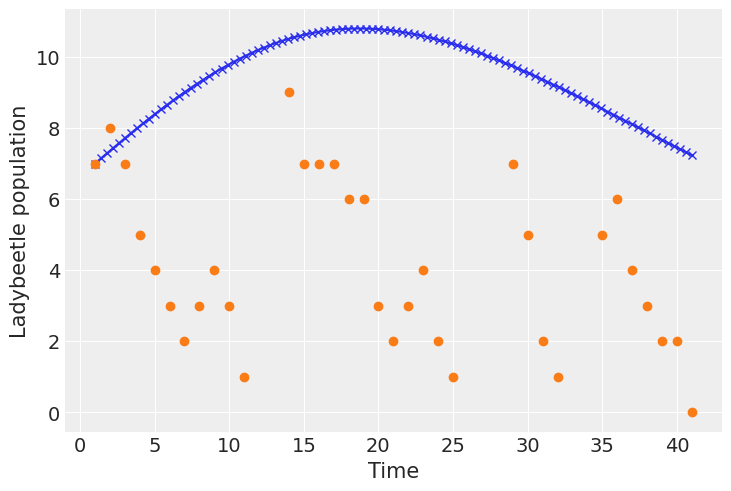

In [126]:
plt.plot(t_computed_LLV, u_LLV, '-x')
plt.plot(aphid_data.Time.values, aphid_observed.Density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_LLV, v_LLV, '-x')
plt.plot(ladybeetle_data.Time.values, ladybeetle_observed.Density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

## Sensitivity Analyses

### SA on Least-Squares objective function

In [127]:
mean_values_params = [
    r_deterministic,
    K_deterministic,
    a_deterministic,
    ef_deterministic,
    m_deterministic,
]
factors_names = [
    r"$r$",
    r"$K$",
    r"$a$",
    r"$ef$",
    r"$m$",
]
params_perturbations = 0.5
problem_info = {
    'num_vars': len(mean_values_params),
    'names': factors_names,
    'bounds': [[param - params_perturbations * param, param + params_perturbations * param] for param in mean_values_params]
}

grid_level = 4
num_of_trajectories = 20
parameter_values = ee_sample(problem_info, grid_level, num_of_trajectories, local_optimization=False, seed=seed)

In [128]:
num_of_realizations = parameter_values.shape[0]
qoi_sensitivity_outputs = np.zeros(num_of_realizations)

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    residual_least_squares_result = LLV_least_squares_error_ode(
        parameters_realization,
        aphid_data.Time.values,
        [u_data, v_data],
        LLV_ode_solver,
        y0_BKM
    )
    
    qoi_sensitivity_outputs[realization_index] = residual_least_squares_result

100%|██████████| 24/24 [00:00<00:00, 109.45it/s]


In [129]:
data_time = aphid_data.Time.values
num_of_experimental_points = data_time.shape[0]

df_Si = pd.DataFrame(columns=[*problem_info['names']])

Si = ee_analyze(problem_info, parameter_values, qoi_sensitivity_outputs, num_levels=grid_level, seed=seed)
Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
for idx, param_name in enumerate(problem_info['names']):
    df_Si.loc[0, param_name] = Si['mu_star_normalized'][idx]

df_Si = df_Si.T
df_Si.rename(columns={0: r'$\mu^*$'}, inplace=True)
df_Si.sort_values(by=r'$\mu^*$', ascending=False, inplace=True)
df_Si

$\mu^*$
$a$      0.440711
$ef$     0.318885
$m$      0.240401
$K$   2.05849e-06
$r$   1.01476e-06

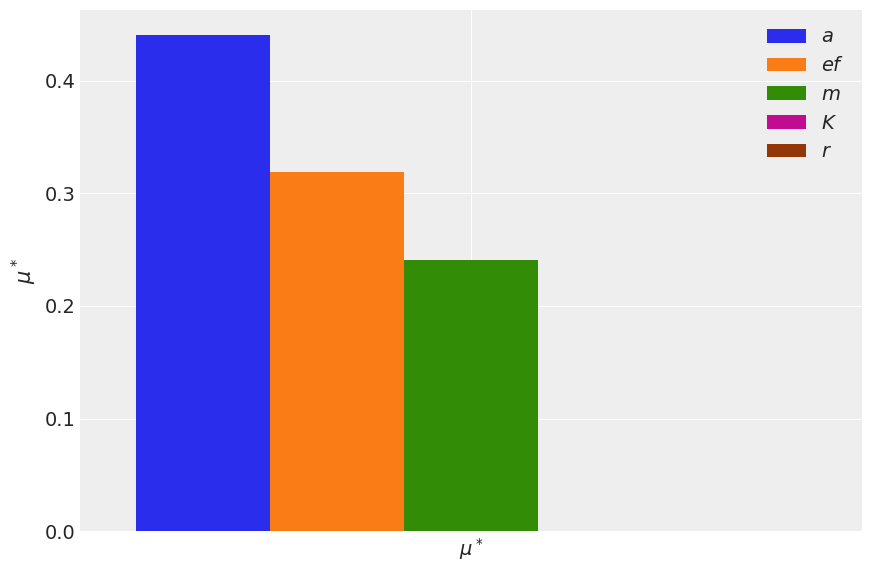

In [130]:
df_Si.T.plot.bar(rot=0, width=3, figsize=(9, 6))

plt.rcParams.update({'font.size': 16})

plt.ylabel(r"$\mu^*$")

plt.legend(fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/sensitivity_least_squares_LLV.png", dpi=300)
plt.show()

### SA on pest population

In [131]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)

num_of_realizations = parameter_values.shape[0]
num_of_time_points = time_range.shape[0]
qoi_sensitivity_outputs = np.zeros([num_of_realizations, num_of_time_points])

for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_LLV = LLV_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_LLV.y
    
    qoi_sensitivity_outputs[realization_index, :] = u_realization

100%|██████████| 24/24 [00:00<00:00, 161.12it/s]


In [132]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 114.14it/s]


Time          $r$          $K$       $a$       $ef$         $m$
0    1.404040  4.82803e-06  6.32316e-06  0.970917  0.0195046  0.00956684
1    1.808081  4.55725e-06  5.98969e-06  0.943977  0.0374906   0.0185215
2    2.212121  4.31077e-06  5.68739e-06  0.919385    0.05381   0.0267952
3    2.616162  4.08102e-06  5.40861e-06  0.896364  0.0693092   0.0343171
4    3.020202  3.86954e-06  5.15341e-06  0.874894   0.083543   0.0415535
..        ...          ...          ...       ...        ...         ...
94  39.383838  7.70561e-07  1.53307e-06  0.552985   0.243287    0.203725
95  39.787879  7.64693e-07  1.52794e-06  0.551702    0.24367    0.204626
96  40.191919  7.58897e-07  1.52288e-06   0.55043   0.244051    0.205517
97  40.595960  7.53162e-07  1.51809e-06  0.549167   0.244429    0.206401
98  41.000000  7.47493e-07  1.51347e-06  0.547916   0.244806    0.207276

[99 rows x 6 columns]

In [133]:
df_sigmai

Time          $r$          $K$       $a$      $ef$       $m$
0    1.404040  2.32023e-05  4.56676e-05  0.272307  0.544505  0.183118
1    1.808081  1.05911e-05  2.23868e-05  0.268264  0.546278  0.185425
2    2.212121  6.48839e-06  1.48413e-05  0.266196  0.546486  0.187296
3    2.616162  4.39674e-06  1.09733e-05  0.256546  0.554201  0.189237
4    3.020202  3.10835e-06  8.61291e-06  0.251382  0.556071  0.192535
..        ...          ...          ...       ...       ...       ...
94  39.383838  1.42257e-06  3.31013e-06   0.42249  0.311538  0.265967
95  39.787879  1.39802e-06  3.29507e-06  0.422994  0.310587  0.266414
96  40.191919  1.37438e-06  3.28112e-06  0.423481  0.309656  0.266858
97  40.595960  1.35154e-06  3.26767e-06   0.42395  0.308745    0.2673
98  41.000000  1.32947e-06    3.255e-06  0.424404  0.307854  0.267738

[99 rows x 6 columns]

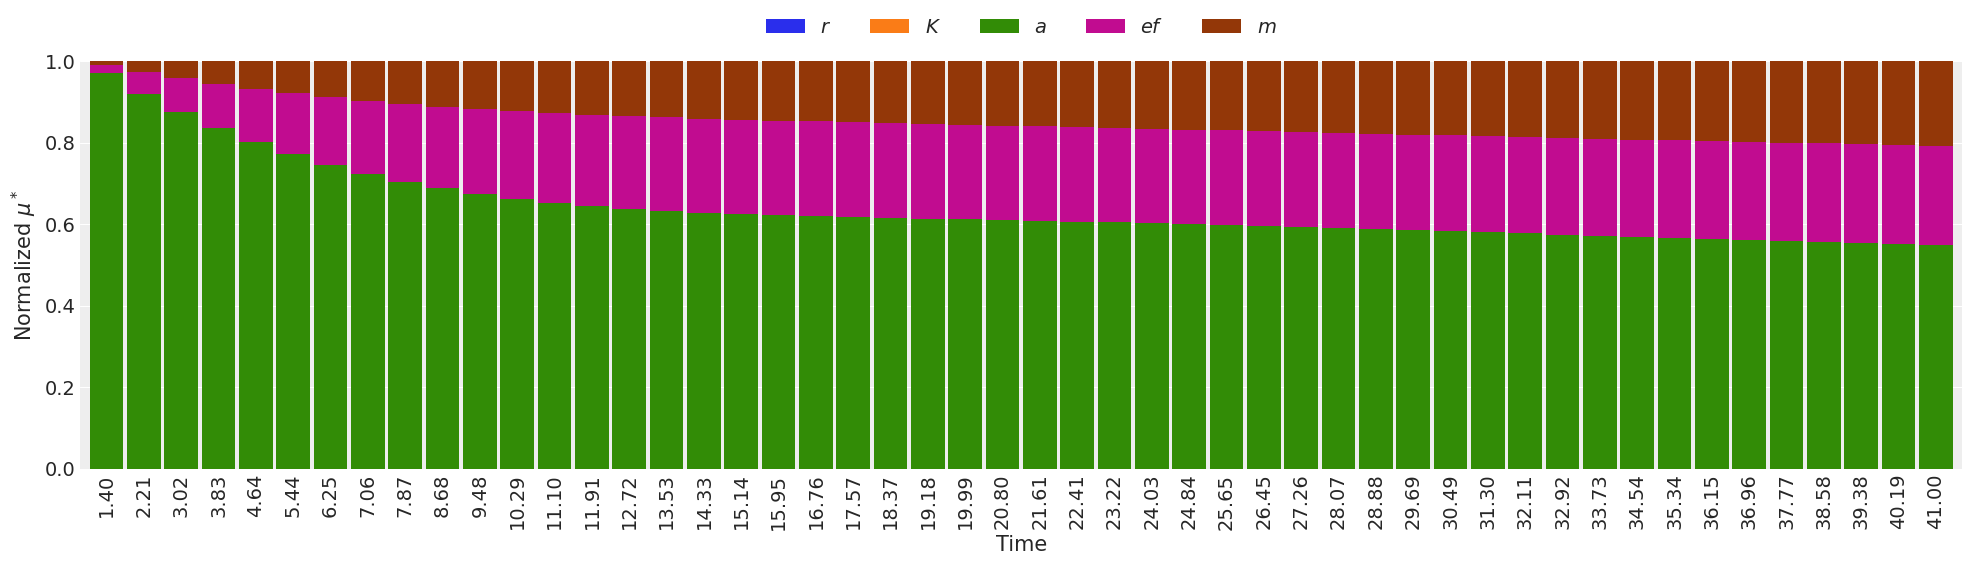

In [134]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_LLV.png", dpi=300)
plt.show()

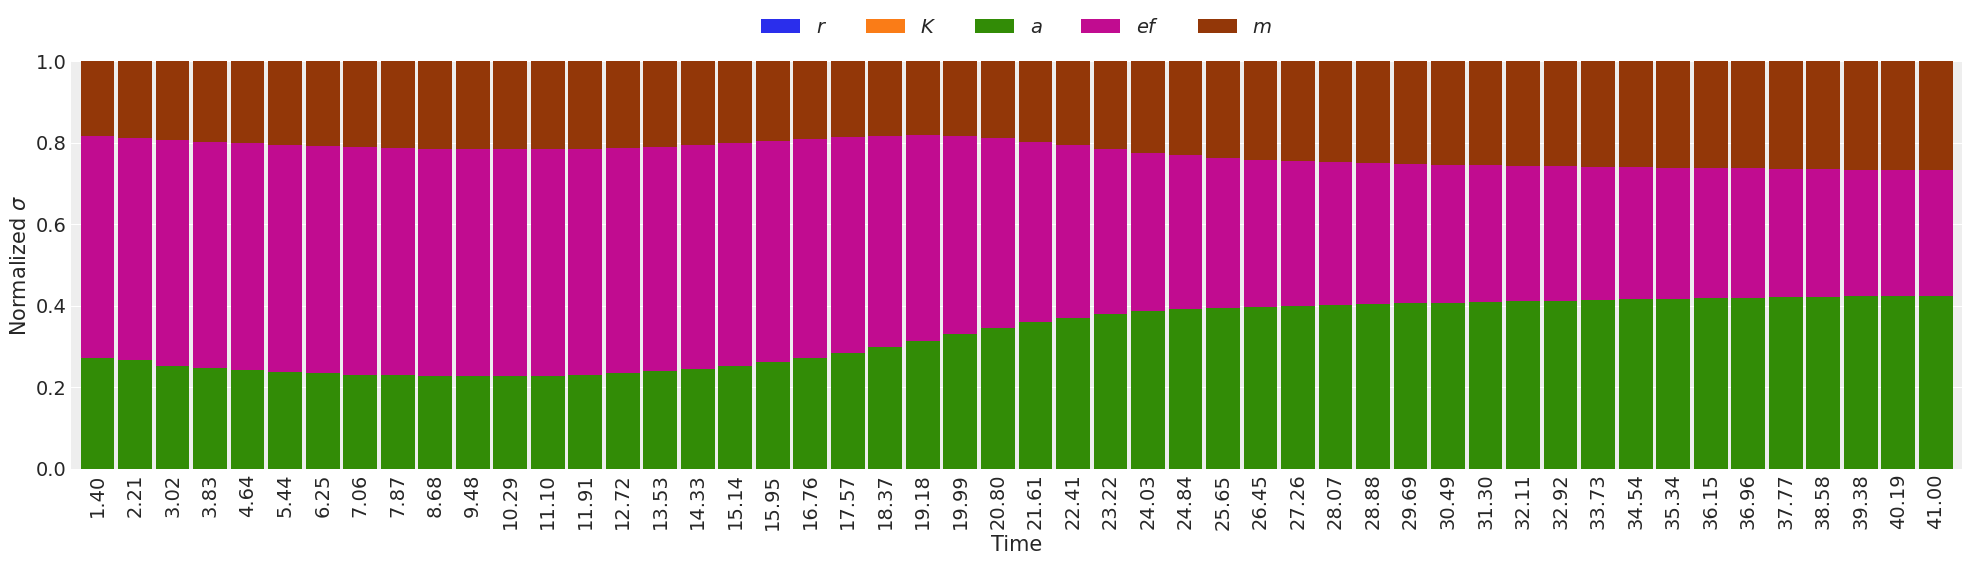

In [135]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_LLV.png", dpi=300)
plt.show()

### SA on time-derivative pest population

In [136]:
pest_time_derivative_array = calculate_pest_time_derivative_series(
    t_computed_LLV,
    u_LLV,
    v_LLV,
    LLV_model,
    mean_values_params
)

pest_time_derivative_array

array([-67.24380722, -67.83148441, -68.37471665, -68.87216388,
       -69.32965775, -69.74020856, -70.09812516, -70.40331515,
       -70.65578854, -70.85565692, -71.00313232, -71.09852597,
       -71.14224687, -71.13480012, -71.07678521, -70.96889394,
       -70.81190835, -70.60669836, -70.35421924, -70.05550896,
       -69.7116853 , -69.32394279, -68.89354954, -68.42184378,
       -67.91023035, -67.36017686, -66.77320982, -66.15091053,
       -65.49491074, -64.80688821, -64.08941268, -63.34417258,
       -62.57306008, -61.77818986, -60.96162244, -60.12536414,
       -59.27136699, -58.40152877, -57.51769294, -56.62164868,
       -55.71513086, -54.79982014, -53.87734296, -52.94927162,
       -52.01712437, -51.08236546, -50.1464053 , -49.21026321,
       -48.27540681, -47.34344533, -46.41544297, -45.49239898,
       -44.57524984, -43.66487149, -42.76208138, -41.8676406 ,
       -40.98225598, -40.10658206, -39.24122309, -38.38673503,
       -37.54362744, -36.71236536, -35.89337119, -35.08

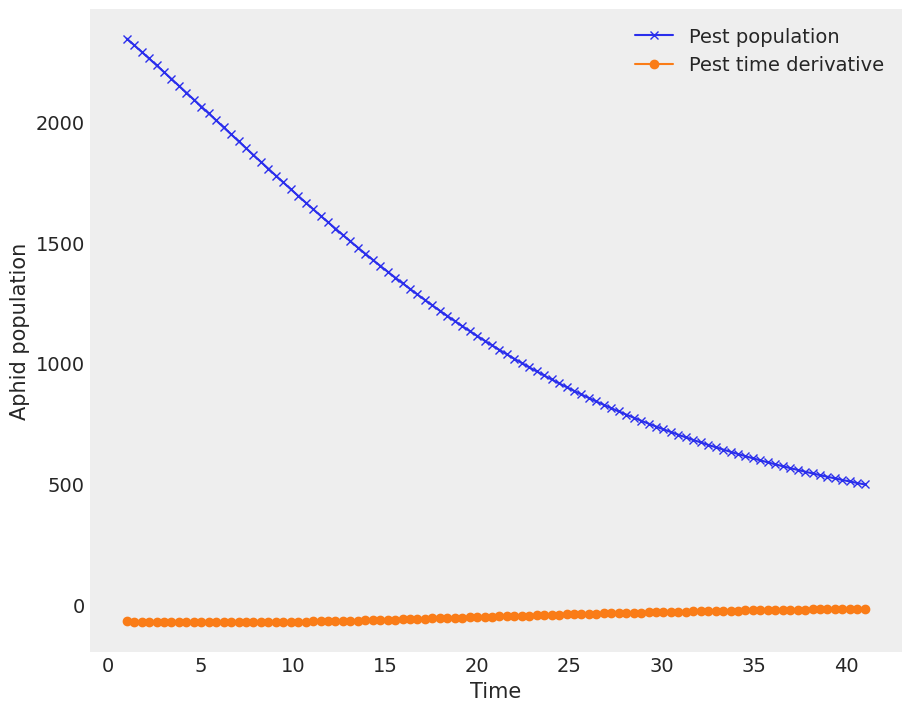

In [137]:
plt.figure(figsize=(9, 7))

plt.plot(t_computed_LLV, u_LLV, '-x', label='Pest population')
plt.plot(t_computed_LLV, pest_time_derivative_array, '-o', label='Pest time derivative')

plt.xlabel('Time')
plt.ylabel('Aphid population')

plt.grid()
plt.legend(shadow=True)

plt.savefig("img/pest_derivative_LLV.png", dpi=300)
plt.show()

In [138]:
for realization_index, parameters_realization in tqdm(enumerate(parameter_values), total=len(parameter_values)):
    
    realization_ODE_LLV = LLV_ode_solver(
        y0_BKM, 
        (t0, tf + days_to_forecast), 
        time_range, 
        *parameters_realization
    )
    
    u_realization, v_realization = realization_ODE_LLV.y
    
    pest_time_derivative_array = calculate_pest_time_derivative_series(
        time_range,
        u_realization,
        v_realization,
        LLV_model,
        parameters_realization
    )
    
    qoi_sensitivity_outputs[realization_index, :] = pest_time_derivative_array

100%|██████████| 24/24 [00:00<00:00, 109.03it/s]


In [139]:
df_Si = pd.DataFrame(columns=['Time', *problem_info['names']])
df_sigmai = pd.DataFrame(columns=['Time', *problem_info['names']])
df_Si['Time'] = time_range
df_sigmai['Time'] = time_range
for time_point in tqdm(range(num_of_time_points)):
    try:
        Si = ee_analyze(
            problem_info, 
            parameter_values, 
            qoi_sensitivity_outputs[:, time_point], 
            num_levels=grid_level, 
            seed=seed
        )
        Si['mu_star_normalized'] = Si['mu_star'] / Si['mu_star'].sum()
        sigmai_normalized = Si['sigma'] / Si['sigma'].sum()
        for idx, param_name in enumerate(problem_info['names']):
            df_Si.loc[time_point, param_name] = Si['mu_star_normalized'][idx]
            df_sigmai.loc[time_point, param_name] = sigmai_normalized[idx]
    except:
        continue

df_Si.sort_values(by='Time', inplace=True)
df_Si.drop(index=0, inplace=True)
df_Si.dropna(inplace=True)
df_Si.reset_index(drop=True, inplace=True)

df_sigmai.sort_values(by='Time', inplace=True)
df_sigmai.drop(index=0, inplace=True)
df_sigmai.dropna(inplace=True)
df_sigmai.reset_index(drop=True, inplace=True)

valid_times = df_Si.Time.values
df_Si

100%|██████████| 100/100 [00:00<00:00, 124.88it/s]


Time          $r$          $K$       $a$       $ef$        $m$
0    1.404040  4.55736e-06  5.98891e-06  0.944102  0.0374519  0.0184353
1    1.808081  4.07759e-06  5.40071e-06  0.896051  0.0694043  0.0345356
2    2.212121  3.66597e-06  4.90068e-06  0.854323  0.0969185  0.0487498
3    2.616162  3.30856e-06  4.47088e-06  0.817675   0.120885  0.0614313
4    3.020202  2.99535e-06  4.09834e-06  0.785218   0.141917  0.0728576
..        ...          ...          ...       ...        ...        ...
94  39.383838  1.12787e-06  2.21044e-06   0.34614   0.321986   0.331871
95  39.787879  1.15026e-06  2.22965e-06   0.34627   0.319812   0.333914
96  40.191919   1.1725e-06  2.24877e-06  0.346356    0.31769   0.335951
97  40.595960  1.19451e-06  2.26832e-06  0.346398   0.315619    0.33798
98  41.000000   1.2163e-06  2.28796e-06  0.346396   0.313598   0.340002

[99 rows x 6 columns]

In [140]:
df_sigmai

Time          $r$          $K$       $a$      $ef$       $m$
0    1.404040  1.06902e-05  2.25418e-05  0.270315  0.545394  0.184258
1    1.808081  4.40121e-06  1.09399e-05  0.264149  0.548049  0.187787
2    2.212121  2.34578e-06  7.12037e-06  0.258462  0.550298  0.191231
3    2.616162  1.38845e-06  5.23737e-06  0.252579  0.552668  0.194746
4    3.020202   9.4636e-07  4.12967e-06   0.24702  0.554703  0.198271
..        ...          ...          ...       ...       ...       ...
94  39.383838  6.02695e-07  1.82361e-06  0.424963  0.278941  0.296094
95  39.787879  6.13467e-07  1.83734e-06  0.424931  0.277505  0.297562
96  40.191919  6.24461e-07  1.85148e-06  0.424817  0.276139  0.299042
97  40.595960  6.35583e-07  1.86633e-06  0.424622   0.27484  0.300535
98  41.000000  6.46847e-07  1.88172e-06   0.42435  0.273608  0.302039

[99 rows x 6 columns]

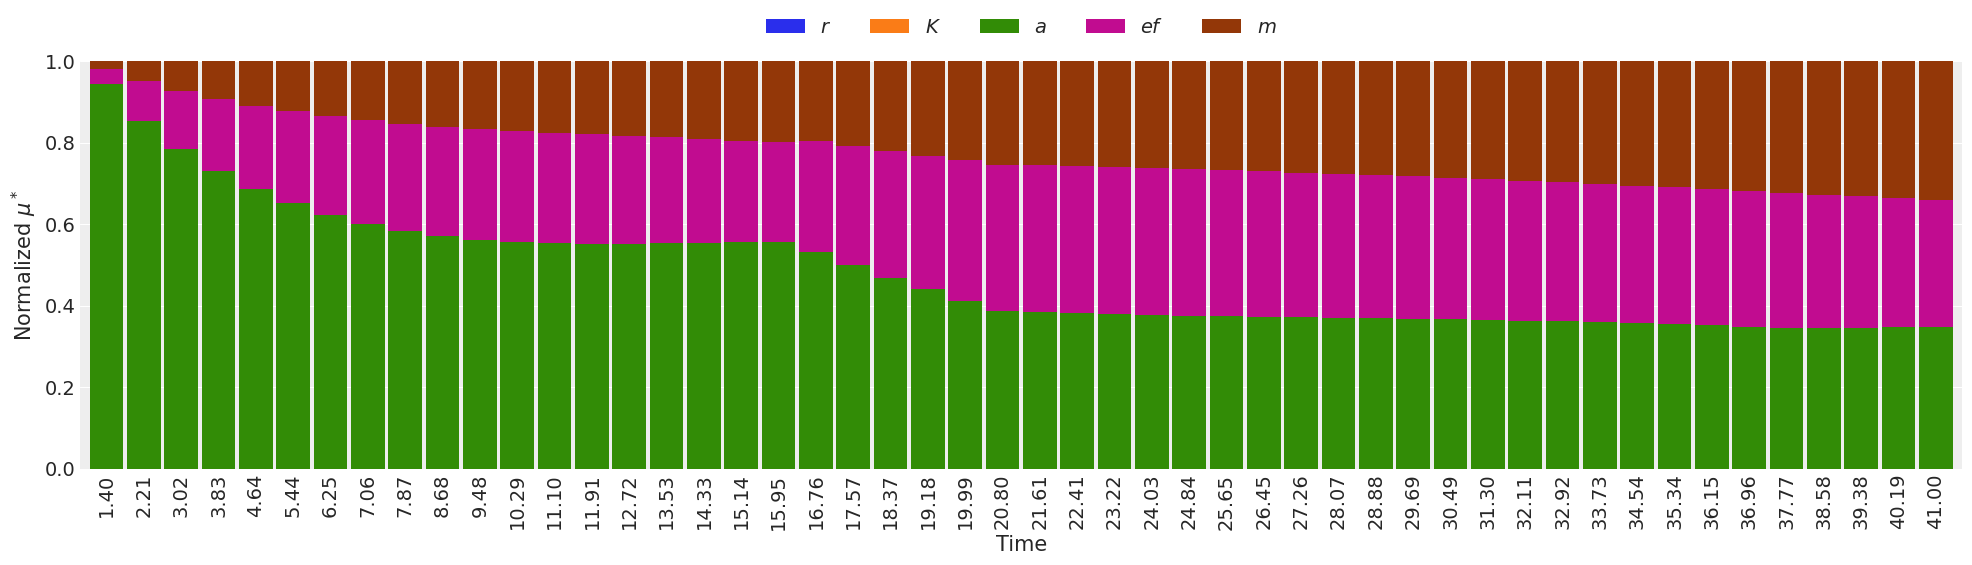

In [141]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_mu = valid_times[::step_to_plot]
df_Si[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_mu[x]:.2f}")
plt.ylabel(r"Normalized $\mu^*$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_derivative_LLV.png", dpi=300)
plt.show()

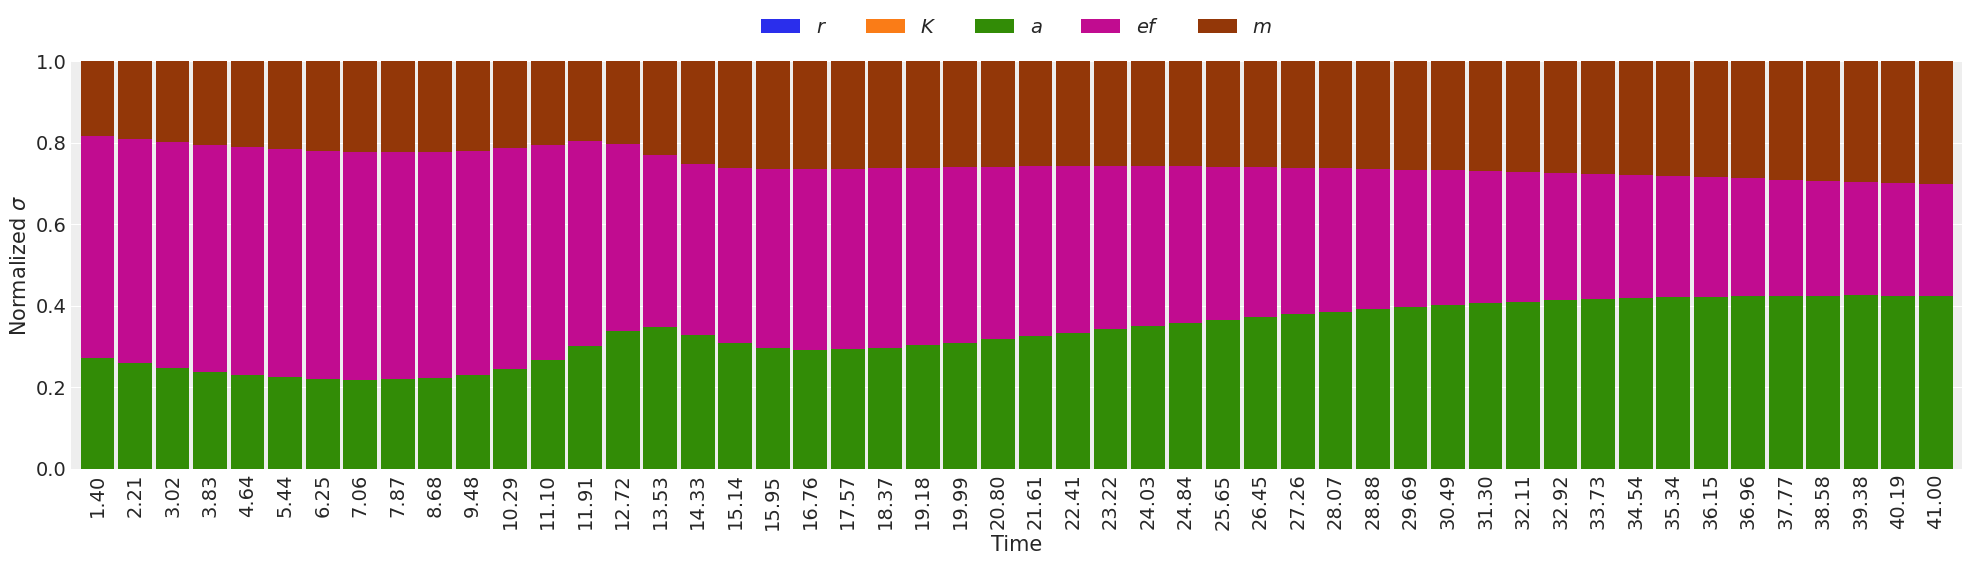

In [142]:
fig = plt.figure()
ax = plt.subplot(111)
step_to_plot = 2
valid_times_to_plot_sigma = valid_times[::step_to_plot]
df_sigmai[::step_to_plot].plot.bar(x='Time', rot=90, width=0.9, figsize=(20, 6), stacked=True, ax=ax)
ax.xaxis.set_major_formatter(lambda x, pos: f"{valid_times_to_plot_sigma[x]:.2f}")
plt.ylabel(r"Normalized $\sigma$")

plt.ylim([0, 1])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(problem_info['names']), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/SA_pest_pop_sigma_derivative_LLV.png", dpi=300)
plt.show()

## Bayesian calibration

In [143]:
@theano.compile.ops.as_op(
    itypes=[
        t.dvector, 
        t.dscalar,  # r
        t.dscalar,  # K
        t.dscalar,  # a
        t.dscalar,  # ef
        t.dscalar,  # m
        t.dscalar,  # u0
        t.dscalar,  # v0
    ], 
    otypes=[t.dmatrix]
)
def LLV_ode_wrapper(time_exp, r, K, a, ef, m, u0, v0):
    time_span = (time_exp.min(), time_exp.max())

    args = [r, K, a, ef, m,]
    initial_conditions = np.array([u0, v0])
    y_model = solve_ivp(
        LLV_model, 
        time_span, 
        initial_conditions, 
        t_eval=time_exp, 
        method='LSODA',
        args=args
    )
    simulated_time = y_model.t
    simulated_ode_solution = y_model.y
    simulated_qoi1, simulated_qoi2 = simulated_ode_solution

    concatenate_simulated_qoi = np.vstack([simulated_qoi1, simulated_qoi2]).T

    return concatenate_simulated_qoi

In [144]:
observed_aphids_fine = aphid_observed.Density.values.astype(np.float64)
observed_ladybeetles_fine = ladybeetle_observed.Density.values.astype(np.float64)
observations_to_fit_fine = np.vstack([observed_aphids_fine, observed_ladybeetles_fine]).T
time_observations_fine = aphid_data.Time.values.astype(np.float64)

print("\n*** Performing Bayesian calibration ***")

print("-- Running Monte Carlo simulations:")
draws = 1000
start_time = time.time()
percent_calibration = 0.95
with pm.Model() as fine_model_LLV:
    # Prior distributions for the model's parameters
    r_ = pm.Data("r", r_deterministic)  
    K_ = pm.Data("K", K_deterministic)  
    a_ = pm.Uniform(
        "a", 
        lower=(1.0 - percent_calibration) * a_deterministic, 
        upper=(1.0 + 1.5 * percent_calibration) * a_deterministic,
    )
    ef_ = pm.Uniform(
        "ef",
        lower=0, 
        upper=(1.0 + percent_calibration) * ef_deterministic,
    )
    m_ = pm.Uniform(
        "m", 
        lower=(1.0 - percent_calibration) * m_deterministic, 
        upper=(1.0 + percent_calibration) * m_deterministic,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_fine)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "LLV_model",
        LLV_ode_wrapper(
            time_calibration,
            r_,
            K_,
            a_,
            ef_,
            m_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_fine
    )


coarse_step = 4
observed_aphids_coarse = observed_aphids_fine[::coarse_step]
observed_ladybeetles_coarse = observed_ladybeetles_fine[::coarse_step]
observations_to_fit_coarse = np.vstack([observed_aphids_coarse, observed_ladybeetles_coarse]).T
time_observations_coarse = time_observations_fine[::coarse_step]
with pm.Model() as coarse_model_LLV:
    # Prior distributions for the model's parameters
    r_ = pm.Data("r", r_deterministic)  
    K_ = pm.Data("K", K_deterministic)  
    a_ = pm.Uniform(
        "a", 
        lower=(1.0 - percent_calibration) * a_deterministic, 
        upper=(1.0 + 1.5 * percent_calibration) * a_deterministic,
    )
    ef_ = pm.Uniform(
        "ef",
        lower=0, 
        upper=(1.0 + percent_calibration) * ef_deterministic,
    )
    m_ = pm.Uniform(
        "m", 
        lower=(1.0 - percent_calibration) * m_deterministic, 
        upper=(1.0 + percent_calibration) * m_deterministic,
    )
    
    # Prioris for Initial Conditions
    u0, v0 = y0_BKM
    u0_ = pm.Data("u0", u0)
    v0_ = pm.Data("v0", v0)

    standard_deviation = pm.Uniform("std_deviation", lower=0, upper=1000, shape=2)  # note 'shape' here

    # Wrapper for time. We need it this way in order to change it for predictions
    time_calibration = pm.Data("time", time_observations_coarse)

    # Defining the deterministic formulation of the problem
    fitting_model = pm.Deterministic(
        "LLV_model",
        LLV_ode_wrapper(
            time_calibration,
            r_,
            K_,
            a_,
            ef_,
            m_,
            u0_,
            v0_
        ),
    )
    
    likelihood_model = pm.Normal(
        "likelihood_model", mu=fitting_model, sigma=standard_deviation, observed=observations_to_fit_coarse
    )

    
with fine_model_LLV:
    step = pm.MLDA(coarse_models=[coarse_model_LLV], subsampling_rates=[5])
#     step = pm.DEMetropolisZ()
    trace_calibration_LLV = pm.sample(draws=4500, chains=4, cores=4, tune=1000, step=step, random_seed=seed)
    
duration = time.time() - start_time

print(f"-- Monte Carlo simulations done in {duration / 60:.3f} minutes")


*** Performing Bayesian calibration ***
-- Running Monte Carlo simulations:


Multiprocess sampling (4 chains in 4 jobs)
MLDA: [std_deviation, m, ef, a]


Sampling 4 chains for 1_000 tune and 4_500 draw iterations (4_000 + 18_000 draws total) took 442 seconds.
The number of effective samples is smaller than 10% for some parameters.


-- Monte Carlo simulations done in 8.094 minutes


In [145]:
calibration_variable_names = [
    "std_deviation",
    "a",
    "ef",
    "m",
]

100%|██████████| 4/4 [02:07<00:00, 31.84s/it]


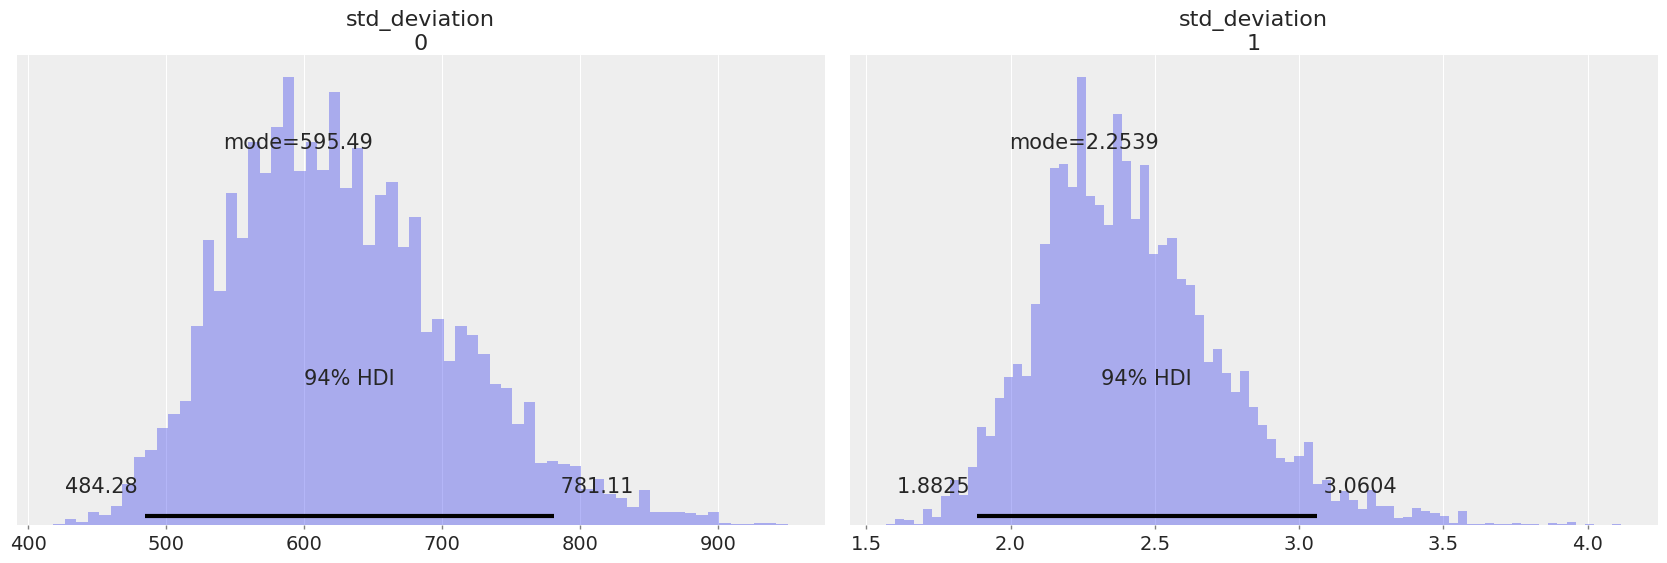

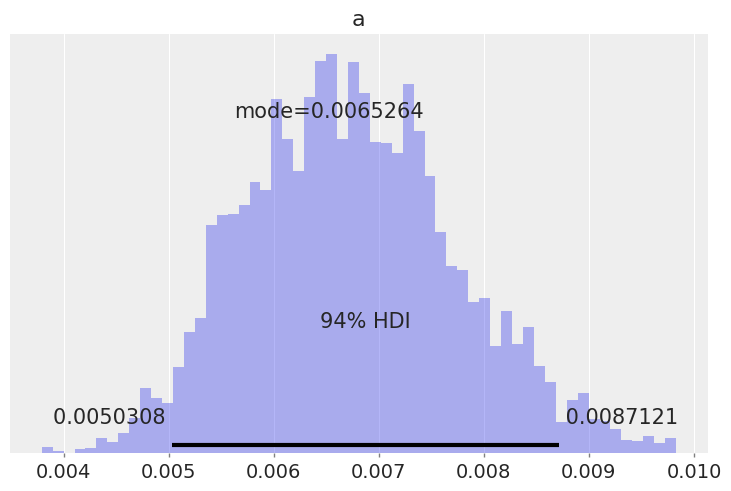

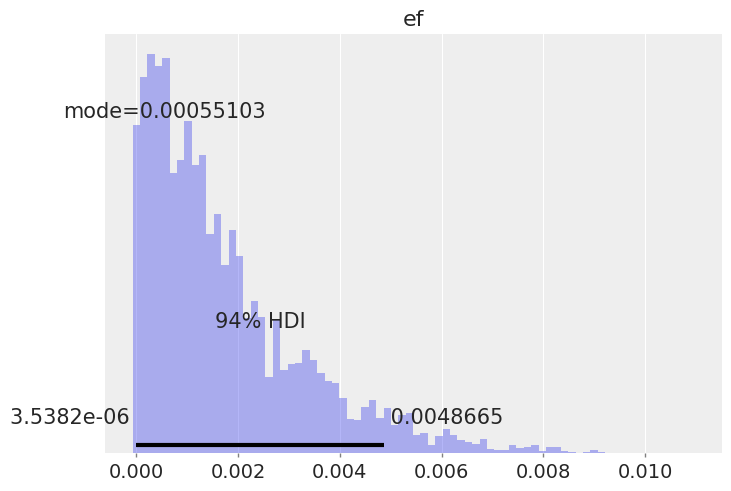

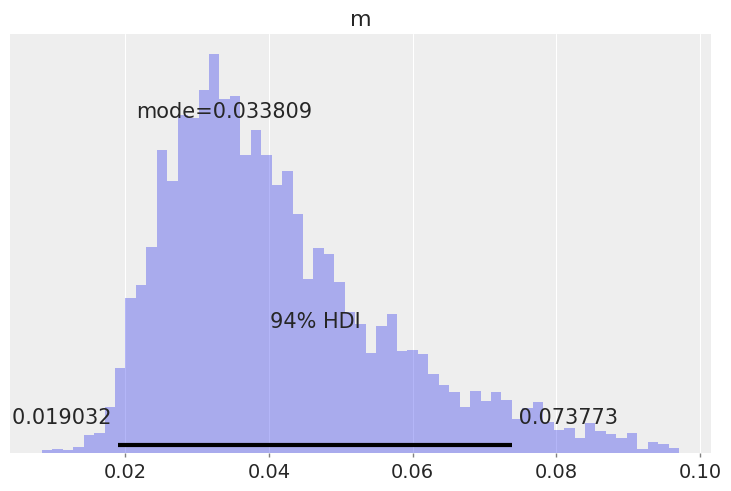

In [146]:
plot_step = 1
progress_bar = tqdm(calibration_variable_names)
for variable in progress_bar:
    pm.plot_posterior(
        trace_calibration_LLV[::plot_step], 
        var_names=(f"{variable}"), 
        kind="hist", 
        round_to=5,
        point_estimate="mode"
    )
    plt.savefig(f"img/{variable}_posterior_cal_LLV.png")

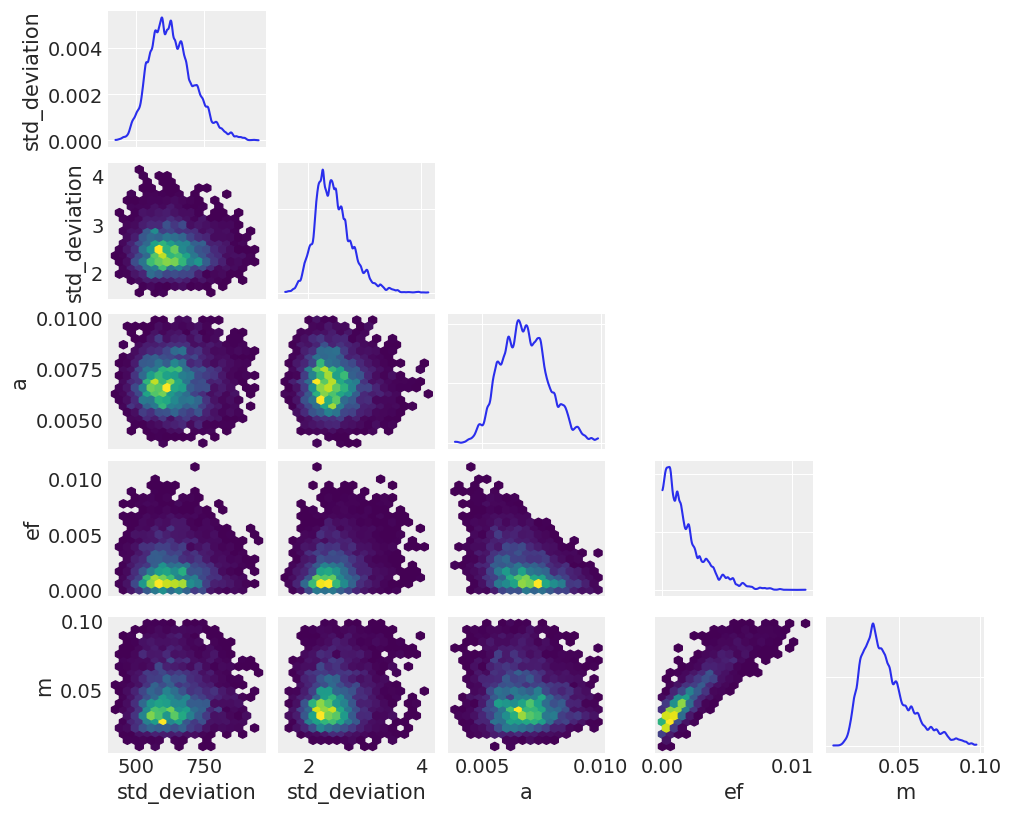

In [147]:
az.plot_pair(
    trace_calibration_LLV,
    var_names=calibration_variable_names,
    kind="hexbin",
    fill_last=False,
    marginals=True,
    figsize=(10, 8),
)
plt.savefig("img/marginals_cal_LLV.png")

In [148]:
df_stats_summary = az.summary(
    data=trace_calibration_LLV,
    var_names=calibration_variable_names,
    kind='stats',
    round_to=15,  # arredondamento de ponto flutuante no sumário
)

df_stats_summary

mean         sd      hdi_3%     hdi_97%
std_deviation[0]  632.850051  81.060972  484.281826  781.105716
std_deviation[1]    2.438887   0.323823    1.882505    3.060425
a                   0.006798   0.000998    0.005031    0.008712
ef                  0.001814   0.001579    0.000004    0.004866
m                   0.042072   0.015522    0.019032    0.073773

In [149]:
calibration_variable_mpv = calculate_rv_posterior_mpv(
    pm_trace=trace_calibration_LLV, variable_names=calibration_variable_names
)
df_stats_summary = add_mpv_to_summary(df_stats_summary, calibration_variable_mpv)
df_stats_summary.to_csv("stats_summary_calibration_LLV.csv")  # salvando em um csv para consultas

df_stats_summary

Calculating MPV from KDE for m: 100%|██████████| 4/4 [00:39<00:00,  9.95s/it]            


mean         sd      hdi_3%     hdi_97%         mpv
std_deviation[0]  632.850051  81.060972  484.281826  781.105716  593.172147
std_deviation[1]    2.438887   0.323823    1.882505    3.060425    2.241704
a                   0.006798   0.000998    0.005031    0.008712    0.006591
ef                  0.001814   0.001579    0.000004    0.004866    0.000488
m                   0.042072   0.015522    0.019032    0.073773    0.033585

In [150]:
percentile_cut = 2.5

y_min = np.percentile(trace_calibration_LLV["LLV_model"], percentile_cut, axis=0)
y_max = np.percentile(trace_calibration_LLV["LLV_model"], 100 - percentile_cut, axis=0)
y_fit = np.percentile(trace_calibration_LLV["LLV_model"], 50, axis=0)

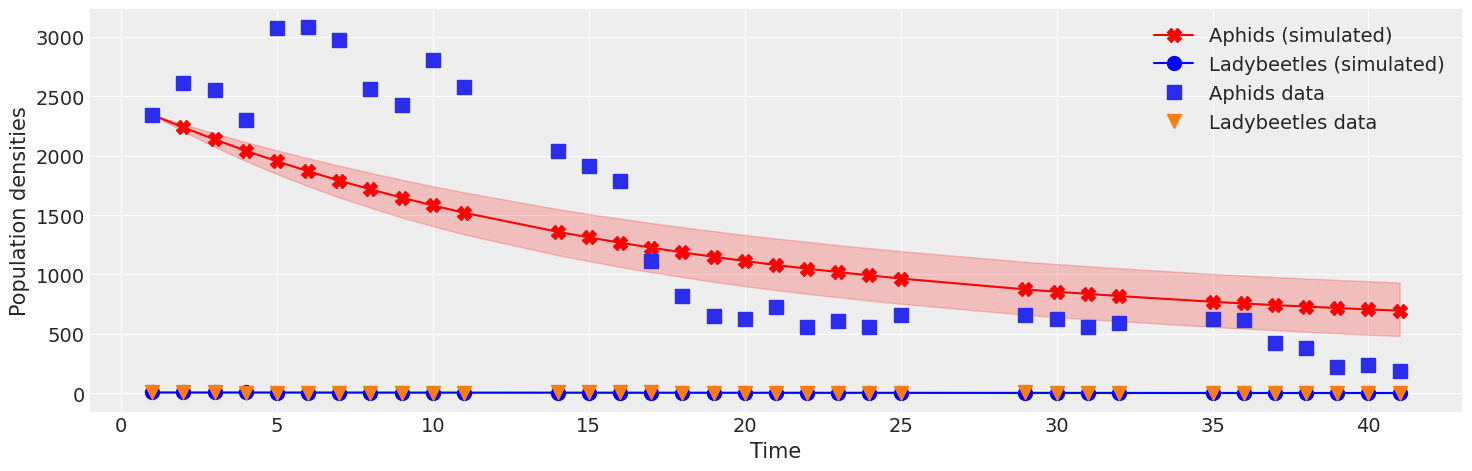

In [151]:
plt.figure(figsize=(15, 5))

plt.plot(
    time_observations,
    y_fit[:, 0],
    "r",
    label="Aphids (simulated)",
    marker="X",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 0], y_max[:, 0], color="r", alpha=0.2)

plt.plot(
    time_observations,
    y_fit[:, 1],
    "b",
    label="Ladybeetles (simulated)",
    marker="o",
    linestyle="-",
    markersize=10,
)
plt.fill_between(time_observations, y_min[:, 1], y_max[:, 1], color="b", alpha=0.2)

plt.plot(
    time_observations, 
    aphid_observed.Density.values, 
    label="Aphids data", 
    marker="s", 
    linestyle="", 
    markersize=10
)
plt.plot(
    time_observations, 
    ladybeetle_observed.Density.values, 
    label="Ladybeetles data", 
    marker="v", 
    linestyle="", 
    markersize=10
)

plt.legend(shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Population densities', fontsize=15)

plt.tight_layout()
plt.savefig("img/calibration_LLV.png", dpi=300)
plt.show()

In [152]:
print("-- Exporting calibrated parameter to CSV")

start_time = time.time()

dict_realizations = dict()  # vamos gravar as realizações em um dicionário Python tbm
progress_bar = tqdm(calibration_variable_names[1:])
for variable in progress_bar:
    progress_bar.set_description(f"Gathering {variable} realizations")
    parameter_realization = trace_calibration_LLV.get_values(f"{variable}")
    dict_realizations[f"{variable}"] = parameter_realization

df_realizations = pd.DataFrame(dict_realizations)
df_realizations.to_csv("calibration_realizations_LLV.csv")

duration = time.time() - start_time

print(f"-- Exported done in {duration:.3f} seconds")

Gathering m realizations: 100%|██████████| 3/3 [00:00<00:00, 565.22it/s]

-- Exporting calibrated parameter to CSV
-- Exported done in 0.169 seconds


In [153]:
df_realizations

a        ef         m
0      0.008082  0.001206  0.046870
1      0.008082  0.001206  0.046870
2      0.008082  0.001206  0.046870
3      0.008082  0.001206  0.046870
4      0.008082  0.001206  0.046870
...         ...       ...       ...
17995  0.005789  0.004615  0.059094
17996  0.006717  0.001322  0.032000
17997  0.006717  0.001322  0.032000
17998  0.007395  0.002636  0.046456
17999  0.007395  0.002636  0.046456

[18000 rows x 3 columns]

# Model comparison/selection

## From PyMC3

Check [this example](https://docs.pymc.io/pymc-examples/examples/diagnostics_and_criticism/model_comparison.html) for further information.

TL;DR: The "score", which is "loo" or "waic" in the printed dataframe bellow, should the greatest for the best model. The `weight` is one of the most important information, because it loosely tell the probability of the model to be the "correct one" among all the compared models.

In [154]:
print("\n*** Performing model comparison ***")
start_time = time.time()

models_to_compare = {
    "BKMA": trace_calibration_BKMA,
    "BKMC": trace_calibration_BKMC,
    "PPLK": trace_calibration_PPLK,
    "LLV": trace_calibration_LLV,
}

# Choose ic='loo' or ic='waic'
df_model_comparison = pm.compare(
    models_to_compare, 
    ic='loo',
    method='BB-pseudo-BMA',
    b_samples=3000,
    seed=seed
)

duration = time.time() - start_time

print(f"-- Model comparison done in {duration / 60:.3f} minutes")

df_model_comparison


*** Performing model comparison ***
-- Model comparison done in 5.420 minutes


rank         loo     p_loo      d_loo    weight         se       dse  \
BKMA     0 -329.745935  3.803274   0.000000  0.696825  17.789778  0.000000   
PPLK     1 -330.764737  3.787789   1.018802  0.278812  15.053421  0.685337   
BKMC     2 -345.063150  5.087670  15.317215  0.006886  17.822357  6.296028   
LLV      3 -345.959490  2.840877  16.213555  0.017477  23.485579  7.995423   

      warning loo_scale  
BKMA    False       log  
PPLK    False       log  
BKMC     True       log  
LLV     False       log

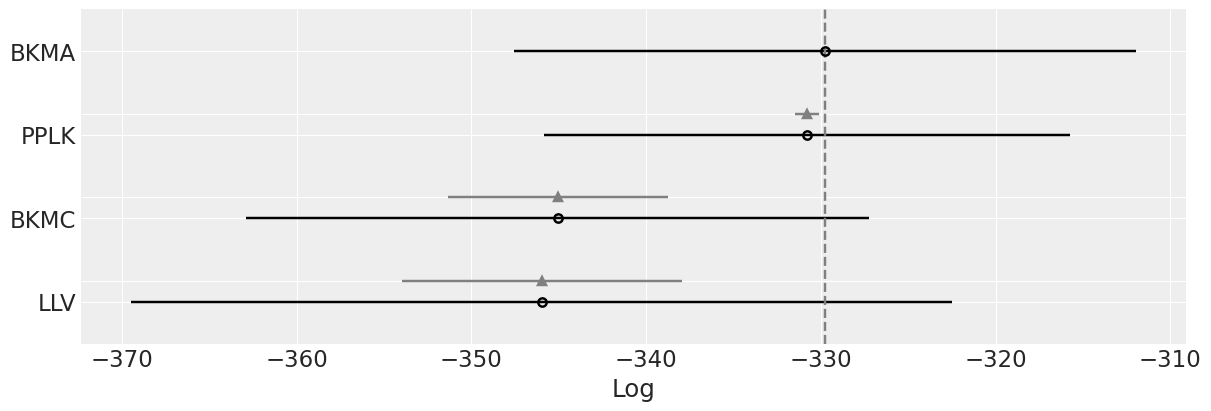

In [155]:
az.plot_compare(df_model_comparison, figsize=(12, 4), insample_dev=False)

plt.show()

## Custom (and basic) information criteria

The criteria employed here are:

* AIC -- Akaike Information Criterion
* BIC -- Bayesian Information Criterion

Both ICs are based on the residual of least squares. This approach has as hypothesis that the error residuals, i.e., $\sum_{i = 1}^n (y^{\text{obs}}_i - y^{\text{model}}_i)^2$, are independent identical normal, with zero mean.

An auxiliary quantity is defined in order to compare the models (relative to the best one):

\begin{equation}
\mathcal{L}^{\text{rel}}_i := \exp{\left(\frac{\text{IC}_{\text{min}} - \text{IC}_i}{2}\right)}
\end{equation}

where $\text{IC}_i$ is the information criterion value (it can be AIC or BIC) for the $i$th model, and $\text{IC}_{\text{min}}$ is the minimum (i.e., the best model) information criterion value from the set of compared models.

This auxiliary quantity is known as "relative likelihood". It is proportional to the probability that the $i$th model minimizes the information loss. For the best model, this value will be always equal to 1.

In [156]:
def calculate_aic_score(trace, rv_model_name, num_of_parameters, observations):
    u_observed, v_observed = observations.T
    k = num_of_parameters
    n = observations.shape[0]
    aic_scores = list()
    progress_bar = tqdm(trace[rv_model_name])
    for model_realization in progress_bar:
        progress_bar.set_description(f"Calculating AIC for {rv_model_name}")
        u_realization, v_realization = model_realization.T
        u_realization_residual = u_observed - u_realization
        v_realization_residual = v_observed - v_realization
        u_residual_sum_of_squares = np.sum(u_realization_residual * u_realization_residual)
        v_residual_sum_of_squares = np.sum(v_realization_residual * v_realization_residual)
        total_residual_sum_of_squares = u_residual_sum_of_squares + v_residual_sum_of_squares
        
        # Information criterion in terms of least-squares error residuals
        realization_aic_score = 2 * k + n * np.log(total_residual_sum_of_squares)
        aic_scores.append(realization_aic_score)

    aic_scores = np.array(aic_scores)
    return aic_scores


def calculate_aicc_score(trace, rv_model_name, num_of_parameters, observations):
    u_observed, v_observed = observations.T
    k = num_of_parameters
    n = observations.shape[0]
    aic_scores = list()
    progress_bar = tqdm(trace[rv_model_name])
    for model_realization in progress_bar:
        progress_bar.set_description(f"Calculating AICc for {rv_model_name}")
        u_realization, v_realization = model_realization.T
        u_realization_residual = u_observed - u_realization
        v_realization_residual = v_observed - v_realization
        u_residual_sum_of_squares = np.sum(u_realization_residual * u_realization_residual)
        v_residual_sum_of_squares = np.sum(v_realization_residual * v_realization_residual)
        total_residual_sum_of_squares = u_residual_sum_of_squares + v_residual_sum_of_squares
        
        # Information criterion in terms of least-squares error residuals
        realization_aic_score = 2 * k + n * np.log(total_residual_sum_of_squares)
        realization_aic_score += 2 * (k * k + k) / (n - k - 1)
        aic_scores.append(realization_aic_score)

    aic_scores = np.array(aic_scores)
    return aic_scores



def calculate_bic_score(trace, rv_model_name, num_of_parameters, observations):
    u_observed, v_observed = observations.T
    k = num_of_parameters
    n = observations.shape[0]
    bic_scores = list()
    progress_bar = tqdm(trace[rv_model_name])
    for model_realization in progress_bar:
        progress_bar.set_description(f"Calculating BIC for {rv_model_name}")
        u_realization, v_realization = model_realization.T
        u_realization_residual = u_observed - u_realization
        v_realization_residual = v_observed - v_realization
        u_residual_sum_of_squares = np.sum(u_realization_residual * u_realization_residual)
        v_residual_sum_of_squares = np.sum(v_realization_residual * v_realization_residual)
        total_residual_sum_of_squares = u_residual_sum_of_squares + v_residual_sum_of_squares
        
        # Information criterion in terms of least-squares error residuals
        realization_bic_score = k * np.log(n) + n * np.log(total_residual_sum_of_squares / n)
        bic_scores.append(realization_bic_score)

    bic_scores = np.array(bic_scores)
    return bic_scores

In [157]:
aic_scores = calculate_aic_score(trace_calibration_BKMA, 'BKMA_model', 5, observations_to_fit)
aic_mpv = _scalar_rv_mvp_estimation(aic_scores)

Calculating AIC for BKMA_model: 100%|██████████| 18000/18000 [00:32<00:00, 556.93it/s]


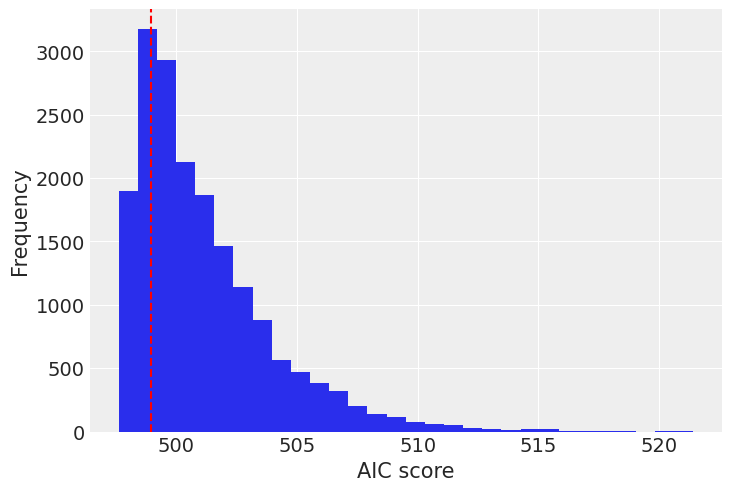

In [158]:
plt.hist(aic_scores, bins=30)
plt.axvline(x=aic_mpv, color='red', linestyle='--')
plt.xlabel("AIC score")
plt.ylabel("Frequency")

plt.show()

In [159]:
aicc_scores = calculate_aicc_score(trace_calibration_BKMA, 'BKMA_model', 5, observations_to_fit)
aicc_mpv = _scalar_rv_mvp_estimation(aicc_scores)

Calculating AICc for BKMA_model: 100%|██████████| 18000/18000 [00:30<00:00, 586.15it/s]


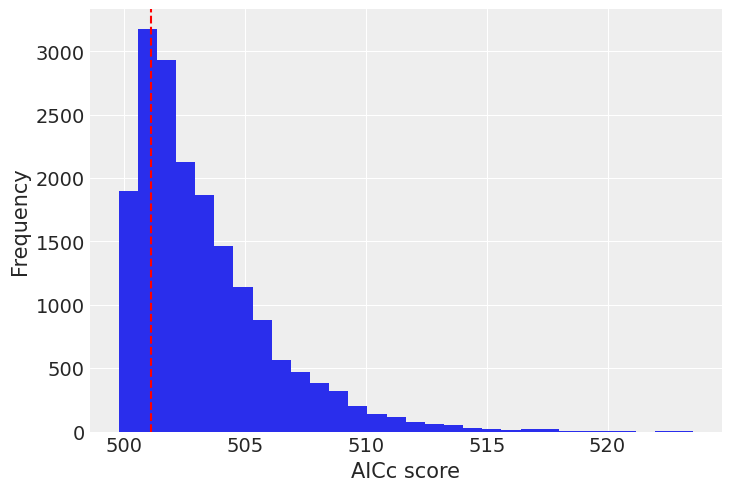

In [160]:
plt.hist(aicc_scores, bins=30)
plt.axvline(x=aicc_mpv, color='red', linestyle='--')
plt.xlabel("AICc score")
plt.ylabel("Frequency")

plt.show()

In [161]:
bic_scores = calculate_bic_score(trace_calibration_BKMA, 'BKMA_model', 5, observations_to_fit)
bic_mpv = _scalar_rv_mvp_estimation(bic_scores)

Calculating BIC for BKMA_model: 100%|██████████| 18000/18000 [00:40<00:00, 445.14it/s]


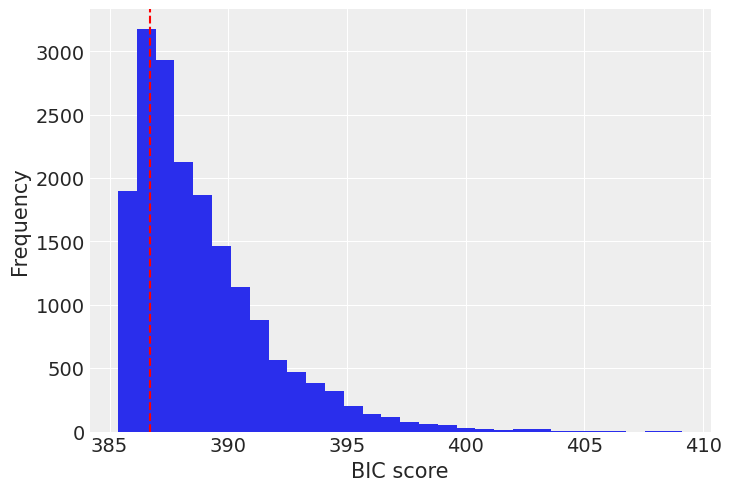

In [162]:
plt.hist(bic_scores, bins=30)
plt.axvline(bic_mpv, color='red', linestyle='--')
plt.xlabel("BIC score")
plt.ylabel("Frequency")

plt.show()

Now we define convenient functions to compare models according to the ICs.

In [173]:
def compare_aic(
    models_to_compare: dict, 
    models_num_of_parameters: dict, 
    observations: np.ndarray
) -> pd.DataFrame:
    compare_result = {
        'model': list(),
        'AIC': list(),
    }
    for model_name in models_to_compare:
        model_trace = models_to_compare[model_name]
        model_num_of_parameters = models_num_of_parameters[model_name]
        model_aic_scores = calculate_aic_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_aic_mpv = _scalar_rv_mvp_estimation(model_aic_scores)
        compare_result['model'].append(model_name)
        compare_result['AIC'].append(model_aic_mpv)
    
    df_compare_results = pd.DataFrame(compare_result)
    df_compare_results.set_index('model', inplace=True)
    df_compare_results.sort_values(by=['AIC'], ascending=True, inplace=True)
    return df_compare_results


def compare_aicc(
    models_to_compare: dict, 
    models_num_of_parameters: dict, 
    observations: np.ndarray
) -> pd.DataFrame:
    compare_result = {
        'model': list(),
        'AICc': list(),
    }
    for model_name in models_to_compare:
        model_trace = models_to_compare[model_name]
        model_num_of_parameters = models_num_of_parameters[model_name]
        model_aicc_scores = calculate_aicc_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_aicc_mpv = _scalar_rv_mvp_estimation(model_aicc_scores)
        compare_result['model'].append(model_name)
        compare_result['AICc'].append(model_aicc_mpv)
    
    df_compare_results = pd.DataFrame(compare_result)
    df_compare_results.set_index('model', inplace=True)
    df_compare_results.sort_values(by=['AICc'], ascending=True, inplace=True)
    return df_compare_results


def compare_bic(
    models_to_compare: dict, 
    models_num_of_parameters: dict, 
    observations: np.ndarray
) -> pd.DataFrame:
    compare_result = {
        'model': list(),
        'BIC': list(),
    }
    for model_name in models_to_compare:
        model_trace = models_to_compare[model_name]
        model_num_of_parameters = models_num_of_parameters[model_name]
        model_bic_scores = calculate_bic_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_bic_mpv = _scalar_rv_mvp_estimation(model_bic_scores)
        compare_result['model'].append(model_name)
        compare_result['BIC'].append(model_bic_mpv)
    
    df_compare_results = pd.DataFrame(compare_result)
    df_compare_results.set_index('model', inplace=True)
    df_compare_results.sort_values(by=['BIC'], ascending=True, inplace=True)
    return df_compare_results


def compare_ic(
    models_to_compare: dict, 
    models_num_of_parameters: dict, 
    observations: np.ndarray,
    ic_to_sort: str = 'AIC'
) -> pd.DataFrame:
    # Dict to store results
    compare_result = {
        'model': list(),
        'AIC': list(),
        'AICc': list(),
        'BIC': list(),
    }
    
    # Calculate Information Criteria
    for model_name in models_to_compare:
        compare_result['model'].append(model_name)
        model_trace = models_to_compare[model_name]
        model_num_of_parameters = models_num_of_parameters[model_name]
        
        # Compute AIC score
        model_aic_scores = calculate_aic_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_aic_mpv = _scalar_rv_mvp_estimation(model_aic_scores)
        compare_result['AIC'].append(model_aic_mpv)
        
        # Compute AICc score
        model_aicc_scores = calculate_aicc_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_aicc_mpv = _scalar_rv_mvp_estimation(model_aicc_scores)
        compare_result['AICc'].append(model_aicc_mpv)
        
        # Compute BIC score
        model_bic_scores = calculate_bic_score(
            model_trace, 
            model_name, 
            model_num_of_parameters, 
            observations
        )
        model_bic_mpv = _scalar_rv_mvp_estimation(model_bic_scores)
        compare_result['BIC'].append(model_bic_mpv)
        
    # Gathering results in a DataFrame
    df_compare_results = pd.DataFrame(compare_result)
    
    # Calculate relative likelihoods
    available_ICs = ['AIC', 'AICc', 'BIC']
    for ic in available_ICs:
        ic_array = np.array(compare_result[ic])
        min_ic_value = ic_array.min()
        ic_relative_likelihoods = np.exp((min_ic_value - ic_array) / 2)
        df_compare_results[f'weight_{ic}'] = ic_relative_likelihoods
            
    df_compare_results.set_index('model', inplace=True)
    df_compare_results.sort_values(by=[ic_to_sort], ascending=True, inplace=True)
    return df_compare_results

In [174]:
models_to_compare = {
    # Model names have to be the same as used in PyMC3 sampling
    "BKMA_model": trace_calibration_BKMA,
    "BKMC_model": trace_calibration_BKMC,
    "PPLK_model": trace_calibration_PPLK,
    "LLV_model": trace_calibration_LLV,
}

# Num of calibrated parameters for each model
models_num_of_parameters = {
    # Model names have to be the same as used in PyMC3 sampling
    "BKMA_model": 5,  # r1, p, i, std_1, std_2
    "BKMC_model": 5,
    "PPLK_model": 5,
    "LLV_model": 5,  # a, ef, m, std_1, std_2
}

df_compare_aic = compare_aic(
    models_to_compare,
    models_num_of_parameters,
    observations_to_fit
)

df_compare_aic

Calculating AIC for LLV_model: 100%|██████████| 18000/18000 [00:35<00:00, 509.81it/s]


AIC
model                 
BKMC_model  486.837528
BKMA_model  498.977122
PPLK_model  499.890195
LLV_model   565.318969

In [175]:
df_compare_bic = compare_bic(
    models_to_compare,
    models_num_of_parameters,
    observations_to_fit
)

df_compare_bic

Calculating BIC for LLV_model: 100%|██████████| 18000/18000 [00:39<00:00, 458.13it/s]


BIC
model                 
BKMC_model  374.573073
BKMA_model  386.712666
PPLK_model  387.625740
LLV_model   453.054514

In [176]:
df_compare_ic = compare_ic(
    models_to_compare,
    models_num_of_parameters,
    observations_to_fit
)

df_compare_ic

Calculating BIC for LLV_model: 100%|██████████| 18000/18000 [00:41<00:00, 438.17it/s]


AIC        AICc         BIC    weight_AIC   weight_AICc  \
model                                                                        
BKMC_model  486.837528  488.980385  374.573073  1.000000e+00  1.000000e+00   
BKMA_model  498.977122  501.119979  386.712666  2.311643e-03  2.311643e-03   
PPLK_model  499.890195  502.033053  387.625740  1.464365e-03  1.464365e-03   
LLV_model   565.318969  567.461826  453.054514  9.077614e-18  9.077614e-18   

              weight_BIC  
model                     
BKMC_model  1.000000e+00  
BKMA_model  2.311643e-03  
PPLK_model  1.464365e-03  
LLV_model   9.077614e-18

In [177]:
df_ic_values = df_compare_ic[['AIC', 'AICc', 'BIC']].T
df_ic_weights = df_compare_ic[['weight_AIC', 'weight_AICc', 'weight_BIC']].T

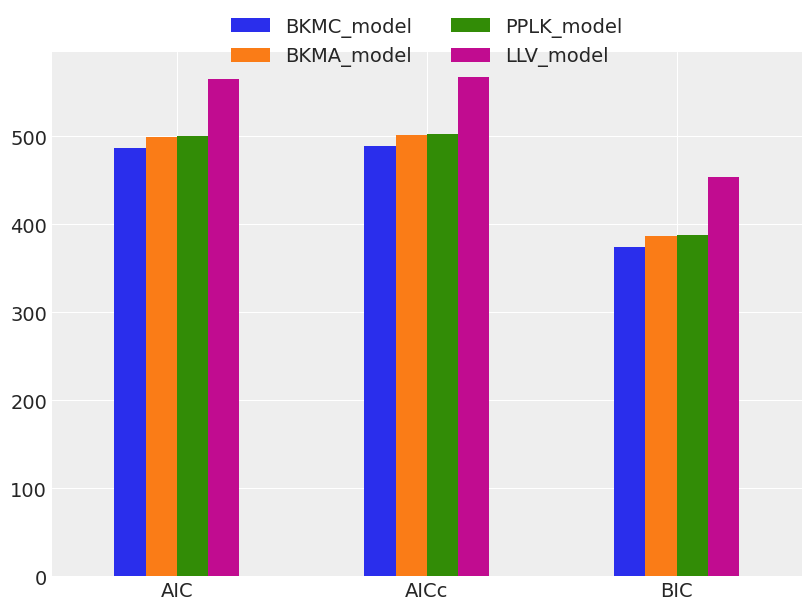

In [178]:
ax = df_ic_values.plot.bar(figsize=(8, 6), rot=0)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()

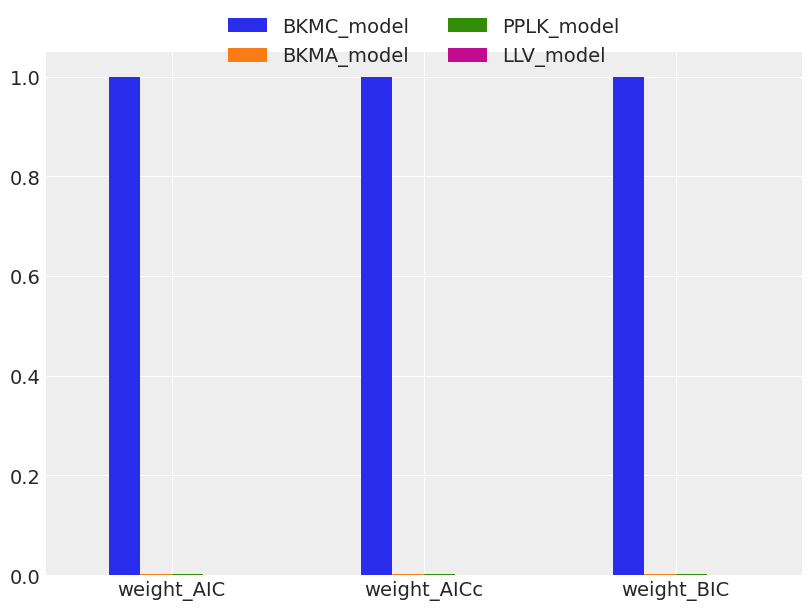

In [179]:
ax = df_ic_weights.plot.bar(figsize=(8, 6), rot=0)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()

# Uncertainty propagation

## BKMA model

In [180]:
import copy

t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_BKMA = copy.deepcopy(fine_model_BKMA)
with fine_model_to_forecast_BKMA:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_BKMA,
        var_names=["BKMA_model"],
        random_seed=seed
    )["BKMA_model"]  # Should we use likelihood_model or BKMA_model?

In [181]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

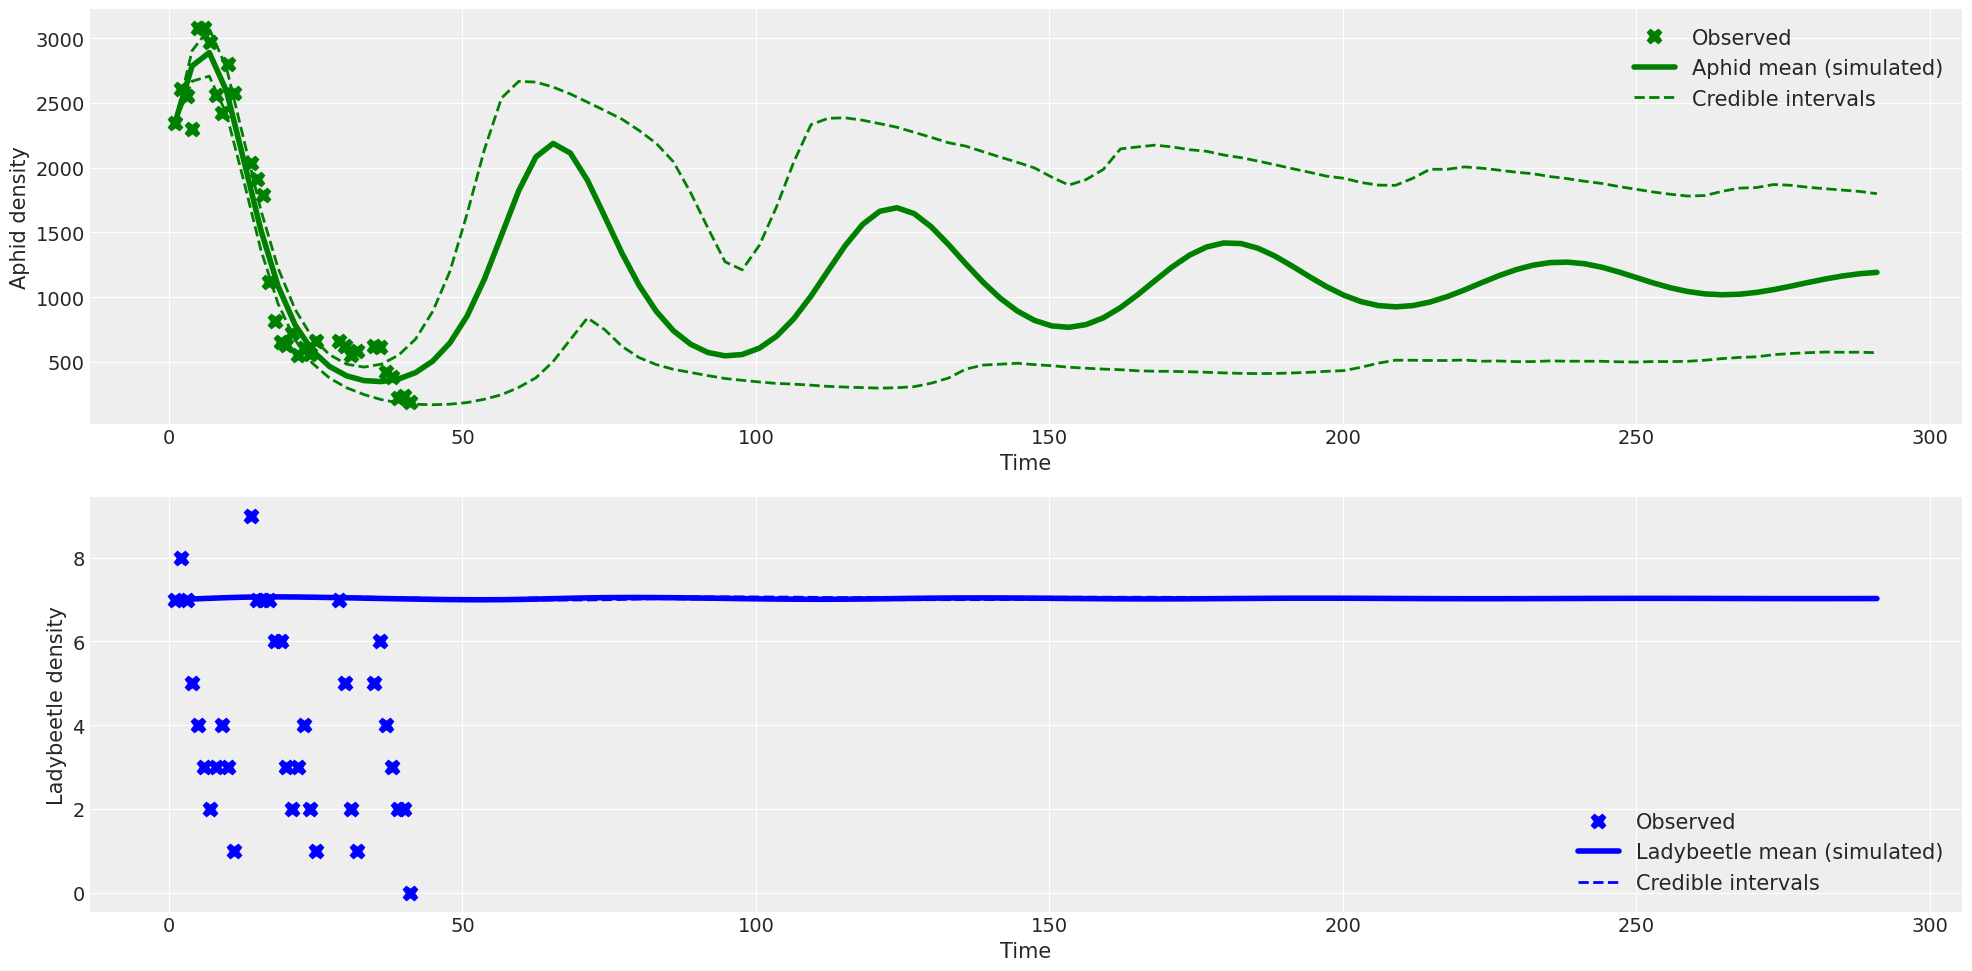

In [182]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections.png", dpi=300)
plt.show()

## BKMC model

In [183]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_BKMC = copy.deepcopy(fine_model_BKMC)
with fine_model_to_forecast_BKMC:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_BKMC,
        var_names=["BKMC_model"],
        random_seed=seed
    )["BKMC_model"]  # Should we use likelihood_model or BKMC_model?

In [184]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

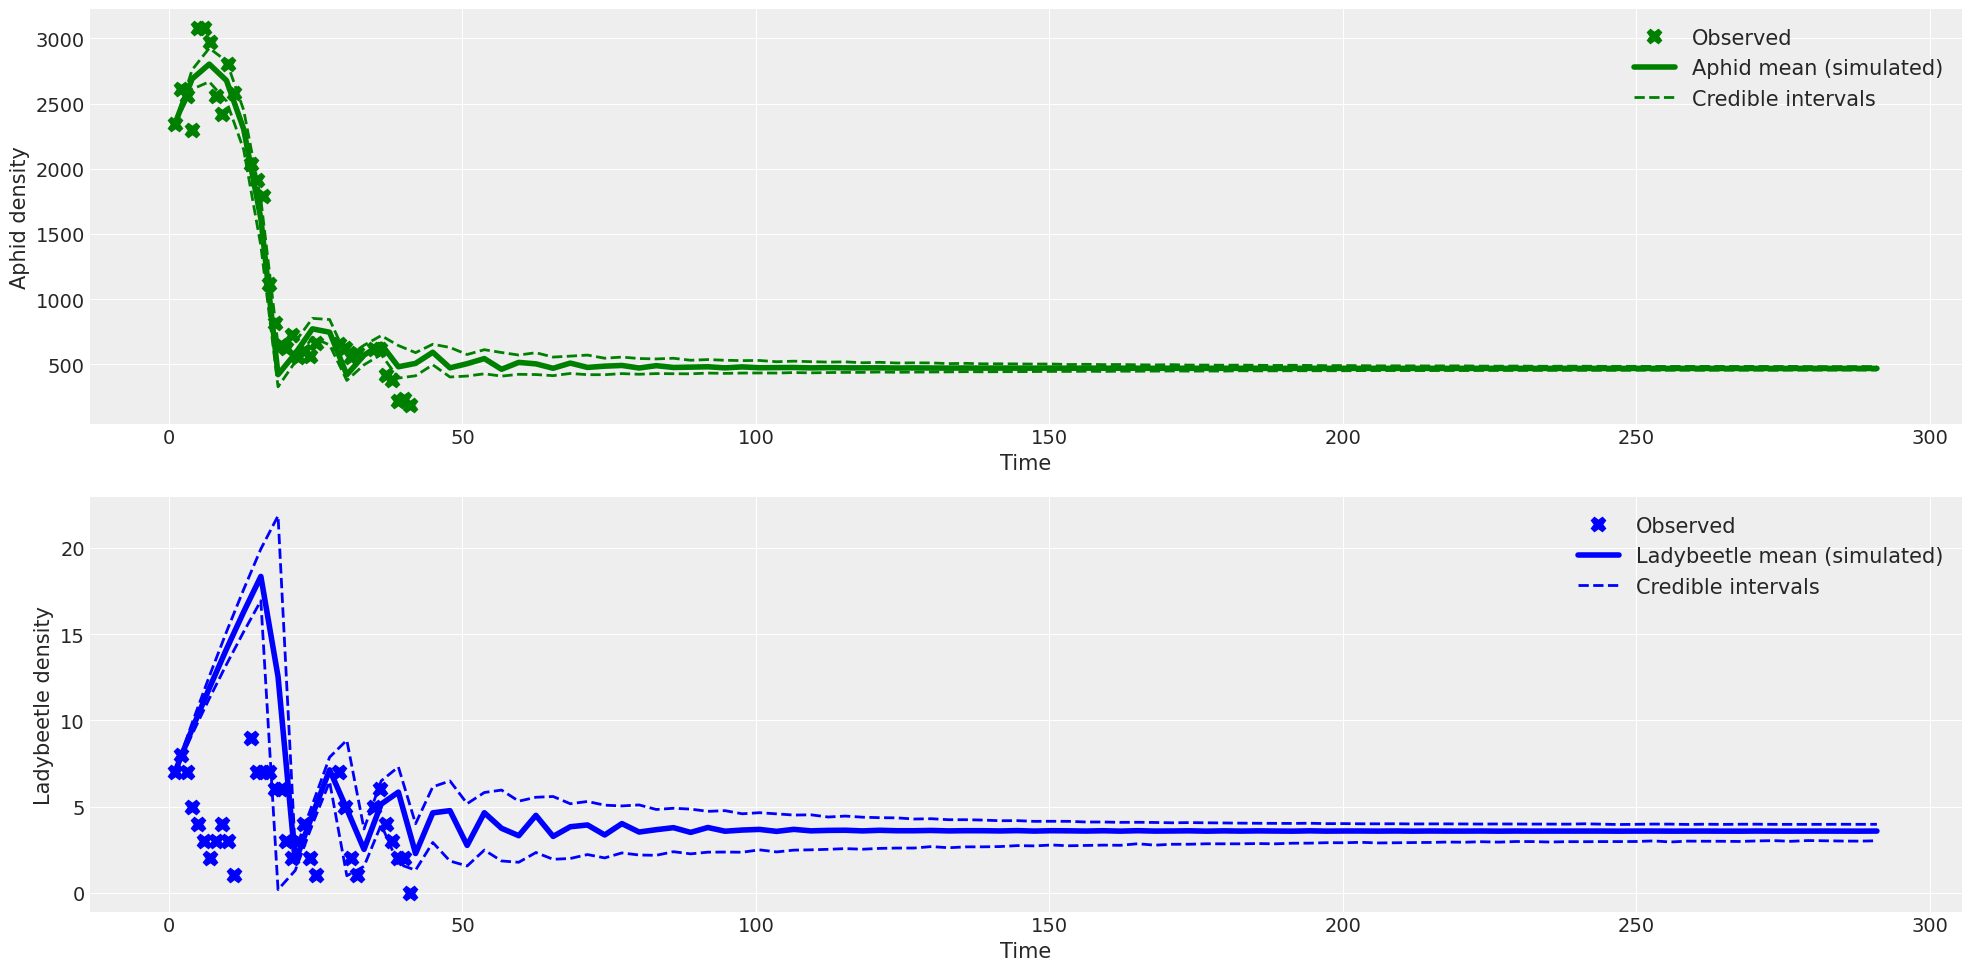

In [185]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections.png", dpi=300)
plt.show()

## PPLK model

In [186]:
t0 = aphid_data.Time.values.min()
tf = aphid_data.Time.values.max()
time_to_forecast = 250
time_range_prediction = np.linspace(t0, tf + time_to_forecast, 100)

fine_model_to_forecast_PPLK = copy.deepcopy(fine_model_PPLK)
with fine_model_to_forecast_PPLK:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_PPLK,
        var_names=["PPLK_model"],
        random_seed=seed
    )["PPLK_model"]  # Should we use likelihood_model or PPLK_model?

In [187]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

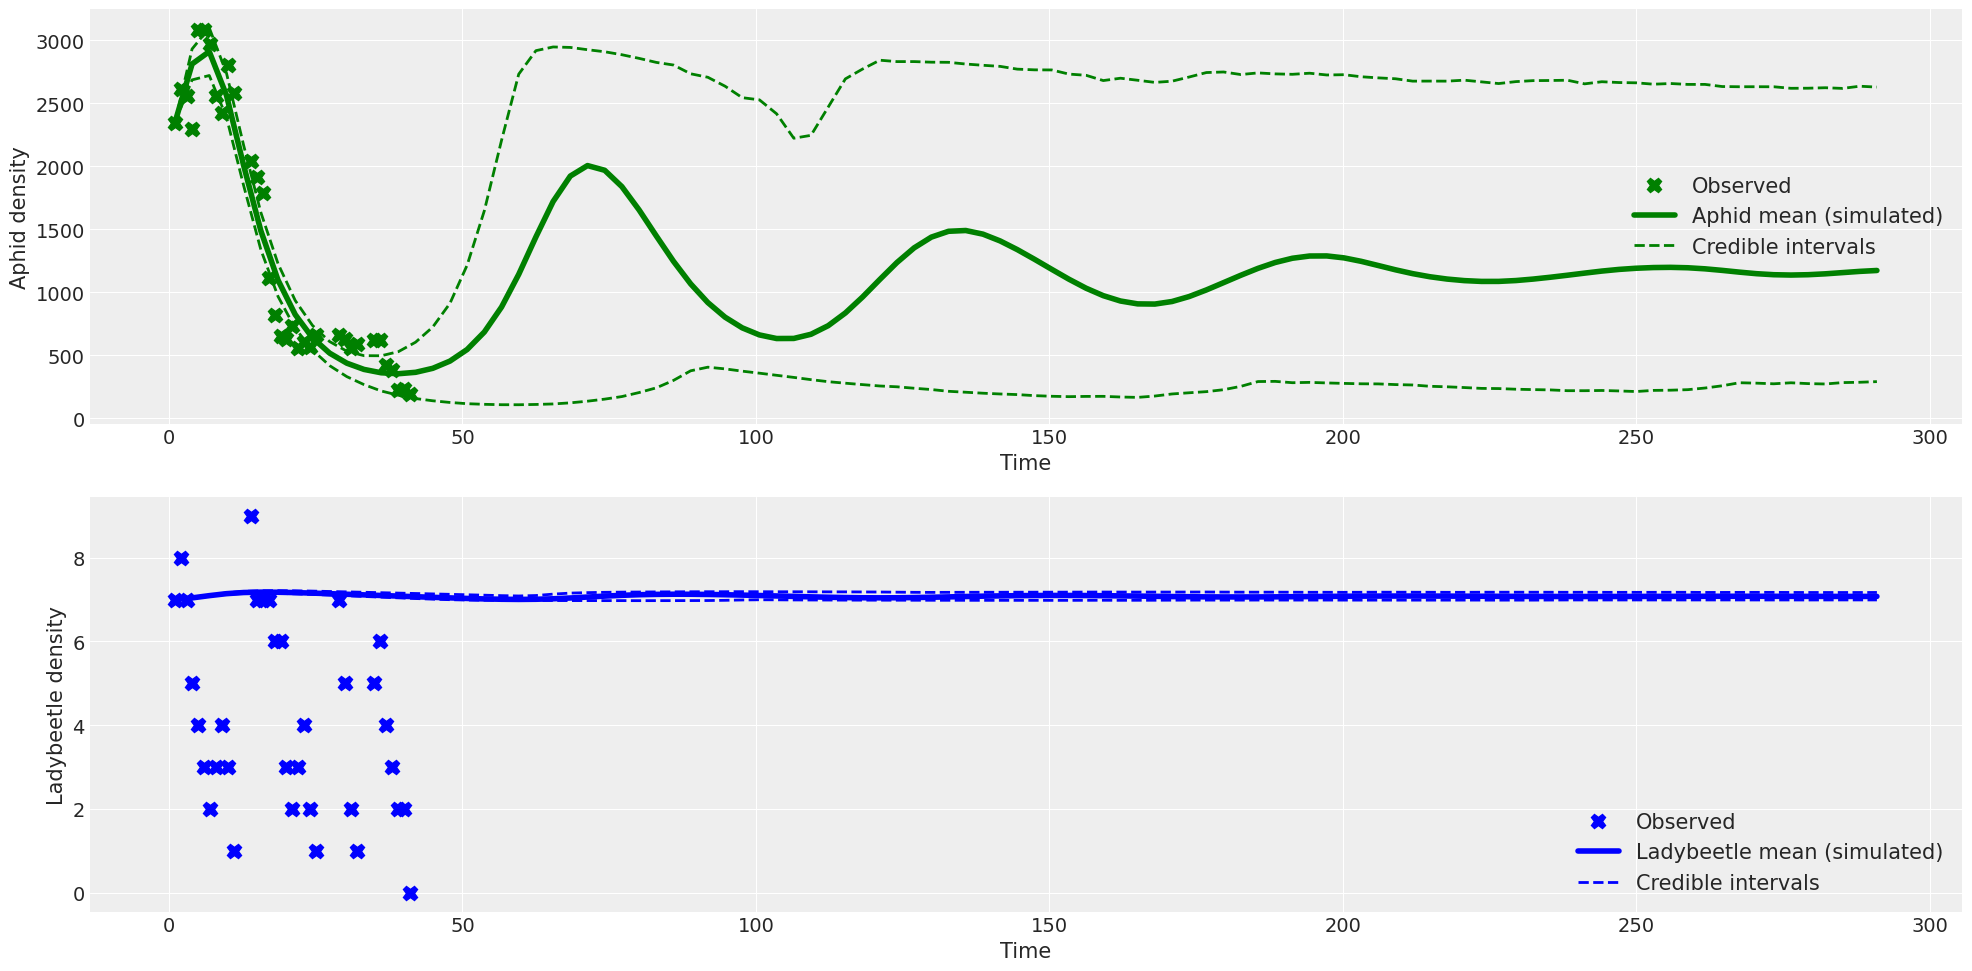

In [188]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections.png", dpi=300)
plt.show()

## LLV model

In [189]:
fine_model_to_forecast_LLV = copy.deepcopy(fine_model_LLV)
with fine_model_to_forecast_LLV:
    # We update the Data container "years"
    pm.set_data({"time": time_range_prediction})

    # Then we sample from the calibration posterior
    model_prediction = pm.sample_posterior_predictive(
        trace_calibration_LLV,
        var_names=["LLV_model"],
        random_seed=seed
    )["LLV_model"]  # likelihood_model or LLV_model?

In [190]:
mean_model_prediction = model_prediction.mean(axis=0)
percentile_cut = 2.5
credible_lower = np.percentile(model_prediction, q=percentile_cut, axis=0)
credible_upper = np.percentile(model_prediction, q=100 - percentile_cut, axis=0)

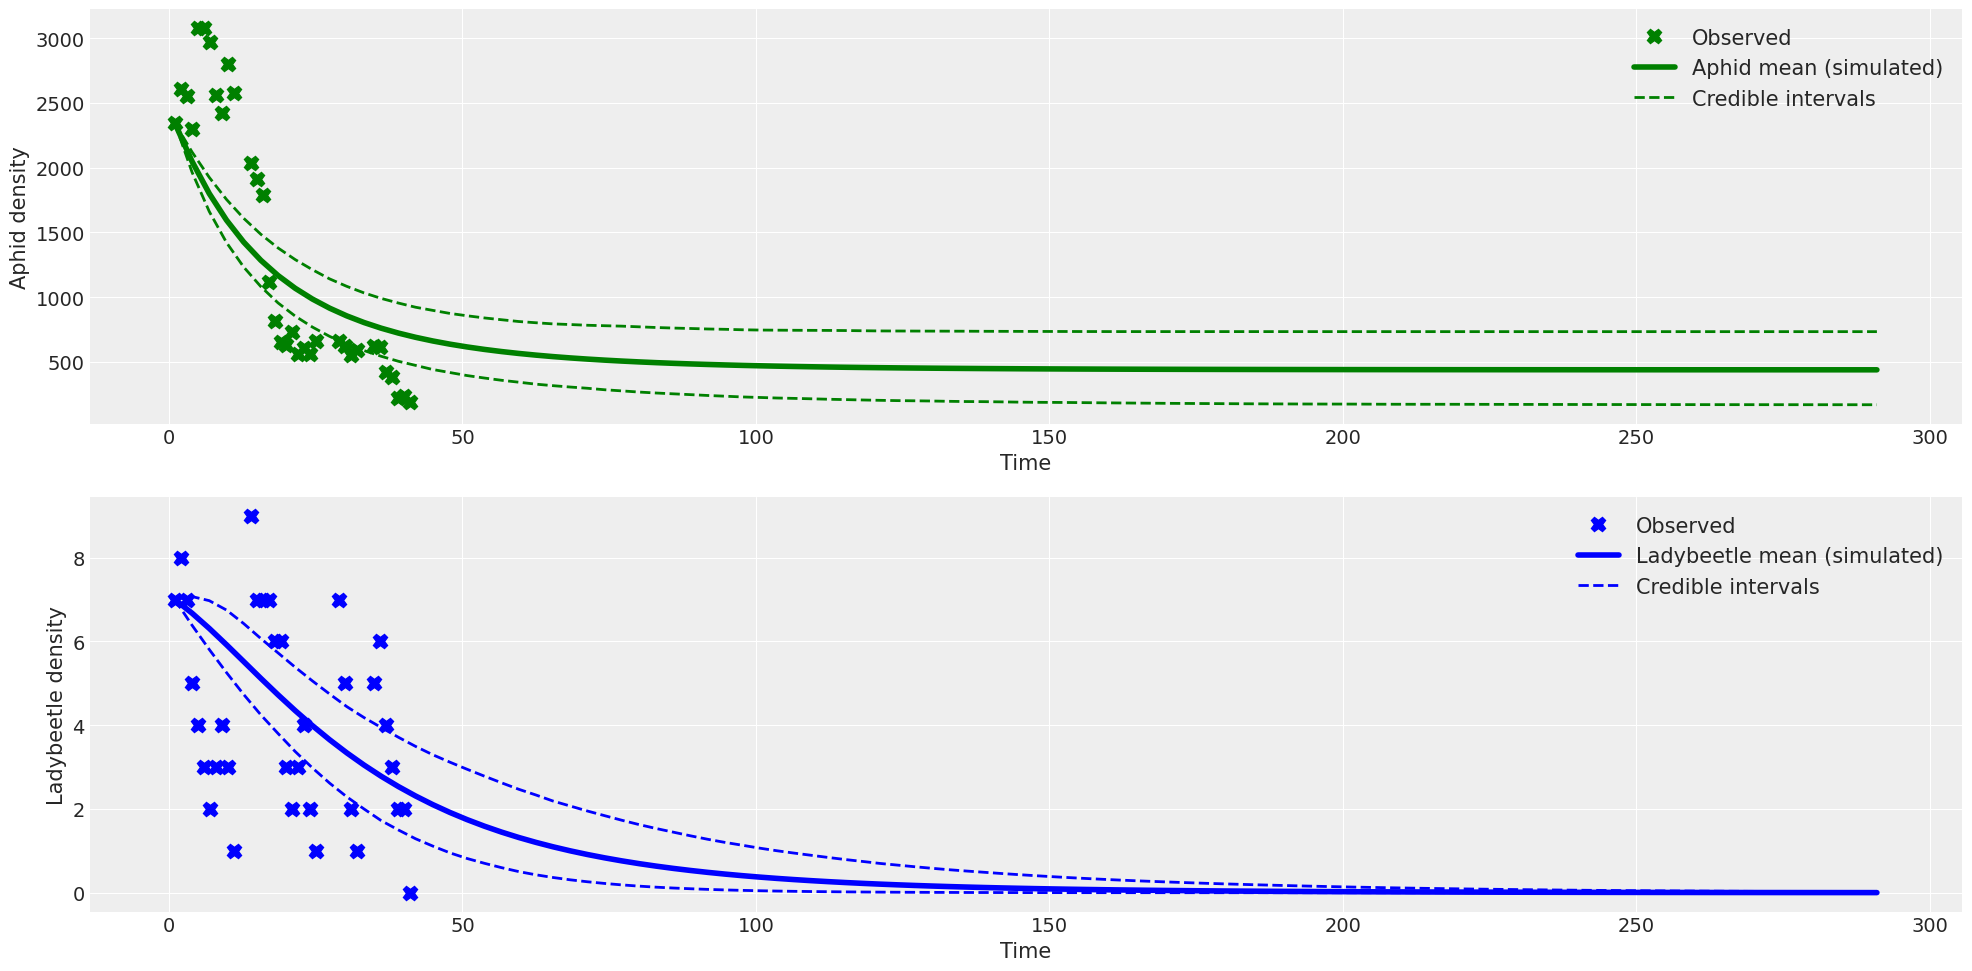

In [191]:
plt.figure(figsize=(20, 2*(5)))

plt.subplot(2, 1, 1)
plt.plot(time_observations, aphid_observed.Density.values, 'X', color='g', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,0], color='g', lw=4, label='Aphid mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,0], '--',  color='g', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,0], '--',  color='g', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Aphid density', fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(time_observations, ladybeetle_observed.Density.values, 'X', color='b', lw=4, ms=10.5, label='Observed')
plt.plot(time_range_prediction, mean_model_prediction[:,1], color='b', lw=4, label='Ladybeetle mean (simulated)')
plt.plot(time_range_prediction, credible_lower[:,1], '--', color='b', lw=2, label='Credible intervals')
plt.plot(time_range_prediction, credible_upper[:,1], '--',  color='b', lw=2)
plt.legend(fontsize=15, shadow=True)
plt.ylabel('Ladybeetle density', fontsize=15)
plt.xlabel('Time', fontsize=15)

plt.tight_layout()
plt.savefig("img/projections_LLV.png", dpi=300)
plt.show()